# Applied Project - Mean Reversion Strategy with Machine Learning Applications

## Load Packages & Set a Fixed Randomness Seed

In [108]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import keras_tuner as kt
import tensorflow as tf
from IPython.display import display
from eli5.sklearn import PermutationImportance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from statsmodels.api import OLS

plt.style.use('default')
random_state = 123
np.random.seed(123)

## Self-defined Functions

In [88]:
def volatility_parity(dataframe, target=0.03, notional=100, window=5, leverage_cap=2):
    """
    Generate a volatility targeting investment amount (weight) for each asset per day based on a self-defined target volatility and a self-defined rolling window.

    :param dataframe: pd.dataframe, a panel dataframe with several assets' daily returns over an arbitrary period.
    :param target: float64 > 0, self-defined annualized volatility target for each asset. (0.03 by default)
    :param notional: integer > 0, the notional amount that we originally allocate in each trade. (100 dollars by default)
    :param window: integer > 0, the rolling window (days) for calculating the annualized standard deviation (volatility). (5 days by default)
    :param leverage_cap: float64 >= 0.5,  the leverage cap applied to limit the scaled weights for assets. (2x by default)
    :return: a dataframe with the notional amount being volatility-adjusted for each asset per day.
    """

    frame = []
    dataframe_1 = pd.DataFrame()
    indexes = list(dataframe.columns)
    for index in indexes:
        vol = dataframe[index].rolling(window=window).std() * np.sqrt(252/window)
        vol_scaled_weight = (target/vol) * notional
        frame.append(vol_scaled_weight.to_frame(index))
        dataframe_1 = pd.concat(frame, axis=1)
        dataframe_1[dataframe_1 > leverage_cap * notional] = leverage_cap * notional
        dataframe_1[dataframe_1 < -leverage_cap * notional] = -leverage_cap * notional
    return dataframe_1.shift(1)


def get_price_df(signal, returns, nav=100, model_type=None):
    """

    :param signal:
    :param returns:
    :param nav:
    :param model_type:
    :return:
    """
    if model_type is None:
        initial1 = pd.Series({'1998-04-30':nav})
        initial1.index = pd.to_datetime(initial1.index, format='%Y-%m-%d')
        returns.index = returns.index.astype('str')

        signal.index = signal.index.astype('str')
        ols_strategy_monthly_return = (signal * returns).sum(axis=1) / abs(signal).sum(axis=1)
        cum_ols_strategy_return = nav * (1 + ols_strategy_monthly_return).cumprod().dropna()
        cum_ols_strategy_return.index = pd.to_datetime(cum_ols_strategy_return.index, format='%Y-%m') + pd.tseries.offsets.MonthEnd(1)
        cum_ols_strategy_return = pd.concat([initial1, cum_ols_strategy_return], axis=0)
        return cum_ols_strategy_return

    elif model_type == 'ML':
        initial2 = pd.Series({'1998-10-31':nav})
        initial2.index = pd.to_datetime(initial2.index, format='%Y-%m-%d')
        returns.index = returns.index.astype('str')

        signal.index = signal.index.astype('str')
        ml_strategy_monthly_return = (signal * returns).sum(axis=1) / abs(signal).sum(axis=1)
        cum_ml_strategy_return = nav * (1 + ml_strategy_monthly_return).cumprod().dropna()
        cum_ml_strategy_return.index = pd.to_datetime(cum_ml_strategy_return.index, format='%Y-%m') + pd.tseries.offsets.MonthEnd(1)
        cum_ml_strategy_return = cum_ml_strategy_return['1998-11-30':]
        cum_ml_strategy_return = pd.concat([initial2, cum_ml_strategy_return], axis=0)
        return cum_ml_strategy_return

    elif model_type == 'LSTM':
        initial3 = pd.Series({'1999-04-30':nav})
        initial3.index = pd.to_datetime(initial3.index, format='%Y-%m-%d')
        returns.index = returns.index.astype('str')

        signal.index = signal.index.astype('str')
        ml_strategy_monthly_return = (signal * returns).sum(axis=1) / abs(signal).sum(axis=1)
        cum_ml_strategy_return = nav * (1 + ml_strategy_monthly_return).cumprod().dropna()
        cum_ml_strategy_return.index = pd.to_datetime(cum_ml_strategy_return.index, format='%Y-%m') + pd.tseries.offsets.MonthEnd(1)
        cum_ml_strategy_return = cum_ml_strategy_return['1998-11-30':]
        cum_ml_strategy_return = pd.concat([initial3, cum_ml_strategy_return], axis=0)
        return cum_ml_strategy_return

    elif model_type == '13':
        initial4 = pd.Series({'2012-12-31':nav})
        initial4.index = pd.to_datetime(initial4.index, format='%Y-%m-%d')
        returns.index = returns.index.astype('str')

        signal.index = signal.index.astype('str')
        ml_strategy_monthly_return = (signal * returns).sum(axis=1) / abs(signal).sum(axis=1)
        cum_ml_strategy_return = nav * (1 + ml_strategy_monthly_return).cumprod().dropna()
        cum_ml_strategy_return.index = pd.to_datetime(cum_ml_strategy_return.index, format='%Y-%m') + pd.tseries.offsets.MonthEnd(1)
        cum_ml_strategy_return = cum_ml_strategy_return['1998-11-30':]
        cum_ml_strategy_return = pd.concat([initial4, cum_ml_strategy_return], axis=0)
        return cum_ml_strategy_return


def get_performance_stats(prices, rfr=0, label=None):
    """
    Generate the performance stats for a time-series price data.

    :param prices: pd.Series or np.array
    :param rfr: risk-free returns as pd.Series or np.array (0 by default)
    :param label: strings, column label as string
    :return: stats - pd.dataframe with statistics (performance measures) organized by row with exact labels:
             Tot Ret     - total cumulative return over the whole period
             Avg Ret     - average annualised return
             rfr         - average annualised risk-free return
             Std         - annualised standard deviation
             SR          - annualised Sharpe Ratio
             Skew        - skewness (same frequency as prices)
             Kurt        - kurtosis (same frequency as prices)
             HWM         - High Water Mark price, i.e. the highest price ever achieved
             HWM date    - date of the HWM
             MDD         - Maximum Drawdown as positive proportional loss from prior peak
             Peak date   - Date of the MDD peak
             Trough date - Date of the MDD trough
             Rec date    - Date the asset recovered from Drawdown loss
             MDD dur     - MDD duration in days from peak to recovery date
    """

    month = 12                                                                                     # Number of month in a year
    # Pre-allocate empty dataframe
    if label is None:
        stats = pd.DataFrame(index=[0])
    else:
        stats = pd.DataFrame(index=[label])

    returns = prices.pct_change()
    last_index = prices.shape[0] - 1                                                               # need - 1 since array referencing starts from 0
    p_last = prices[last_index]
    stats['Total Return'] = (p_last - prices[0]) / prices[0]                                       # (prices[ prices.shape[0]] / prices[0])-1 does same in 1 step
    stats['Avg Return'] = (1 + stats['Total Return']) ** (12 / len(prices)) - 1
    stats['Rf Rate'] = rfr.mean(axis=0)[0]                                                                  # Note the convention for interbank rate is 365 days
    stats['Volatility'] = returns.std() * np.sqrt(month)                                           # sigma*sqrt(T)
    stats['Sharpe Ratio']  = (stats['Avg Return'] - stats['Rf Rate']) / stats['Volatility'] # Sharpe Ratio
    stats['Skewness'] = returns.skew()                                                             # For normal should be 0
    stats['Kurtosis'] = returns.kurtosis()                                                         # For normal should be 3
    hwm_time = prices.idxmax()                                                                     # returns argument corresponding to max price (i.e. Timestamp, e.g. Timestamp('2018-01-26 00:00:00'))
    stats['HWM'] = prices.max()                                                                    # returns max price
    stats['HWM date'] = hwm_time.date()                                                            # converts Timestamp('2018-01-26 00:00:00') to datetime.date(2018, 1, 26)
    dd = prices.cummax() - prices                                                                  # get all Draw downs: diffs between cumulative max price and current price
    end_mdd  = dd.idxmax()
    start_mdd = prices[:end_mdd].idxmax()
    # Maximum Draw down as positive proportional loss from peak
    stats['MDD'] = 1 - prices[end_mdd] / prices[start_mdd]                                         # (same as P_start - P_end) / P_start
    stats['Peak Date'] = start_mdd.date()
    stats['Trough Date'] = end_mdd.date()
    bool_p = prices[end_mdd:] > prices[start_mdd]                                                  # True/False current price > price of DD peak

    if bool_p.idxmax().date() > bool_p.idxmin().date():
        stats['Recession Date'] = bool_p.idxmax().date()
        stats['MDD Duration'] = (stats['Recession Date'] - stats['Peak Date'])[0].days             # MDD duration in days from peak to recovery date
    else:
        stats['Recession Date'] = stats['MDD Duration']  = 'Yet to recover'
    return stats


def get_performance_stats_2(signal, returns, market_cap, label=None, model_type=None):
    """

    :param signal:
    :param returns:
    :param market_cap:
    :param label:
    :param model_type:
    :return:
    """

    signal.index = signal.index.astype('str')
    returns.index = returns.index.astype('str')
    market_cap.index = market_cap.index.astype('str')

    # Pre-allocate empty dataframe
    if label is None:
        stats1 = pd.DataFrame(index=['(Long & Short)'])
        stats2 = pd.DataFrame(index=['(Long Position)'])
        stats3 = pd.DataFrame(index=['(Short Position)'])
    else:
        stats1 = pd.DataFrame(index=[label + ' (Long & Short)'])
        stats2 = pd.DataFrame(index=['(Long Position)'])
        stats3 = pd.DataFrame(index=['(Short Position)'])


    long_short_positions = signal
    long_positions = signal.replace(-1, 0)
    short_positions = signal.replace(1, 0)

    long_short_returns = (signal * returns).replace(-0, 0)
    long_short_sum = long_short_returns.sum(axis=1)
    long_short_returns_98_10 = long_short_returns[:152]
    long_short_returns_11_22 = long_short_returns[152:]
    long_returns = (long_positions * returns).replace(-0, 0)
    long_sum = long_returns.sum(axis=1)
    long_returns_98_10 = long_returns[:152]
    long_returns_11_22 = long_returns[152:]
    short_returns = (short_positions * returns).replace(-0, 0)
    short_sum = short_returns.sum(axis=1)
    short_returns_98_10 = short_returns[:152]
    short_returns_11_22 = short_returns[152:]


    df_transactions = pd.DataFrame({'1998-05':[abs(long_short_positions.iloc[0]).sum()]})

    for l in range(len(long_short_positions.index[:-1])):
        df_2months = long_short_positions[l:l+2].T
        df_2months['diff'] = df_2months.iloc[:,1] - df_2months.iloc[:,0]
        turnover = np.count_nonzero(df_2months['diff'])
        df_transactions = pd.concat([df_transactions, pd.DataFrame({long_short_positions.index[l+1]: [turnover]})], axis=1)


    df_transactions_1 = pd.DataFrame({'1998-05':[abs(long_positions.iloc[0]).sum()]})

    for l in range(len(long_positions.index[:-1])):
        df_2months = long_positions[l:l+2].T
        df_2months['diff'] = df_2months.iloc[:,1] - df_2months.iloc[:,0]
        turnover = np.count_nonzero(df_2months['diff'])
        df_transactions_1 = pd.concat([df_transactions_1, pd.DataFrame({long_positions.index[l+1]: [turnover]})], axis=1)


    df_transactions_2 = pd.DataFrame({'1998-05':[abs(short_positions.iloc[0]).sum()]})

    for l in range(len(short_positions.index[:-1])):
        df_2months = short_positions[l:l+2].T
        df_2months['diff'] = df_2months.iloc[:,1] - df_2months.iloc[:,0]
        turnover = np.count_nonzero(df_2months['diff'])
        df_transactions_2 = pd.concat([df_transactions_2, pd.DataFrame({short_positions.index[l+1]: [turnover]})], axis=1)


    if model_type is None:
        prices1 = get_price_df(long_short_positions, returns, model_type=None)
        last_index1 = prices1.shape[0] - 1
        p_last1 = prices1[last_index1]
        stats1['Total Return'] = (p_last1 - prices1[0]) / prices1[0]
    elif model_type == 'ML':
        prices1 = get_price_df(long_short_positions, returns, model_type='ML')
        last_index1 = prices1.shape[0] - 1
        p_last1 = prices1[last_index1]
        stats1['Total Return'] = (p_last1 - prices1[0]) / prices1[0]
    elif model_type =='LSTM':
        prices1 = get_price_df(long_short_positions, returns, model_type='LSTM')
        last_index1 = prices1.shape[0] - 1
        p_last1 = prices1[last_index1]
        stats1['Total Return'] = (p_last1 - prices1[0]) / prices1[0]
    elif model_type =='13':
        prices1 = get_price_df(long_short_positions, returns, model_type='13')
        last_index1 = prices1.shape[0] - 1
        p_last1 = prices1[last_index1]
        stats1['Total Return'] = (p_last1 - prices1[0]) / prices1[0]

    stats1['Avg Monthly Return'] = (1 + stats1['Total Return']) ** (1 / len(prices1)) - 1
    stats1['Avg Mkt Cap'] = (long_short_positions.replace(-1, 1) * df_market_cap).replace(0, np.nan).mean(axis=1).mean()
    stats1['Fraction>0'] = long_short_sum[long_short_sum > 0].count() / len(long_short_sum)
    stats1['+ Return Stocks (Avg)'] = long_short_returns[long_short_returns > 0].mean(axis=1).mean()
    stats1['- Return Stocks (Avg)'] = long_short_returns[long_short_returns < 0].mean(axis=1).mean()
    stats1['Odds Ratio'] = long_short_returns[long_short_returns > 0].count(axis=1).sum() / long_short_returns[long_short_returns != 0].count(axis=1).sum()
    stats1['Odds Ratio 98-10'] = long_short_returns_98_10[long_short_returns_98_10 > 0].count(axis=1).sum() / long_short_returns_98_10[long_short_returns_98_10 != 0].count(axis=1).sum()
    stats1['Odds Ratio 11-22'] = long_short_returns_11_22[long_short_returns_11_22 > 0].count(axis=1).sum() / long_short_returns_11_22[long_short_returns_11_22 != 0].count(axis=1).sum()
    stats1['Transactions/Month'] = df_transactions.mean(axis=1)[0]


    if model_type is None:
        prices2 = get_price_df(long_positions, returns, model_type=None)
        last_index2 = prices2.shape[0] - 1
        p_last2 = prices2[last_index2]
        stats2['Total Return'] = (p_last2 - prices2[0]) / prices2[0]
    elif model_type == 'ML':
        prices2 = get_price_df(long_positions, returns, model_type='ML')
        last_index2 = prices2.shape[0] - 1
        p_last2 = prices2[last_index2]
        stats2['Total Return'] = (p_last2 - prices2[0]) / prices2[0]
    elif model_type =='LSTM':
        prices2 = get_price_df(long_positions, returns, model_type='LSTM')
        last_index2 = prices2.shape[0] - 1
        p_last2 = prices2[last_index2]
        stats2['Total Return'] = (p_last2 - prices2[0]) / prices2[0]
    elif model_type =='13':
        prices2 = get_price_df(long_positions, returns, model_type='13')
        last_index2 = prices2.shape[0] - 1
        p_last2 = prices2[last_index2]
        stats2['Total Return'] = (p_last2 - prices2[0]) / prices2[0]

    stats2['Avg Monthly Return'] = (1 + stats2['Total Return']) ** (1 / len(prices2)) - 1
    stats2['Avg Mkt Cap'] = (long_positions * df_market_cap).replace(0, np.nan).mean(axis=1).mean()
    stats2['Fraction>0'] = long_sum[long_sum > 0].count() / len(long_sum)
    stats2['+ Return Stocks (Avg)'] = long_returns[long_returns > 0].mean(axis=1).mean()
    stats2['- Return Stocks (Avg)'] = long_returns[long_returns < 0].mean(axis=1).mean()
    stats2['Odds Ratio'] = long_returns[long_returns > 0].count(axis=1).sum() / long_returns[long_returns != 0].count(axis=1).sum()
    stats2['Odds Ratio 98-10'] = long_returns_98_10[long_returns_98_10 > 0].count(axis=1).sum() / long_returns_98_10[long_returns_98_10 != 0].count(axis=1).sum()
    stats2['Odds Ratio 11-22'] = long_returns_11_22[long_returns_11_22 > 0].count(axis=1).sum() / long_returns_11_22[long_returns_11_22 != 0].count(axis=1).sum()
    stats2['Transactions/Month'] = df_transactions_1.mean(axis=1)[0]


    if model_type is None:
        prices3 = get_price_df(short_positions, returns, model_type=None)
        last_index3 = prices3.shape[0] - 1
        p_last3 = prices3[last_index3]
        stats3['Total Return'] = (p_last3 - prices3[0]) / prices3[0]
    elif model_type == 'ML':
        prices3 = get_price_df(short_positions, returns, model_type='ML')
        last_index3 = prices3.shape[0] - 1
        p_last3 = prices3[last_index3]
        stats3['Total Return'] = (p_last3 - prices3[0]) / prices3[0]
    elif model_type == 'LSTM':
        prices3 = get_price_df(short_positions, returns, model_type='LSTM')
        last_index3 = prices3.shape[0] - 1
        p_last3 = prices3[last_index3]
        stats3['Total Return'] = (p_last3 - prices3[0]) / prices3[0]
    elif model_type == '13':
        prices3 = get_price_df(short_positions, returns, model_type='13')
        last_index3 = prices3.shape[0] - 1
        p_last3 = prices3[last_index3]
        stats3['Total Return'] = (p_last3 - prices3[0]) / prices3[0]

    stats3['Avg Monthly Return'] = (1 + stats3['Total Return']) ** (1 / len(prices2)) - 1
    stats3['Avg Mkt Cap'] = (short_positions.replace(-1, 1) * df_market_cap).replace(0, np.nan).mean(axis=1).mean()
    stats3['Fraction>0'] = short_sum[short_sum > 0].count() / len(short_sum)
    stats3['+ Return Stocks (Avg)'] = short_returns[short_returns > 0].mean(axis=1).mean()
    stats3['- Return Stocks (Avg)'] = short_returns[short_returns < 0].mean(axis=1).mean()
    stats3['Odds Ratio'] = short_returns[short_returns > 0].count(axis=1).sum() / short_returns[short_returns != 0].count(axis=1).sum()
    stats3['Odds Ratio 98-10'] = short_returns_98_10[short_returns_98_10 > 0].count(axis=1).sum() / short_returns_98_10[short_returns_98_10 != 0].count(axis=1).sum()
    stats3['Odds Ratio 11-22'] = short_returns_11_22[short_returns_11_22 > 0].count(axis=1).sum() / short_returns_11_22[short_returns_11_22 != 0].count(axis=1).sum()
    stats3['Transactions/Month'] = df_transactions_2.mean(axis=1)[0]

    return pd.concat([stats1, stats2, stats3], axis=0)

## Data Loading & Preprocessing

In [3]:
os.chdir('C:/Python/Data')

acc_items_df = pd.read_csv('AP_Compustat_accounting_items_198701_202207.csv')
price_df = pd.read_csv('AP_Compustat_prices_198701_202207_1.csv')
risk_free_rate_df = pd.read_csv('FEDFUNDS.csv', index_col=0)

risk_free_rate_df['FEDFUNDS'] = risk_free_rate_df['FEDFUNDS']/100

acc_items_df['datadate'] = pd.to_datetime(acc_items_df['datadate']).dt.to_period('M')
price_df['datadate'] = pd.to_datetime(price_df['datadate']).dt.to_period('M')
acc_items_df['cusip'] = acc_items_df['cusip'].astype('str')
price_df['cusip'] = price_df['cusip'].astype('str')

# I only keep the companies that are listed on the NYSE, Amex, or NASDAQ-NMS.
USA_listed = [11, 12, 14]
price_df = price_df.loc[price_df['exchg'].isin(USA_listed)]

# I found that there are duplicates appearing in the datasets, so I delete them here.
price_df = price_df.drop_duplicates(subset=['cusip', 'datadate'], keep='first')
acc_items_df = acc_items_df.drop_duplicates(subset=['cusip', 'datadate'], keep='first')

# I only maintain the stocks which possess the stock prices and the accounting items.
list_acc = list(acc_items_df['cusip'].unique())
list_price = list(price_df['cusip'].unique())
list_intersect = list(set(list_acc) & set(list_price))
acc_items_df = acc_items_df[acc_items_df['cusip'].isin(list_intersect)]
price_df = price_df[price_df['cusip'].isin(list_intersect)]

# The dataframe with 21 accounting items (updated quarterly)
acc_21_df = acc_items_df[['datadate', 'cusip', 'acoq', 'aoq', 'atq',
                          'ceqq', 'cheq', 'dlttq', 'dvpq', 'ibadjq',
                          'ibq', 'lcoq', 'loq', 'ltq', 'niq',
                          'nopiq', 'piq', 'ppentq', 'pstkq', 'saleq',
                          'txtq', 'xidoq', 'dvy']]

acc_21_df.set_index(['cusip', 'datadate'], inplace=True)
list_21 = list(acc_21_df.columns)

# The dataframe with stock high, low, close prices and the number of shares outstanding (updated monthly)
price_df = price_df[['datadate', 'cusip', 'prccm', 'prchm', 'prclm', 'trt1m', 'cshom']]
price_df['trt1m'] = price_df['trt1m'] / 100
price_df['Market_Cap'] = price_df['prccm'] * price_df['cshom']
price_df['True_Range'] = np.maximum((price_df['prchm'] - price_df['prclm']), abs(price_df['prchm'] - price_df['prccm']), abs(price_df['prclm'] - price_df['prccm']))
price_df['3m_ATR'] = price_df.groupby('cusip')['True_Range'].transform(lambda x: x.rolling(3, 1).mean())
price_df = price_df[['datadate', 'cusip', 'prccm', 'prchm', 'prclm', 'trt1m', 'cshom', 'True_Range', '3m_ATR', 'Market_Cap']]
price_df.set_index(['cusip', 'datadate'], inplace=True)

## Data Cleaning

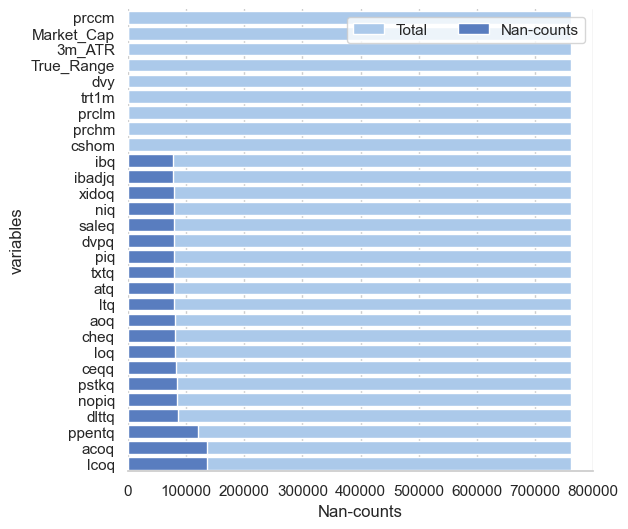

In [4]:
# Combine the two dataframes with applying monthly as the data frequency.
df_21 = price_df.join(acc_21_df, how='left')

# Assume that not until the end of this quarter can I access last quarter's financial data. (3 months later)
# 10-K's deadline can be up to 90 days after the end of the fiscal year-end.
# 10-Q's deadline can be up to 45 days after the end of the quarter-end.
df_21.iloc[:, 8:] = df_21.iloc[:, 8:].groupby(level=0).shift(3)

# Here I forward-fill the accounting items by max 2 months (Convert quarterly data into monthly data).
df_21.loc[:, list_21] = df_21.loc[:, list_21].ffill(limit=2)

# Since I found that sometimes if there is no dividend payment, the dividend payments would be filled with NA instead of 0, I chose to transfer all the NA in dvy into 0.
df_21['dvy'] = df_21['dvy'].fillna(0)

# For the data without total returns, I delete them all.
df_21.dropna(subset=['trt1m'], inplace=True)

# For the time-series data without market capitalisation, I delete them from the dataset since they are not predictable and comparable.
df_21.dropna(subset=['cshom', 'Market_Cap'], inplace=True)

# To avoid investing in the illiquid small stocks, I eliminated the micro-cap stocks using a monthly threshold of a 300 million USD market cap.
df_21 = df_21[df_21['Market_Cap'] >= 300000000]

# To avoid investing in the illiquid small stocks, I eliminated the micro-cap stocks using a monthly threshold of a 10 USD share price.
df_21 = df_21[df_21['prccm'] >= 10]

# Check the ratio of missing data in each column
raw = df_21.copy()
nans = pd.DataFrame(raw.isnull().sum())
nans = nans.reset_index()
nans.columns = ['variables', 'Nan-counts']
nans = nans.sort_values('Nan-counts')
nans = nans.reset_index(drop=True)
nans['total'] = raw.shape[0]
sns.set_theme(style='whitegrid')
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x='total', y='variables', data=nans, label='Total', color='b')
sns.set_color_codes('muted')
sns.barplot(x='Nan-counts', y='variables', data=nans, label='Nan-counts', color='b')
ax.legend(ncol=2, loc='upper right', frameon=True)
sns.despine(left=True, bottom=False)

In [5]:
# Here I divide the dataframe into a frame with stock returns and a frame with target and features.
df_target_features = df_21.iloc[:, 7:].copy()
df_price_return = df_21.iloc[:, 0:8].copy()

# Here I drop all the missing values in the dataframe with target and features.
df_target_features.dropna(inplace=True)

tickers = list(set(df_price_return.index.get_level_values(0)))
tickers_1 = list(set(df_target_features.index.get_level_values(0)))

print('Number of companies in prices & returns dataset: {:.0f}'.format(len(tickers)))
print('Number of companies in target & features dataset: {:.0f}'.format(len(tickers_1)))

Number of companies in prices & returns dataset: 9178
Number of companies in target & features dataset: 7611


In [6]:
# The main reason why I choose to screen the df_price_return with companies' Cusip separately here is that, by doing so, I can keep as much return data as possible. For example, if I didn't divide the dataset into two sets when I dropped all missing features, I would also delete the return data of the same company in the same month even if only the features are missing but the price and return data exist. Then, if I choose to buy the company's stock based on its previous month's data, I will not be able to calculate its return for this month. It will cause some problems, so I choose to rule out the prices and returns dataset at the company level.

list_intersect_1 = list(set(tickers) & set(tickers_1))
df_price_return = df_price_return[df_price_return.index.get_level_values(0).isin(list_intersect_1)]
df_target_features = df_target_features[df_target_features.index.get_level_values(0).isin(list_intersect_1)]

tickers = list(set(df_price_return.index.get_level_values(0)))
tickers_1 = list(set(df_target_features.index.get_level_values(0)))

print('Number of Companies in Prices & Returns Dataset: {:.0f}'.format(len(tickers)))
print('Number of Companies in Target & Features Dataset: {:.0f}'.format(len(tickers_1)))
# So far I have 7611 companies in both datasets

Number of Companies in Prices & Returns Dataset: 7611
Number of Companies in Target & Features Dataset: 7611


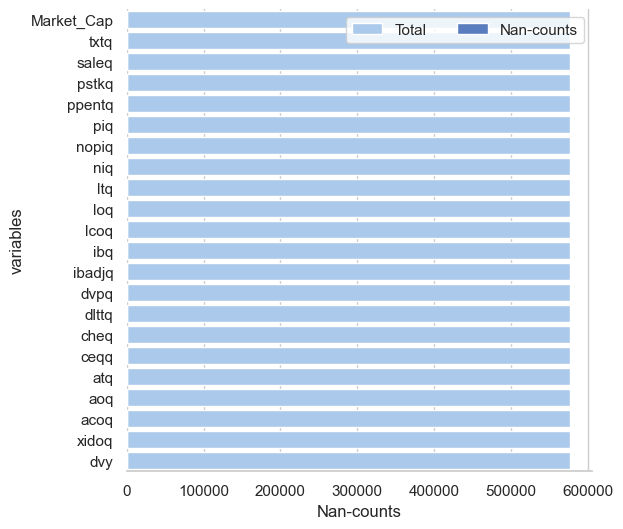

In [7]:
# I double-check if there is any missing value existing in the features and target dataframe, and I also check the amount of remaining data.
raw_1 = df_target_features.copy()
nans = pd.DataFrame(raw_1.isnull().sum())
nans = nans.reset_index()
nans.columns = ['variables', 'Nan-counts']
nans = nans.sort_values('Nan-counts')
nans = nans.reset_index(drop=True)
nans['total'] = raw_1.shape[0]
sns.set_theme(style='whitegrid')
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x='total', y='variables', data=nans, label='Total', color='b')
sns.set_color_codes('muted')
sns.barplot(x='Nan-counts', y='variables', data=nans, label='Nan-counts', color='b')
ax.legend(ncol=2, loc='upper right', frameon=True)
sns.despine(left=True, bottom=False)

In [ ]:
"""
# Here I generate a return dataframe with year-month as the index and Cusip as the columns
timeline = pd.date_range(start='1998-04-01', end='2022-6-30', freq='M').to_period('M')
df_returns = pd.DataFrame(index=timeline)

for i in tickers:
    df_returns = df_returns.merge(df_price_return.loc[i, 'trt1m'].rename(i), how='left', left_index=True, right_index=True)

df_returns.fillna(0, inplace=True)
df_returns = df_returns.iloc[1:,:]
df_returns.to_csv('AP_returns_data.csv')
list_company = list(df_returns.columns)
display(df_returns)
"""

In [ ]:
"""
# Here I generate a market cap dataframe with year-month as the index and Cusip as the columns
timeline = pd.date_range(start='1998-04-01', end='2022-6-30', freq='M').to_period('M')
df_market_cap = pd.DataFrame(index=timeline)

for i in tickers:
    df_market_cap = df_market_cap.merge(df_price_return.loc[i, 'Market_Cap'].rename(i), how='left', left_index=True, right_index=True)

df_market_cap.fillna(0, inplace=True)
df_market_cap = df_market_cap.iloc[1:,:]
df_market_cap.to_csv('AP_market_cap_data.csv')
display(df_market_cap)
"""

In [8]:
df_returns = pd.read_csv('AP_returns_data_300.csv', index_col=0)
df_market_cap = pd.read_csv('AP_market_cap_data_300.csv', index_col=0)
list_company = list(df_returns.columns)

In [9]:
# To avoid affecting the original dataset, I use the copy of the dataset to conduct further analysis
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
date_list = list(raw_1.datadate.unique().astype('str'))
date_list.sort()
# Since I don't have the 2022-07 return data, I choose not to use the feature data in 2022-06.
date_list = date_list[:-1]
# Here I calculate the average number of companies we have in the dataset on a monthly basis
df_1 = pd.DataFrame(index=date_list)
for i in date_list:
    df_1.loc[i, 0] = raw_1[raw_1.datadate == i]['cusip'].nunique()
print('Average Number of Companies in Each Month of The Dataset: {:.0f} Companies'.format(df_1[0].mean(axis=0)))

Average Number of Companies in Each Month of The Dataset: 1981 Companies


In [10]:
quintile_position = np.repeat([-1, 0, 1], [1, 3, 1]).tolist()
decile_position = np.repeat([-1, 0, 1], [1, 8, 1]).tolist()
twenths_position = np.repeat([-1, 0, 1], [1, 18, 1]).tolist()
percentile_position = np.repeat([-1, 0, 1], [1, 98, 1]).tolist()
quintile_rank = list(range(0, 5))
decile_rank = list(range(0, 10))
twenths_rank = list(range(0, 20))
percentile_rank = list(range(0, 100))
x = [str(year) for year in list(range(1999, 2023))]
feature_names = list(df_target_features.columns)[1:]

## 1. OLS Regression Model for Fair Value Estimation (Baseline Strategy)

In [11]:
OLS_model = LinearRegression(fit_intercept=True)
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
raw_1['datadate'] = raw_1['datadate'].astype('str')
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]
df_OLS_Quintile_Signal = pd.DataFrame(index=list_company)
df_OLS_Decile_Signal = pd.DataFrame(index=list_company)
df_OLS_20_Divided_Signal = pd.DataFrame(index=list_company)
df_OLS_Percentile_Signal = pd.DataFrame(index=list_company)

for i in date_list:
    X_train = X[X.datadate == i]
    X_train = X_train.iloc[:, 2:]
    y_temp = y[y.datadate == i]
    y_train = y_temp.iloc[:, 2]

    OLS_fit = OLS_model.fit(X_train, y_train)
    y_fair = OLS_fit.predict(X_train)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.join(y_final['Quintile_Rank'].rename(i), how='left')
    df_OLS_Decile_Signal = df_OLS_Decile_Signal.join(y_final['Decile_Rank'].rename(i), how='left')
    df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(i), how='left')
    df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.join(y_final['Percentile_Rank'].rename(i), how='left')

### (1) Performance Analysis

In [12]:
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)
df_OLS_Decile_Signal = pd.concat([df_OLS_Decile_Signal, df_202206], axis=1)
df_OLS_Decile_Signal = df_OLS_Decile_Signal.fillna(0).T
df_OLS_Decile_Signal = df_OLS_Decile_Signal.shift(1).dropna()

df_OLS_Quintile_Signal = pd.concat([df_OLS_Quintile_Signal, df_202206], axis=1)
df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.fillna(0).T
df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.shift(1).dropna()

df_OLS_20_Divided_Signal = pd.concat([df_OLS_20_Divided_Signal, df_202206], axis=1)
df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.fillna(0).T
df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.shift(1).dropna()

df_OLS_Percentile_Signal = pd.concat([df_OLS_Percentile_Signal, df_202206], axis=1)
df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.fillna(0).T
df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.shift(1).dropna()

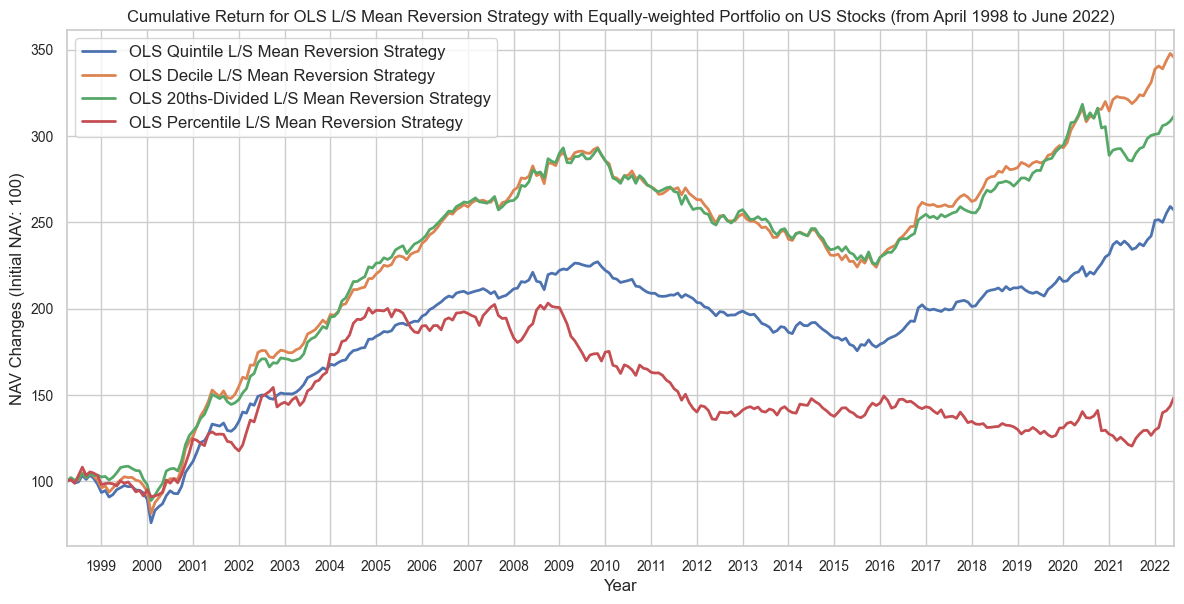

In [13]:
cum_OLS_Q_strategy_return = get_price_df(df_OLS_Quintile_Signal, df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return = get_price_df(df_OLS_Decile_Signal, df_returns, nav=100, model_type=None)
cum_OLS_T_strategy_return = get_price_df(df_OLS_20_Divided_Signal, df_returns, nav=100, model_type=None)
cum_OLS_P_strategy_return = get_price_df(df_OLS_Percentile_Signal, df_returns, nav=100, model_type=None)

cum_OLS_strategy_return = pd.concat([cum_OLS_Q_strategy_return.rename('OLS Quintile L/S Mean Reversion Strategy'),
                                     cum_OLS_D_strategy_return.rename('OLS Decile L/S Mean Reversion Strategy'),
                                     cum_OLS_T_strategy_return.rename('OLS 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_OLS_P_strategy_return.rename('OLS Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_OLS_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for OLS L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from April 1998 to June 2022)', fontsize=12)
plt.show()

In [14]:
# Performance Stats
stats_OLS_Q = get_performance_stats(cum_OLS_Q_strategy_return, rfr=risk_free_rate_df, label='OLS Quintile (Initial NAV: 100)')
stats_OLS_D = get_performance_stats(cum_OLS_D_strategy_return, rfr=risk_free_rate_df, label='OLS Decile (Initial NAV: 100)')
stats_OLS_T = get_performance_stats(cum_OLS_T_strategy_return, rfr=risk_free_rate_df, label='OLS 20ths (Initial NAV: 100)')
stats_OLS_P = get_performance_stats(cum_OLS_P_strategy_return, rfr=risk_free_rate_df, label='OLS Percentile (Initial NAV: 100)')
OLS_stats = pd.concat([stats_OLS_Q, stats_OLS_D, stats_OLS_T, stats_OLS_P], axis=0)
display(OLS_stats)

Total Return  Avg Return   Rf Rate  \
OLS Quintile (Initial NAV: 100)        1.569753    0.039687  0.018682   
OLS Decile (Initial NAV: 100)          2.454319    0.052448  0.018682   
OLS 20ths (Initial NAV: 100)           2.114006    0.047956  0.018682   
OLS Percentile (Initial NAV: 100)      0.486381    0.016478  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
OLS Quintile (Initial NAV: 100)      0.064070      0.327844 -1.192248   
OLS Decile (Initial NAV: 100)        0.065299      0.517086 -0.399121   
OLS 20ths (Initial NAV: 100)         0.059712      0.490246 -0.096700   
OLS Percentile (Initial NAV: 100)    0.078997     -0.027901  0.333537   

                                    Kurtosis         HWM    HWM date  \
OLS Quintile (Initial NAV: 100)    19.417478  259.092453  2022-05-31   
OLS Decile (Initial NAV: 100)      12.497734  347.718923  2022-05-31   
OLS 20ths (Initial NAV: 100)        5.821567  318.267009  2020-06-30   
OLS Percentile (Initial NAV: 100)   1.253495  203.130571  2008-10-31   

                                        MDD   Peak Date Trough Date  \
OLS Quintile (Initial NAV: 100)    0.226965  2009-11-30  2015-07-31   
OLS Decile (Initial NAV: 100)      0.236413  2009-11-30  2015-12-31   
OLS 20ths (Initial NAV: 100)       0.230194  2009-02-28  2015-12-31   
OLS Percentile (Initial NAV: 100)  0.407537  2008-10-31  2021-07-31   

                                   Recession Date    MDD Duration  
OLS Quintile (Initial NAV: 100)        2020-12-31            4049  
OLS Decile (Initial NAV: 100)          2019-12-31            3683  
OLS 20ths (Initial NAV: 100)           2020-01-31            3989  
OLS Percentile (Initial NAV: 100)  Yet to recover  Yet to recover

In [15]:
stats2_OLS_Q = get_performance_stats_2(df_OLS_Quintile_Signal, df_returns, df_market_cap, label='OLS Quintile')
stats2_OLS_D = get_performance_stats_2(df_OLS_Decile_Signal, df_returns, df_market_cap, label='OLS Decile')
stats2_OLS_T = get_performance_stats_2(df_OLS_20_Divided_Signal, df_returns, df_market_cap, label='OLS 20ths')
stats2_OLS_P = get_performance_stats_2(df_OLS_Percentile_Signal, df_returns, df_market_cap, label='OLS Percentile')
OLS_stats2 = pd.concat([stats2_OLS_Q, stats2_OLS_D, stats2_OLS_T, stats2_OLS_P], axis=0)
display(OLS_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
OLS Quintile (Long & Short)        1.569753            0.003249  2.414526e+10   
(Long Position)                  252.160063            0.019199  4.008645e+09   
(Short Position)                  -0.987987           -0.015080  4.301742e+10   
OLS Decile (Long & Short)          2.454319            0.004269  2.848441e+10   
(Long Position)                  616.954315            0.022330  3.197428e+09   
(Short Position)                  -0.991299           -0.016171  5.116239e+10   
OLS 20ths (Long & Short)           2.114006            0.003911  3.022323e+10   
(Long Position)                 1082.445255            0.024304  2.831480e+09   
(Short Position)                  -0.996221           -0.018987  5.322709e+10   
OLS Percentile (Long & Short)      0.486381            0.001363  6.755169e+09   
(Long Position)                  648.844695            0.022506  2.207860e+09   
(Short Position)                  -0.998838           -0.022953  1.036373e+10   

                               Fraction>0  + Return Stocks (Avg)  \
OLS Quintile (Long & Short)      0.589655               0.088443   
(Long Position)                  0.679310               0.088877   
(Short Position)                 0.344828               0.073872   
OLS Decile (Long & Short)        0.620690               0.089126   
(Long Position)                  0.703448               0.089689   
(Short Position)                 0.355172               0.074000   
OLS 20ths (Long & Short)         0.624138               0.089644   
(Long Position)                  0.727586               0.090713   
(Short Position)                 0.331034               0.073576   
OLS Percentile (Long & Short)    0.496552               0.089302   
(Long Position)                  0.675862               0.089394   
(Short Position)                 0.362069               0.073487   

                               - Return Stocks (Avg)  Odds Ratio  \
OLS Quintile (Long & Short)                -0.084851    0.507730   
(Long Position)                            -0.068285    0.563920   
(Short Position)                           -0.087602    0.453250   
OLS Decile (Long & Short)                  -0.084937    0.512453   
(Long Position)                            -0.064551    0.574147   
(Short Position)                           -0.089825    0.453156   
OLS 20ths (Long & Short)                   -0.086998    0.515369   
(Long Position)                            -0.062709    0.584266   
(Short Position)                           -0.093097    0.449376   
OLS Percentile (Long & Short)              -0.090928    0.512237   
(Long Position)                            -0.064378    0.581701   
(Short Position)                           -0.095308    0.444404   

                               Odds Ratio 98-10  Odds Ratio 11-22  \
OLS Quintile (Long & Short)            0.516702          0.499842   
(Long Position)                        0.576472          0.553001   
(Short Position)                       0.459396          0.447790   
OLS Decile (Long & Short)              0.524860          0.501570   
(Long Position)                        0.594294          0.556750   
(Short Position)                       0.459218          0.447757   
OLS 20ths (Long & Short)               0.527438          0.504818   
(Long Position)                        0.607506          0.564419   
(Short Position)                       0.452593          0.446501   
OLS Percentile (Long & Short)          0.524882          0.501197   
(Long Position)                        0.609795          0.557725   
(Short Position)                       0.443934          0.444824   

                               Transactions/Month  
OLS Quintile (Long & Short)            394.696552  
(Long Position)                        208.972414  
(Short Position)                       206.972414  
OLS Decile (Long & Short)              253.589655  
(Long Position)                        134.410345

In [49]:
cum_OLS_Q_strategy_return_L = get_price_df(df_OLS_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_OLS_Q_strategy_return_S = get_price_df(df_OLS_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return_L = get_price_df(df_OLS_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return_S = get_price_df(df_OLS_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_OLS_Q_L = get_performance_stats(cum_OLS_Q_strategy_return_L, rfr=risk_free_rate_df, label='OLS Quintile L (Initial NAV: 100)')
stats_OLS_Q_S = get_performance_stats(cum_OLS_Q_strategy_return_S, rfr=risk_free_rate_df, label='OLS Quintile S (Initial NAV: 100)')
stats_OLS_D_L = get_performance_stats(cum_OLS_D_strategy_return_L, rfr=risk_free_rate_df, label='OLS Decile L (Initial NAV: 100)')
stats_OLS_D_S = get_performance_stats(cum_OLS_D_strategy_return_S, rfr=risk_free_rate_df, label='OLS Decile S (Initial NAV: 100)')
OLS_stats3 = pd.concat([stats_OLS_Q_L, stats_OLS_Q_S, stats_OLS_D_L, stats_OLS_D_S], axis=0)
display(OLS_stats3)

Total Return  Avg Return   Rf Rate  \
OLS Quintile L (Initial NAV: 100)    252.160063    0.256345  0.018682   
OLS Quintile S (Initial NAV: 100)     31.105965    0.153791  0.018682   
OLS Decile L (Initial NAV: 100)      616.954315    0.303440  0.018682   
OLS Decile S (Initial NAV: 100)       43.043421    0.168931  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
OLS Quintile L (Initial NAV: 100)    0.169670      1.400739  0.144182   
OLS Quintile S (Initial NAV: 100)    0.192377      0.702311 -0.042414   
OLS Decile L (Initial NAV: 100)      0.171812      1.657374  0.233255   
OLS Decile S (Initial NAV: 100)      0.192210      0.781691 -0.209238   

                                   Kurtosis           HWM    HWM date  \
OLS Quintile L (Initial NAV: 100)  0.668091  28715.797987  2022-03-31   
OLS Quintile S (Initial NAV: 100)  2.443749   4269.985998  2021-10-31   
OLS Decile L (Initial NAV: 100)    0.922881  70949.242297  2022-03-31   
OLS Decile S (Initial NAV: 100)    1.847218   5445.832565  2021-10-31   

                                        MDD   Peak Date Trough Date  \
OLS Quintile L (Initial NAV: 100)  0.118394  2022-03-31  2022-06-30   
OLS Quintile S (Initial NAV: 100)  0.248101  2021-10-31  2022-06-30   
OLS Decile L (Initial NAV: 100)    0.129019  2022-03-31  2022-06-30   
OLS Decile S (Initial NAV: 100)    0.191245  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
OLS Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
OLS Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
OLS Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
OLS Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Feature Importance

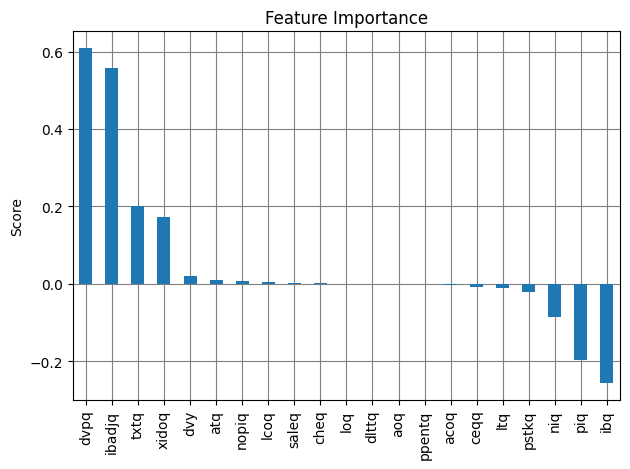

In [245]:
OLS_importances = OLS_model.coef_
OLS_importances_1 = pd.Series(OLS_importances, index=feature_names).sort_values(ascending=False)
ols_f = OLS_importances_1 / OLS_importances_1.sum()

fig, ax1 = plt.subplots()
ols_f.plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance')
ax1.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 2. Random Forest Model for Fair Value Estimation

In [17]:
# Baseline RF model
RF_model = RandomForestRegressor(n_estimators=350, max_depth=2, max_features=4, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=6, random_state=random_state)
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
raw_1['datadate'] = raw_1['datadate'].astype('str')
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]
df_RF_Quintile_Signal = pd.DataFrame(index=list_company)
df_RF_Decile_Signal = pd.DataFrame(index=list_company)
df_RF_20_Divided_Signal = pd.DataFrame(index=list_company)
df_RF_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_train = X[X.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]

    X_test = X[X.datadate == test_date]
    X_test = X_test.iloc[:, 2:]

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]

    RF_fit = RF_model.fit(X_train, y_train)
    y_fair = RF_fit.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_RF_Quintile_Signal = df_RF_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_RF_Decile_Signal = df_RF_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_RF_Percentile_Signal = df_RF_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [18]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_RF_Quintile_Signal = pd.concat([df_199804_199809, df_RF_Quintile_Signal, df_202206], axis=1)
df_RF_Quintile_Signal = df_RF_Quintile_Signal.fillna(0).T
df_RF_Quintile_Signal = df_RF_Quintile_Signal.shift(1).dropna()

df_RF_Decile_Signal = pd.concat([df_199804_199809, df_RF_Decile_Signal, df_202206], axis=1)
df_RF_Decile_Signal = df_RF_Decile_Signal.fillna(0).T
df_RF_Decile_Signal = df_RF_Decile_Signal.shift(1).dropna()

df_RF_20_Divided_Signal = pd.concat([df_199804_199809, df_RF_20_Divided_Signal, df_202206], axis=1)
df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.fillna(0).T
df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.shift(1).dropna()

df_RF_Percentile_Signal = pd.concat([df_199804_199809, df_RF_Percentile_Signal, df_202206], axis=1)
df_RF_Percentile_Signal = df_RF_Percentile_Signal.fillna(0).T
df_RF_Percentile_Signal = df_RF_Percentile_Signal.shift(1).dropna()

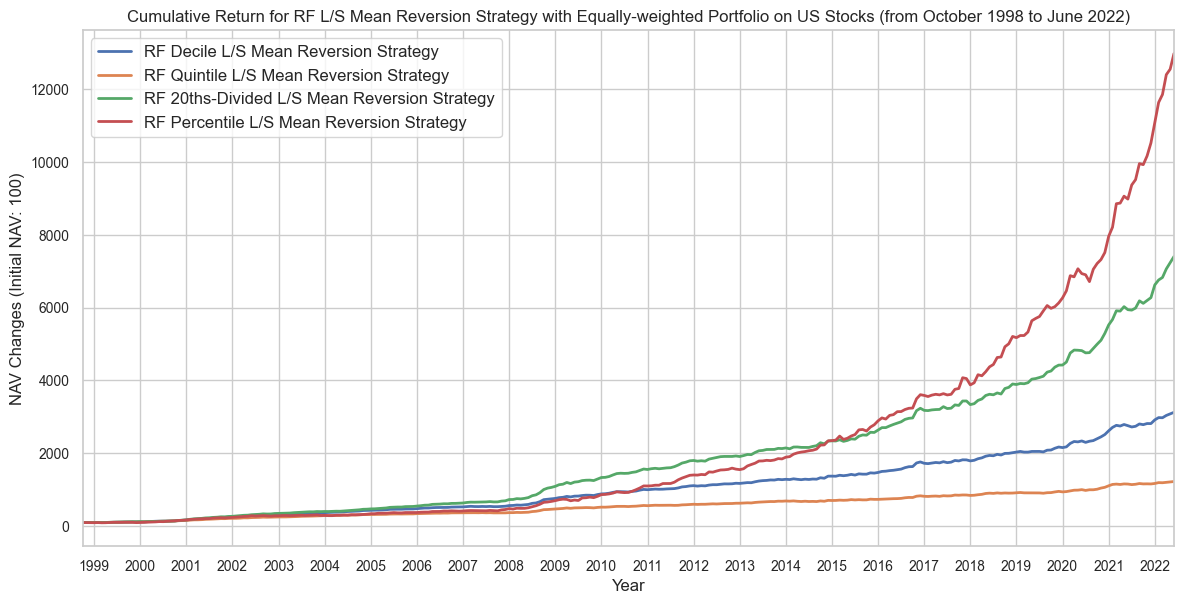

In [19]:
cum_RF_Q_strategy_return = get_price_df(df_RF_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_RF_D_strategy_return = get_price_df(df_RF_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_RF_T_strategy_return = get_price_df(df_RF_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_RF_P_strategy_return = get_price_df(df_RF_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_RF_strategy_return = pd.concat([cum_RF_D_strategy_return.rename('RF Decile L/S Mean Reversion Strategy'),
                                    cum_RF_Q_strategy_return.rename('RF Quintile L/S Mean Reversion Strategy'),
                                    cum_RF_T_strategy_return.rename('RF 20ths-Divided L/S Mean Reversion Strategy'),
                                    cum_RF_P_strategy_return.rename('RF Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_RF_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for RF L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [20]:
# Performance Stats
stats_RF_Q = get_performance_stats(cum_RF_Q_strategy_return, rfr=risk_free_rate_df, label='RF Quintile (Initial NAV: 100)')
stats_RF_D = get_performance_stats(cum_RF_D_strategy_return, rfr=risk_free_rate_df, label='RF Decile (Initial NAV: 100)')
stats_RF_T = get_performance_stats(cum_RF_T_strategy_return, rfr=risk_free_rate_df, label='RF 20ths (Initial NAV: 100)')
stats_RF_P = get_performance_stats(cum_RF_P_strategy_return, rfr=risk_free_rate_df, label='RF Percentile (Initial NAV: 100)')
RF_stats = pd.concat([stats_RF_Q, stats_RF_D, stats_RF_T, stats_RF_P], axis=0)
display(RF_stats)

Total Return  Avg Return   Rf Rate  \
RF Quintile (Initial NAV: 100)       11.252236    0.111270  0.018682   
RF Decile (Initial NAV: 100)         30.244258    0.155946  0.018682   
RF 20ths (Initial NAV: 100)          73.017932    0.198696  0.018682   
RF Percentile (Initial NAV: 100)    128.742045    0.227360  0.018682   

                                  Volatility  Sharpe Ratio  Skewness  \
RF Quintile (Initial NAV: 100)      0.047048      1.967934  0.716797   
RF Decile (Initial NAV: 100)        0.055447      2.475584  0.984646   
RF 20ths (Initial NAV: 100)         0.066709      2.698478  0.842081   
RF Percentile (Initial NAV: 100)    0.091623      2.277567  0.061671   

                                  Kurtosis           HWM    HWM date  \
RF Quintile (Initial NAV: 100)    0.960605   1225.223567  2022-06-30   
RF Decile (Initial NAV: 100)      1.989696   3124.425833  2022-06-30   
RF 20ths (Initial NAV: 100)       2.527196   7401.793210  2022-06-30   
RF Percentile (Initial NAV: 100)  0.657140  12974.204476  2022-06-30   

                                       MDD   Peak Date Trough Date  \
RF Quintile (Initial NAV: 100)    0.020860  2020-06-30  2020-07-31   
RF Decile (Initial NAV: 100)      0.024444  2021-05-31  2021-07-31   
RF 20ths (Initial NAV: 100)       0.028851  2017-12-31  2018-01-31   
RF Percentile (Initial NAV: 100)  0.049916  2020-05-31  2020-08-31   

                                 Recession Date  MDD Duration  
RF Quintile (Initial NAV: 100)       2020-10-31           123  
RF Decile (Initial NAV: 100)         2021-09-30           122  
RF 20ths (Initial NAV: 100)          2018-03-31            90  
RF Percentile (Initial NAV: 100)     2020-10-31           153

In [21]:
stats2_RF_Q = get_performance_stats_2(df_RF_Quintile_Signal, df_returns, df_market_cap, label='RF Quintile', model_type='ML')
stats2_RF_D = get_performance_stats_2(df_RF_Decile_Signal, df_returns, df_market_cap, label='RF Decile', model_type='ML')
stats2_RF_T = get_performance_stats_2(df_RF_20_Divided_Signal, df_returns, df_market_cap, label='RF 20ths', model_type='ML')
stats2_RF_P = get_performance_stats_2(df_RF_Percentile_Signal, df_returns, df_market_cap, label='RF Percentile', model_type='ML')
RF_stats2 = pd.concat([stats2_RF_Q, stats2_RF_D, stats2_RF_T, stats2_RF_P], axis=0)
display(RF_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
RF Quintile (Long & Short)        11.252236            0.008831  3.688582e+10   
(Long Position)                 1204.797880            0.025207  6.247204e+08   
(Short Position)                  -0.935349           -0.009564  7.031321e+10   
RF Decile (Long & Short)          30.244258            0.012150  6.208299e+10   
(Long Position)                 8379.901362            0.032205  5.379736e+08   
(Short Position)                  -0.938749           -0.009751  1.160745e+11   
RF 20ths (Long & Short)           73.017932            0.015217  1.040810e+11   
(Long Position)                50266.556444            0.038713  5.348494e+08   
(Short Position)                  -0.944764           -0.010110  1.898131e+11   
RF Percentile (Long & Short)     128.742045            0.017219  3.020776e+11   
(Long Position)               339376.455020            0.045697  7.725731e+08   
(Short Position)                  -0.979155           -0.013489  5.251660e+11   

                              Fraction>0  + Return Stocks (Avg)  \
RF Quintile (Long & Short)      0.731034               0.090477   
(Long Position)                 0.706897               0.102489   
(Short Position)                0.382759               0.062939   
RF Decile (Long & Short)        0.762069               0.090811   
(Long Position)                 0.748276               0.103559   
(Short Position)                0.379310               0.062361   
RF 20ths (Long & Short)         0.796552               0.091657   
(Long Position)                 0.834483               0.103248   
(Short Position)                0.382759               0.064055   
RF Percentile (Long & Short)    0.741379               0.093552   
(Long Position)                 0.882759               0.102130   
(Short Position)                0.382759               0.067384   

                              - Return Stocks (Avg)  Odds Ratio  \
RF Quintile (Long & Short)                -0.075939    0.507497   
(Long Position)                           -0.073133    0.569532   
(Short Position)                          -0.069032    0.450596   
RF Decile (Long & Short)                  -0.072009    0.519891   
(Long Position)                           -0.065121    0.596164   
(Short Position)                          -0.068729    0.453448   
RF 20ths (Long & Short)                   -0.069669    0.536930   
(Long Position)                           -0.055444    0.634860   
(Short Position)                          -0.070930    0.456903   
RF Percentile (Long & Short)              -0.075550    0.580099   
(Long Position)                           -0.044000    0.747206   
(Short Position)                          -0.079821    0.462266   

                              Odds Ratio 98-10  Odds Ratio 11-22  \
RF Quintile (Long & Short)            0.523216          0.494267   
(Long Position)                       0.590882          0.551840   
(Short Position)                      0.462146          0.440734   
RF Decile (Long & Short)              0.540890          0.502375   
(Long Position)                       0.629704          0.568914   
(Short Position)                      0.465573          0.443098   
RF 20ths (Long & Short)               0.559545          0.518074   
(Long Position)                       0.674220          0.602963   
(Short Position)                      0.468439          0.447060   
RF Percentile (Long & Short)          0.570994          0.588270   
(Long Position)                       0.720625          0.772994   
(Short Position)                      0.457873          0.465997   

                              Transactions/Month  
RF Quintile (Long & Short)            213.262069  
(Long Position)                       137.737931  
(Short Position)                       75.793103  
RF Decile (Long & Short)              163.975862  
(Long Position)                       109.437931  
(Short Position)                       54.

In [50]:
cum_RF_Q_strategy_return_L = get_price_df(df_RF_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_RF_Q_strategy_return_S = get_price_df(df_RF_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_RF_D_strategy_return_L = get_price_df(df_RF_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_RF_D_strategy_return_S = get_price_df(df_RF_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_RF_Q_L = get_performance_stats(cum_RF_Q_strategy_return_L, rfr=risk_free_rate_df, label='RF Quintile L (Initial NAV: 100)')
stats_RF_Q_S = get_performance_stats(cum_RF_Q_strategy_return_S, rfr=risk_free_rate_df, label='RF Quintile S (Initial NAV: 100)')
stats_RF_D_L = get_performance_stats(cum_RF_D_strategy_return_L, rfr=risk_free_rate_df, label='RF Decile L (Initial NAV: 100)')
stats_RF_D_S = get_performance_stats(cum_RF_D_strategy_return_S, rfr=risk_free_rate_df, label='RF Decile S (Initial NAV: 100)')
RF_stats3 = pd.concat([stats_RF_Q_L, stats_RF_Q_S, stats_RF_D_L, stats_RF_D_S], axis=0)
display(RF_stats3)

Total Return  Avg Return   Rf Rate  \
RF Quintile L (Initial NAV: 100)   1204.797880    0.348149  0.018682   
RF Quintile S (Initial NAV: 100)      6.949611    0.091212  0.018682   
RF Decile L (Initial NAV: 100)     8379.901362    0.462821  0.018682   
RF Decile S (Initial NAV: 100)        7.024074    0.091641  0.018682   

                                  Volatility  Sharpe Ratio  Skewness  \
RF Quintile L (Initial NAV: 100)    0.164392      2.004149  0.244120   
RF Quintile S (Initial NAV: 100)    0.165032      0.439490 -0.527994   
RF Decile L (Initial NAV: 100)      0.150825      2.944721  0.494051   
RF Decile S (Initial NAV: 100)      0.170520      0.427859 -0.405262   

                                  Kurtosis            HWM    HWM date  \
RF Quintile L (Initial NAV: 100)  0.344610  137572.231823  2021-10-31   
RF Quintile S (Initial NAV: 100)  1.224726    1017.725332  2021-10-31   
RF Decile L (Initial NAV: 100)    0.477331  898808.527952  2022-03-31   
RF Decile S (Initial NAV: 100)    1.558873    1080.982467  2021-08-31   

                                       MDD   Peak Date Trough Date  \
RF Quintile L (Initial NAV: 100)  0.123517  2021-10-31  2022-06-30   
RF Quintile S (Initial NAV: 100)  0.218884  2021-10-31  2022-06-30   
RF Decile L (Initial NAV: 100)    0.067554  2022-03-31  2022-06-30   
RF Decile S (Initial NAV: 100)    0.257705  2021-08-31  2022-06-30   

                                  Recession Date    MDD Duration  
RF Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
RF Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
RF Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
RF Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [ ]:
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]

validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
X_validation = X[X.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]

RF_param_grid =  {'n_estimators': [300, 350],
                   'min_samples_split': [4, 5, 6],
                   'min_samples_leaf': [1, 2],
                   'max_leaf_nodes': [3, 4, 5],
                   'max_features':[4, 5],
                   'max_depth':[2]}

RF_model = RandomForestRegressor(random_state=random_state)
grid_mse = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_mse.fit(X_validation, y_validation)

In [ ]:
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [ ]:
"""
{'max_depth': 2, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 350}
"""

### (3) Feature Importance

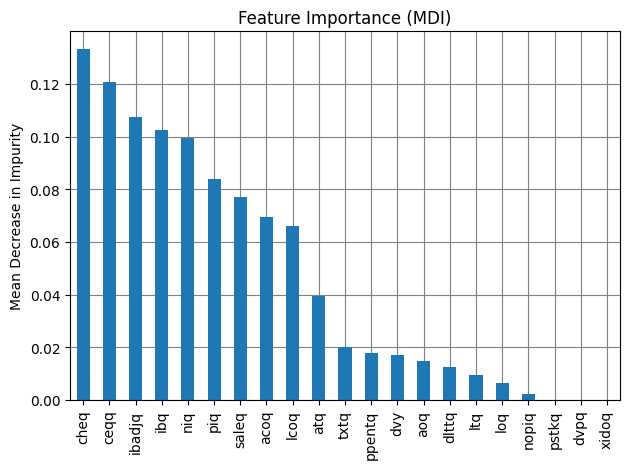

In [256]:
RF_importances = RF_model.feature_importances_
RF_importances_1 = pd.Series(RF_importances, index=feature_names).sort_values(ascending=False)

fig, ax1 = plt.subplots()
RF_importances_1.plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance (MDI)')
ax1.set_ylabel('Mean Decrease in Impurity')
fig.tight_layout()
plt.show()

## 3. XGBoost Model for Fair Value Estimation

In [23]:
# Baseline XGBoost model
XGB_model = xgb.XGBRegressor(alpha=0, gamma=0, colsample_bytree=0.6, reg_lambda=0.2, subsample=0.5, n_estimators=50, eta=0.02, max_depth=5, seed=random_state)
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
raw_1['datadate'] = raw_1['datadate'].astype('str')
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]
df_XGB_Quintile_Signal = pd.DataFrame(index=list_company)
df_XGB_Decile_Signal = pd.DataFrame(index=list_company)
df_XGB_20_Divided_Signal = pd.DataFrame(index=list_company)
df_XGB_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_train = X[X.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]

    X_test = X[X.datadate == test_date]
    X_test = X_test.iloc[:, 2:]

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]

    XGB_fit = XGB_model.fit(X_train, y_train)
    y_fair = XGB_fit.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_XGB_Quintile_Signal = df_XGB_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_XGB_Decile_Signal = df_XGB_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_XGB_20_Divided_Signal = df_XGB_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_XGB_Percentile_Signal = df_XGB_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [24]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_XGB_Quintile_Signal = pd.concat([df_199804_199809, df_XGB_Quintile_Signal, df_202206], axis=1)
df_XGB_Quintile_Signal = df_XGB_Quintile_Signal.fillna(0).T
df_XGB_Quintile_Signal = df_XGB_Quintile_Signal.shift(1).dropna()

df_XGB_Decile_Signal = pd.concat([df_199804_199809, df_XGB_Decile_Signal, df_202206], axis=1)
df_XGB_Decile_Signal = df_XGB_Decile_Signal.fillna(0).T
df_XGB_Decile_Signal = df_XGB_Decile_Signal.shift(1).dropna()

df_XGB_20_Divided_Signal = pd.concat([df_199804_199809, df_XGB_20_Divided_Signal, df_202206], axis=1)
df_XGB_20_Divided_Signal = df_XGB_20_Divided_Signal.fillna(0).T
df_XGB_20_Divided_Signal = df_XGB_20_Divided_Signal.shift(1).dropna()

df_XGB_Percentile_Signal = pd.concat([df_199804_199809, df_XGB_Percentile_Signal, df_202206], axis=1)
df_XGB_Percentile_Signal = df_XGB_Percentile_Signal.fillna(0).T
df_XGB_Percentile_Signal = df_XGB_Percentile_Signal.shift(1).dropna()

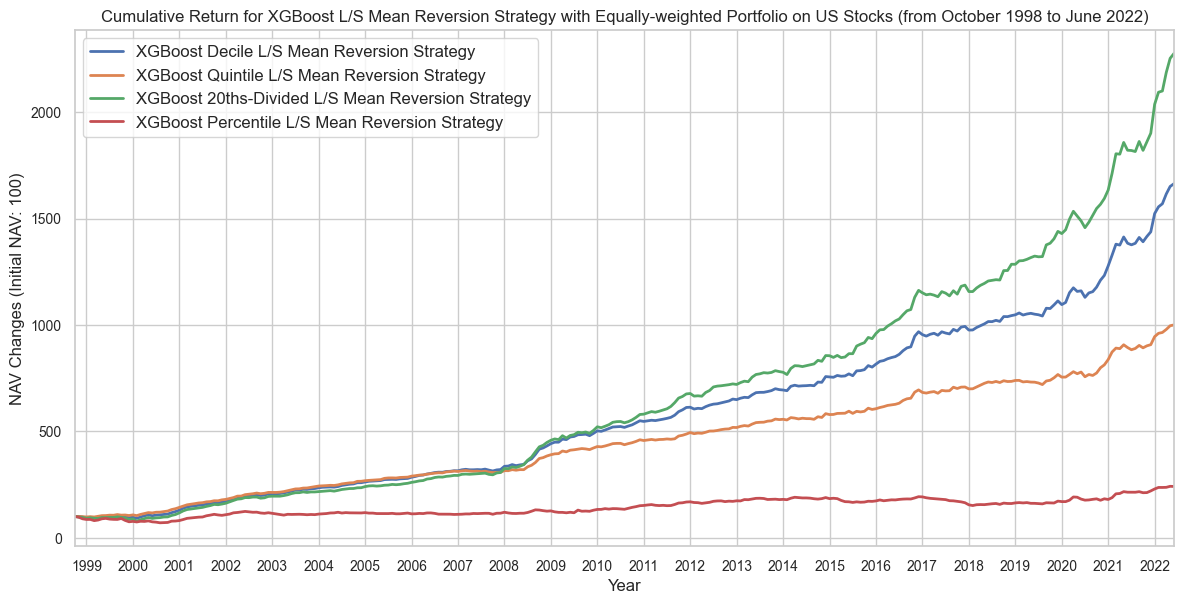

In [25]:
cum_XGB_Q_strategy_return = get_price_df(df_XGB_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_XGB_D_strategy_return = get_price_df(df_XGB_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_XGB_T_strategy_return = get_price_df(df_XGB_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_XGB_P_strategy_return = get_price_df(df_XGB_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_XGB_strategy_return = pd.concat([cum_XGB_D_strategy_return.rename('XGBoost Decile L/S Mean Reversion Strategy'),
                                     cum_XGB_Q_strategy_return.rename('XGBoost Quintile L/S Mean Reversion Strategy'),
                                     cum_XGB_T_strategy_return.rename('XGBoost 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_XGB_P_strategy_return.rename('XGBoost Percentile L/S Mean Reversion Strategy')], axis=1)


ax = cum_XGB_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for XGBoost L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [26]:
# Performance Stats
stats_XGB_Q = get_performance_stats(cum_XGB_Q_strategy_return, rfr=risk_free_rate_df, label='XGBoost Quintile (Initial NAV: 100)')
stats_XGB_D = get_performance_stats(cum_XGB_D_strategy_return, rfr=risk_free_rate_df, label='XGBoost Decile (Initial NAV: 100)')
stats_XGB_T = get_performance_stats(cum_XGB_T_strategy_return, rfr=risk_free_rate_df, label='XGBoost 20ths (Initial NAV: 100)')
stats_XGB_P = get_performance_stats(cum_XGB_P_strategy_return, rfr=risk_free_rate_df, label='XGBoost Percentile (Initial NAV: 100)')
XGB_stats = pd.concat([stats_XGB_Q, stats_XGB_D, stats_XGB_T, stats_XGB_P], axis=0)
display(XGB_stats)

Total Return  Avg Return   Rf Rate  \
XGBoost Quintile (Initial NAV: 100)        9.003108    0.101821  0.018682   
XGBoost Decile (Initial NAV: 100)         15.639149    0.125683  0.018682   
XGBoost 20ths (Initial NAV: 100)          21.756693    0.140621  0.018682   
XGBoost Percentile (Initial NAV: 100)      1.411523    0.037759  0.018682   

                                       Volatility  Sharpe Ratio  Skewness  \
XGBoost Quintile (Initial NAV: 100)      0.048269      1.722397  0.545194   
XGBoost Decile (Initial NAV: 100)        0.060705      1.762636  0.384349   
XGBoost 20ths (Initial NAV: 100)         0.075617      1.612578 -0.397543   
XGBoost Percentile (Initial NAV: 100)    0.092143      0.207031  0.177735   

                                       Kurtosis          HWM    HWM date  \
XGBoost Quintile (Initial NAV: 100)    1.023506  1000.310755  2022-06-30   
XGBoost Decile (Initial NAV: 100)      2.176764  1663.914852  2022-06-30   
XGBoost 20ths (Initial NAV: 100)       5.998801  2275.669348  2022-06-30   
XGBoost Percentile (Initial NAV: 100)  2.119437   241.832646  2022-05-31   

                                            MDD   Peak Date Trough Date  \
XGBoost Quintile (Initial NAV: 100)    0.030351  2020-04-30  2020-07-31   
XGBoost Decile (Initial NAV: 100)      0.038098  2020-04-30  2020-07-31   
XGBoost 20ths (Initial NAV: 100)       0.050155  2020-04-30  2020-07-31   
XGBoost Percentile (Initial NAV: 100)  0.215114  2016-12-31  2018-02-28   

                                      Recession Date  MDD Duration  
XGBoost Quintile (Initial NAV: 100)       2020-11-30           214  
XGBoost Decile (Initial NAV: 100)         2020-10-31           184  
XGBoost 20ths (Initial NAV: 100)          2020-10-31           184  
XGBoost Percentile (Initial NAV: 100)     2021-03-31          1551

In [27]:
stats2_XGB_Q = get_performance_stats_2(df_XGB_Quintile_Signal, df_returns, df_market_cap, label='XGBoost Quintile', model_type='ML')
stats2_XGB_D = get_performance_stats_2(df_XGB_Decile_Signal, df_returns, df_market_cap, label='XGBoost Decile', model_type='ML')
stats2_XGB_T = get_performance_stats_2(df_XGB_20_Divided_Signal, df_returns, df_market_cap, label='XGBoost 20ths', model_type='ML')
stats2_XGB_P = get_performance_stats_2(df_XGB_Percentile_Signal, df_returns, df_market_cap, label='XGBoost Percentile', model_type='ML')
XGB_stats2 = pd.concat([stats2_XGB_Q, stats2_XGB_D, stats2_XGB_T, stats2_XGB_P], axis=0)
display(XGB_stats2)

Total Return  Avg Monthly Return  \
XGBoost Quintile (Long & Short)        9.003108            0.008113   
(Long Position)                     1003.235247            0.024549   
(Short Position)                      -0.950138           -0.010466   
XGBoost Decile (Long & Short)         15.639149            0.009915   
(Long Position)                     4019.861626            0.029548   
(Short Position)                      -0.966641           -0.011860   
XGBoost 20ths (Long & Short)          21.756693            0.011025   
(Long Position)                     8354.958055            0.032194   
(Short Position)                      -0.972060           -0.012475   
XGBoost Percentile (Long & Short)      1.411523            0.003093   
(Long Position)                      509.001219            0.022116   
(Short Position)                      -0.995945           -0.019140   

                                    Avg Mkt Cap  Fraction>0  \
XGBoost Quintile (Long & Short)    3.117680e+10    0.737931   
(Long Position)                    1.761964e+09    0.710345   
(Short Position)                   5.845532e+10    0.382759   
XGBoost Decile (Long & Short)      3.922592e+10    0.744828   
(Long Position)                    1.800703e+09    0.720690   
(Short Position)                   7.292211e+10    0.375862   
XGBoost 20ths (Long & Short)       5.384777e+10    0.731034   
(Long Position)                    2.245823e+09    0.765517   
(Short Position)                   9.886923e+10    0.389655   
XGBoost Percentile (Long & Short)  1.005431e+11    0.524138   
(Long Position)                    4.365603e+09    0.675862   
(Short Position)                   1.906114e+11    0.358621   

                                   + Return Stocks (Avg)  \
XGBoost Quintile (Long & Short)                 0.091743   
(Long Position)                                 0.099769   
(Short Position)                                0.068469   
XGBoost Decile (Long & Short)                   0.093121   
(Long Position)                                 0.100335   
(Short Position)                                0.070813   
XGBoost 20ths (Long & Short)                    0.094005   
(Long Position)                                 0.098567   
(Short Position)                                0.074308   
XGBoost Percentile (Long & Short)               0.094825   
(Long Position)                                 0.097327   
(Short Position)                                0.075930   

                                   - Return Stocks (Avg)  Odds Ratio  \
XGBoost Quintile (Long & Short)                -0.078861    0.509325   
(Long Position)                                -0.071552    0.570574   
(Short Position)                               -0.075110    0.452828   
XGBoost Decile (Long & Short)                  -0.078781    0.519640   
(Long Position)                                -0.066100    0.592023   
(Short Position)                               -0.078981    0.455214   
XGBoost 20ths (Long & Short)                   -0.080429    0.531162   
(Long Position)                                -0.062077    0.614808   
(Short Position)                               -0.083887    0.459425   
XGBoost Percentile (Long & Short)              -0.092039    0.515283   
(Long Position)                                -0.071660    0.580745   
(Short Position)                               -0.094725    0.455538   

                                   Odds Ratio 98-10  Odds Ratio 11-22  \
XGBoost Quintile (Long & Short)            0.522229          0.498434   
(Long Position)                            0.590389          0.554066   
(Short Position)                           0.460202          0.446530   
XGBoost Decile (Long & Short)              0.532398          0.508842   
(Long Position)                            0.615337          0.572484   
(Short Position)                           0.459328          0.451700   
XGBoost 20ths (Long & Short)               0.543713          0

In [51]:
cum_XGB_Q_strategy_return_L = get_price_df(df_XGB_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_XGB_Q_strategy_return_S = get_price_df(df_XGB_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_XGB_D_strategy_return_L = get_price_df(df_XGB_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_XGB_D_strategy_return_S = get_price_df(df_XGB_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_XGB_Q_L = get_performance_stats(cum_XGB_Q_strategy_return_L, rfr=risk_free_rate_df, label='XGB Quintile L (Initial NAV: 100)')
stats_XGB_Q_S = get_performance_stats(cum_XGB_Q_strategy_return_S, rfr=risk_free_rate_df, label='XGB Quintile S (Initial NAV: 100)')
stats_XGB_D_L = get_performance_stats(cum_XGB_D_strategy_return_L, rfr=risk_free_rate_df, label='XGB Decile L (Initial NAV: 100)')
stats_XGB_D_S = get_performance_stats(cum_XGB_D_strategy_return_S, rfr=risk_free_rate_df, label='XGB Decile S (Initial NAV: 100)')
XGB_stats3 = pd.concat([stats_XGB_Q_L, stats_XGB_Q_S, stats_XGB_D_L, stats_XGB_D_S], axis=0)
display(XGB_stats3)

Total Return  Avg Return   Rf Rate  \
XGB Quintile L (Initial NAV: 100)   1003.235247    0.337806  0.018682   
XGB Quintile S (Initial NAV: 100)      8.498533    0.099422  0.018682   
XGB Decile L (Initial NAV: 100)     4019.861626    0.418276  0.018682   
XGB Decile S (Initial NAV: 100)       11.285069    0.111395  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
XGB Quintile L (Initial NAV: 100)    0.163208      1.955321  0.196443   
XGB Quintile S (Initial NAV: 100)    0.174640      0.462321 -0.238262   
XGB Decile L (Initial NAV: 100)      0.152521      2.619926  0.421656   
XGB Decile S (Initial NAV: 100)      0.190410      0.486912 -0.015622   

                                   Kurtosis            HWM    HWM date  \
XGB Quintile L (Initial NAV: 100)  0.498726  111744.021330  2022-03-31   
XGB Quintile S (Initial NAV: 100)  1.229733    1335.350508  2021-10-31   
XGB Decile L (Initial NAV: 100)    0.650995  430296.509285  2022-03-31   
XGB Decile S (Initial NAV: 100)    1.763066    1808.343830  2021-10-31   

                                        MDD   Peak Date Trough Date  \
XGB Quintile L (Initial NAV: 100)  0.101307  2022-03-31  2022-06-30   
XGB Quintile S (Initial NAV: 100)  0.288686  2021-10-31  2022-06-30   
XGB Decile L (Initial NAV: 100)    0.065560  2022-03-31  2022-06-30   
XGB Decile S (Initial NAV: 100)    0.320645  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
XGB Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
XGB Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
XGB Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
XGB Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [ ]:
raw_1['datadate'] = raw_1['datadate'].astype('str')
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]

validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
X_validation = X[X.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]

gbm_param_grid =  {'eta': [0.01, 0.02, 0.03],
                   'n_estimators': [50, 100, 150],
                   'subsample': [0.2, 0.3, 0.4, 0.5, 0.6],
                   'reg_lambda': [0.1, 0.2, 0.3],
                   'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                   'alpha': [0, 0.1],
                   'gamma': [0, 0.1],
                   'max_depth':[5, 6, 7, 8, 9]}

gbm = xgb.XGBRegressor()
XGB_grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
XGB_grid_mse.fit(X_validation, y_validation)

In [ ]:
print("Best parameters found: ", XGB_grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(XGB_grid_mse.best_score_)))

In [50]:
raw_1['datadate'] = raw_1['datadate'].astype('str')
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]

validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
X_validation = X[X.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]

space={'max_depth': hp.quniform('max_depth', 3, 10, 1),
       'eta': hp.uniform('eta', 0, 0.03),
       'gamma': hp.uniform('gamma', 0, 9),
       'alpha': hp.uniform('alpha', 0, 1),
       'reg_lambda': hp.uniform('reg_lambda', 0, 1),
       'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
       'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200]),
       'subsample': hp.uniform('subsample', 0.5, 1),
       'seed': random_state}

In [54]:
def objective(space):
    gbm = xgb.XGBRegressor(n_estimators=space['n_estimators'],
                           max_depth=int(space['max_depth']),
                           eta=space['eta'],
                           gamma=space['gamma'],
                           alpha=space['alpha'],
                           colsample_bytree=int(space['colsample_bytree']),
                           subsample=space['subsample'],
                           seed=space['seed'])

    gbm.fit(X_validation, y_validation, verbose=False)

    pred = gbm.predict(X_validation)
    mse = mean_squared_error(y_validation, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=3000, trials=trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
"""
{'alpha': 0, 'colsample_bytree': 0.6, 'eta': 0.02, 'gamma': 0, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 0.2, 'subsample': 0.5}
"""

### (3) Feature Importance

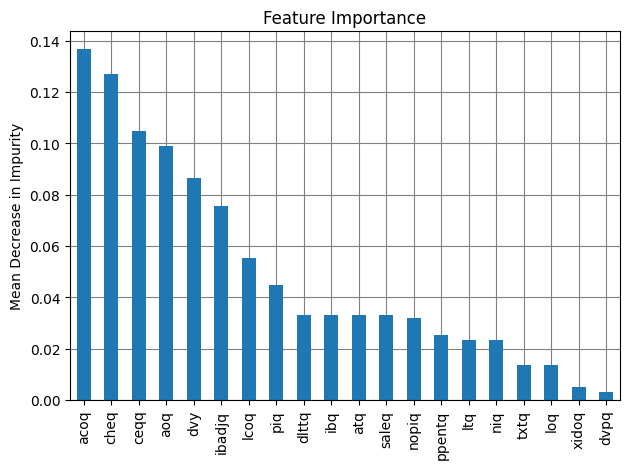

In [257]:
XGB_importances = XGB_model.get_booster().get_score(importance_type='weight')
keys = list(XGB_importances.keys())
values = list(XGB_importances.values())

XGB_importances_1 = pd.Series(values, index=keys).sort_values(ascending=False)
xgb_f = XGB_importances_1 / XGB_importances_1.sum()

fig, ax1 = plt.subplots()
xgb_f.plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance')
ax1.set_ylabel('Mean Decrease in Impurity')
fig.tight_layout()
plt.show()

2

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN2_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN2_Decile_Signal = pd.DataFrame(index=list_company)
df_NN2_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN2_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN2 model
    model_nn2 = Sequential()
    model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
    model_nn2.add(Dropout(0.1))
    model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
    model_nn2.add(Dropout(0.2))
    model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
    model_nn2.add(Dropout(0.3))
    model_nn2.add(Dense(1, activation='linear')) # Output layer
    model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn2.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn2.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN2_Decile_Signal = df_NN2_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

Epoch 1/50
324/324 [==============================] - 0s 813us/step - loss: 13200183.0000 - mae: 500.8539
Epoch 2/50
324/324 [==============================] - 0s 843us/step - loss: 11437616.0000 - mae: 420.7491
Epoch 3/50
324/324 [==============================] - 0s 901us/step - loss: 11992695.0000 - mae: 439.7749
Epoch 4/50
324/324 [==============================] - 0s 803us/step - loss: 11449628.0000 - mae: 449.6262
Epoch 5/50
324/324 [==============================] - 0s 849us/step - loss: 11460140.0000 - mae: 447.5698
Epoch 6/50
324/324 [==============================] - 0s 855us/step - loss: 11165698.0000 - mae: 439.2192
Epoch 7/50
324/324 [==============================] - 0s 911us/step - loss: 11539999.0000 - mae: 450.8069
Epoch 8/50
324/324 [==============================] - 0s 781us/step - loss: 11386639.0000 - mae: 450.9096
Epoch 9/50
324/324 [==============================] - 0s 843us/step - loss: 11115369.0000 - mae: 438.6375
Epoch 10/50
324/324 [=========================

### (1) Performance Analysis

In [30]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN2_Quintile_Signal = pd.concat([df_199804_199809, df_NN2_Quintile_Signal, df_202206], axis=1)
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.fillna(0).T
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.shift(1).dropna()

df_NN2_Decile_Signal = pd.concat([df_199804_199809, df_NN2_Decile_Signal, df_202206], axis=1)
df_NN2_Decile_Signal = df_NN2_Decile_Signal.fillna(0).T
df_NN2_Decile_Signal = df_NN2_Decile_Signal.shift(1).dropna()

df_NN2_20_Divided_Signal = pd.concat([df_199804_199809, df_NN2_20_Divided_Signal, df_202206], axis=1)
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.fillna(0).T
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.shift(1).dropna()

df_NN2_Percentile_Signal = pd.concat([df_199804_199809, df_NN2_Percentile_Signal, df_202206], axis=1)
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.fillna(0).T
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.shift(1).dropna()

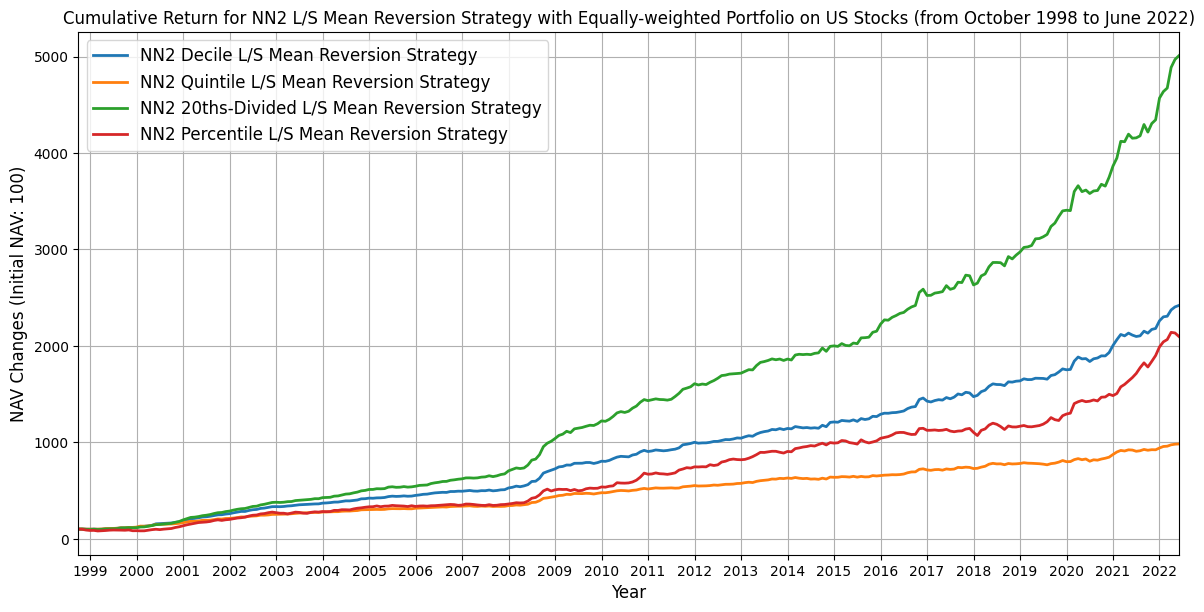

In [187]:
cum_NN2_Q_strategy_return = get_price_df(df_NN2_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_D_strategy_return = get_price_df(df_NN2_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_T_strategy_return = get_price_df(df_NN2_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_P_strategy_return = get_price_df(df_NN2_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN2_strategy_return = pd.concat([cum_NN2_D_strategy_return.rename('NN2 Decile L/S Mean Reversion Strategy'),
                                     cum_NN2_Q_strategy_return.rename('NN2 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN2_T_strategy_return.rename('NN2 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN2_P_strategy_return.rename('NN2 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN2_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN2 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [224]:
# Performance Stats
stats_NN2_Q = get_performance_stats(cum_NN2_Q_strategy_return, rfr=risk_free_rate_df, label='NN2 Quintile (Initial NAV: 100)')
stats_NN2_D = get_performance_stats(cum_NN2_D_strategy_return, rfr=risk_free_rate_df, label='NN2 Decile (Initial NAV: 100)')
stats_NN2_T = get_performance_stats(cum_NN2_T_strategy_return, rfr=risk_free_rate_df, label='NN2 20ths (Initial NAV: 100)')
stats_NN2_P = get_performance_stats(cum_NN2_P_strategy_return, rfr=risk_free_rate_df, label='NN2 Percentile (Initial NAV: 100)')
NN2_stats = pd.concat([stats_NN2_Q, stats_NN2_D, stats_NN2_T, stats_NN2_P], axis=0)
display(NN2_stats)

Total Return  Avg Return   Rf Rate  \
NN2 Quintile (Initial NAV: 100)       10.388719    0.107856  0.018682   
NN2 Decile (Initial NAV: 100)         25.364903    0.147711  0.018682   
NN2 20ths (Initial NAV: 100)          47.490823    0.177539  0.018682   
NN2 Percentile (Initial NAV: 100)     29.595633    0.154926  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN2 Quintile (Initial NAV: 100)      0.051103      1.744966  1.316263   
NN2 Decile (Initial NAV: 100)        0.057262      2.253324  0.683546   
NN2 20ths (Initial NAV: 100)         0.064869      2.448868  0.407527   
NN2 Percentile (Initial NAV: 100)    0.095372      1.428553 -0.271155   

                                   Kurtosis          HWM    HWM date  \
NN2 Quintile (Initial NAV: 100)    4.626609  1138.871882  2022-06-30   
NN2 Decile (Initial NAV: 100)      3.337130  2636.490328  2022-06-30   
NN2 20ths (Initial NAV: 100)       3.884439  4849.082330  2022-06-30   
NN2 Percentile (Initial NAV: 100)  4.006110  3059.563286  2022-06-30   

                                        MDD   Peak Date Trough Date  \
NN2 Quintile (Initial NAV: 100)    0.043331  2018-10-31  2019-08-31   
NN2 Decile (Initial NAV: 100)      0.023704  2021-05-31  2021-07-31   
NN2 20ths (Initial NAV: 100)       0.033772  2017-12-31  2018-01-31   
NN2 Percentile (Initial NAV: 100)  0.078458  2015-03-31  2015-07-31   

                                  Recession Date  MDD Duration  
NN2 Quintile (Initial NAV: 100)       2019-12-31           426  
NN2 Decile (Initial NAV: 100)         2021-09-30           122  
NN2 20ths (Initial NAV: 100)          2018-04-30           120  
NN2 Percentile (Initial NAV: 100)     2016-03-31           366

In [225]:
stats2_NN2_Q = get_performance_stats_2(df_NN2_Quintile_Signal, df_returns, df_market_cap, label='NN2 Quintile', model_type='ML')
stats2_NN2_D = get_performance_stats_2(df_NN2_Decile_Signal, df_returns, df_market_cap, label='NN2 Decile', model_type='ML')
stats2_NN2_T = get_performance_stats_2(df_NN2_20_Divided_Signal, df_returns, df_market_cap, label='NN2 20ths', model_type='ML')
stats2_NN2_P = get_performance_stats_2(df_NN2_Percentile_Signal, df_returns, df_market_cap, label='NN2 Percentile', model_type='ML')
NN2_stats2 = pd.concat([stats2_NN2_Q, stats2_NN2_D, stats2_NN2_T, stats2_NN2_P], axis=0)
display(NN2_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
NN2 Quintile (Long & Short)       10.388719            0.008572  3.251328e+10   
(Long Position)                 1118.202751            0.024939  1.655647e+09   
(Short Position)                  -0.941133           -0.009889  6.108494e+10   
NN2 Decile (Long & Short)         25.364903            0.011547  4.900787e+10   
(Long Position)                 5984.259183            0.030986  1.586582e+09   
(Short Position)                  -0.939122           -0.009773  9.109792e+10   
NN2 20ths (Long & Short)          47.490823            0.013712  7.626550e+10   
(Long Position)                27148.992820            0.036471  1.853399e+09   
(Short Position)                  -0.956241           -0.010919  1.391976e+11   
NN2 Percentile (Long & Short)     29.595633            0.012075  2.321746e+11   
(Long Position)                22261.592389            0.035749  3.205639e+09   
(Short Position)                  -0.983051           -0.014205  4.253420e+11   

                               Fraction>0  + Return Stocks (Avg)  \
NN2 Quintile (Long & Short)      0.689655               0.090975   
(Long Position)                  0.706897               0.102203   
(Short Position)                 0.379310               0.063942   
NN2 Decile (Long & Short)        0.755172               0.090896   
(Long Position)                  0.741379               0.102509   
(Short Position)                 0.358621               0.063921   
NN2 20ths (Long & Short)         0.813793               0.091032   
(Long Position)                  0.793103               0.101702   
(Short Position)                 0.365517               0.064808   
NN2 Percentile (Long & Short)    0.662069               0.092001   
(Long Position)                  0.758621               0.100322   
(Short Position)                 0.351724               0.067813   

                               - Return Stocks (Avg)  Odds Ratio  \
NN2 Quintile (Long & Short)                -0.076935    0.506494   
(Long Position)                            -0.073423    0.568652   
(Short Position)                           -0.070457    0.449196   
NN2 Decile (Long & Short)                  -0.073278    0.517024   
(Long Position)                            -0.065785    0.592038   
(Short Position)                           -0.070643    0.450873   
NN2 20ths (Long & Short)                   -0.071057    0.529819   
(Long Position)                            -0.057134    0.624840   
(Short Position)                           -0.072041    0.450385   
NN2 Percentile (Long & Short)              -0.078940    0.543466   
(Long Position)                            -0.061273    0.648683   
(Short Position)                           -0.079793    0.456773   

                               Odds Ratio 98-10  Odds Ratio 11-22  \
NN2 Quintile (Long & Short)            0.521331          0.493993   
(Long Position)                        0.589135          0.551642   
(Short Position)                       0.459767          0.440170   
NN2 Decile (Long & Short)              0.536302          0.500915   
(Long Position)                        0.621103          0.568307   
(Short Position)                       0.463281          0.440290   
NN2 20ths (Long & Short)               0.549121          0.513712   
(Long Position)                        0.659283          0.596830   
(Short Position)                       0.459382          0.442713   
NN2 Percentile (Long & Short)          0.551510          0.536507   
(Long Position)                        0.660455          0.638357   
(Short Position)                       0.460516          0.453571   

                               Transactions/Month  
NN2 Quintile (Long & Short)            464.286207  
(Long Position)                        226.924138  
(Short Position)                       243.268966  
NN2 Decile (Long & Short)              325.862069  
(Long Position)                        160.217241

In [52]:
cum_NN2_Q_strategy_return_L = get_price_df(df_NN2_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_Q_strategy_return_S = get_price_df(df_NN2_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_L = get_price_df(df_NN2_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_S = get_price_df(df_NN2_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN2_Q_L = get_performance_stats(cum_NN2_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Quintile L (Initial NAV: 100)')
stats_NN2_Q_S = get_performance_stats(cum_NN2_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Quintile S (Initial NAV: 100)')
stats_NN2_D_L = get_performance_stats(cum_NN2_D_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Decile L (Initial NAV: 100)')
stats_NN2_D_S = get_performance_stats(cum_NN2_D_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Decile S (Initial NAV: 100)')
NN2_stats3 = pd.concat([stats_NN2_Q_L, stats_NN2_Q_S, stats_NN2_D_L, stats_NN2_D_S], axis=0)
display(NN2_stats3)

Total Return  Avg Return   Rf Rate  \
NN2 Quintile L (Initial NAV: 100)   1034.480015    0.339533  0.018682   
NN2 Quintile S (Initial NAV: 100)      9.693873    0.104923  0.018682   
NN2 Decile L (Initial NAV: 100)     6069.853551    0.443094  0.018682   
NN2 Decile S (Initial NAV: 100)        8.883623    0.101263  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN2 Quintile L (Initial NAV: 100)    0.172441      1.860633  0.628231   
NN2 Quintile S (Initial NAV: 100)    0.167968      0.513435 -0.471199   
NN2 Decile L (Initial NAV: 100)      0.161156      2.633543  0.983680   
NN2 Decile S (Initial NAV: 100)      0.170758      0.483613 -0.461024   

                                   Kurtosis            HWM    HWM date  \
NN2 Quintile L (Initial NAV: 100)  1.923804  118756.615068  2021-10-31   
NN2 Quintile S (Initial NAV: 100)  1.312503    1417.557242  2021-10-31   
NN2 Decile L (Initial NAV: 100)    2.668089  660477.835481  2022-03-31   
NN2 Decile S (Initial NAV: 100)    1.356909    1359.216662  2021-10-31   

                                        MDD   Peak Date Trough Date  \
NN2 Quintile L (Initial NAV: 100)  0.128065  2021-10-31  2022-06-30   
NN2 Quintile S (Initial NAV: 100)  0.245613  2021-10-31  2022-06-30   
NN2 Decile L (Initial NAV: 100)    0.080839  2022-03-31  2022-06-30   
NN2 Decile S (Initial NAV: 100)    0.272844  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
NN2 Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
NN2 Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
NN2 Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
NN2 Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [66]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [67]:
def creating_nn2(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit5 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit8 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7), input_shape=(21,)))
    model.add(Dropout(unit4))
    model.add(Dense(unit2, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit5))
    model.add(Dense(unit3, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit6))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn2 = kt.Hyperband(creating_nn2, objective='val_loss', max_epochs=50, project_name='nn2_tuning_1', overwrite=True)
tuner_nn2.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn2.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 15
lay1: 4
lay2: 18
dropout1: 0.1
dropout2: 0.2
dropout3: 0.3
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
model_nn2 = Sequential()
model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn2.add(Dropout(0.1))
model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn2.add(Dropout(0.3))
model_nn2.add(Dense(1, activation='linear')) # Output layer
model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn2.fit(X_train, y_train)

perm_nn2 = PermutationImportance(model_nn2, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn2_importances_1 = pd.Series(perm_nn2.feature_importances_, index=feature_names).sort_values(ascending=False)

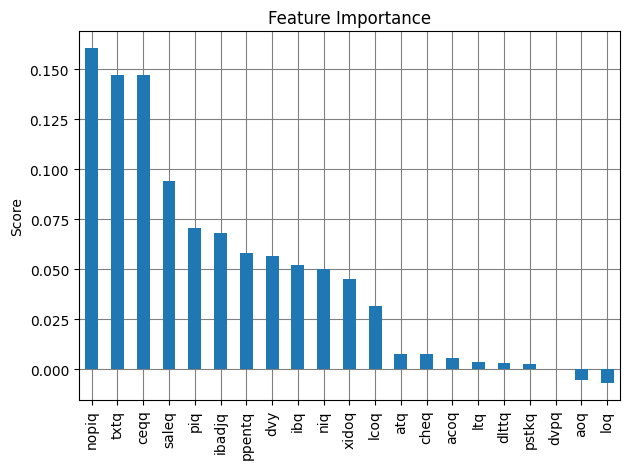

In [376]:
nn2 = nn2_importances_1 /(nn2_importances_1.sum())
fig, ax2 = plt.subplots()
nn2.plot.bar(ax=ax2)
ax2.set_axisbelow(True)
ax2.grid(color='gray')
ax2.set_title('Feature Importance')
ax2.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 5. NN3 Model for Fair Value Estimation

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN3_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN3_Decile_Signal = pd.DataFrame(index=list_company)
df_NN3_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN3_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN3 model
    model_nn3 = Sequential()
    model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0.1))
    model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0))
    model_nn3.add(Dense(1, activation='linear')) # Output layer
    model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn3.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn3.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN3_Decile_Signal = df_NN3_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

Epoch 1/50
324/324 [==============================] - 0s 1ms/step - loss: 12426636.0000 - mae: 477.5180
Epoch 2/50
324/324 [==============================] - 0s 837us/step - loss: 12089317.0000 - mae: 453.8474
Epoch 3/50
324/324 [==============================] - 0s 963us/step - loss: 11592259.0000 - mae: 455.6177
Epoch 4/50
324/324 [==============================] - 0s 858us/step - loss: 11711381.0000 - mae: 452.6992
Epoch 5/50
324/324 [==============================] - 0s 905us/step - loss: 11610651.0000 - mae: 464.2511
Epoch 6/50
324/324 [==============================] - 0s 871us/step - loss: 11322605.0000 - mae: 448.6959
Epoch 7/50
324/324 [==============================] - 0s 849us/step - loss: 11388753.0000 - mae: 463.2945
Epoch 8/50
324/324 [==============================] - 0s 867us/step - loss: 11261412.0000 - mae: 443.8254
Epoch 9/50
324/324 [==============================] - 0s 1ms/step - loss: 11183280.0000 - mae: 456.7581
Epoch 10/50
324/324 [=============================

### (1) Performance Analysis

In [33]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN3_Quintile_Signal = pd.concat([df_199804_199809, df_NN3_Quintile_Signal, df_202206], axis=1)
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.fillna(0).T
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.shift(1).dropna()

df_NN3_Decile_Signal = pd.concat([df_199804_199809, df_NN3_Decile_Signal, df_202206], axis=1)
df_NN3_Decile_Signal = df_NN3_Decile_Signal.fillna(0).T
df_NN3_Decile_Signal = df_NN3_Decile_Signal.shift(1).dropna()

df_NN3_20_Divided_Signal = pd.concat([df_199804_199809, df_NN3_20_Divided_Signal, df_202206], axis=1)
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.fillna(0).T
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.shift(1).dropna()

df_NN3_Percentile_Signal = pd.concat([df_199804_199809, df_NN3_Percentile_Signal, df_202206], axis=1)
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.fillna(0).T
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.shift(1).dropna()

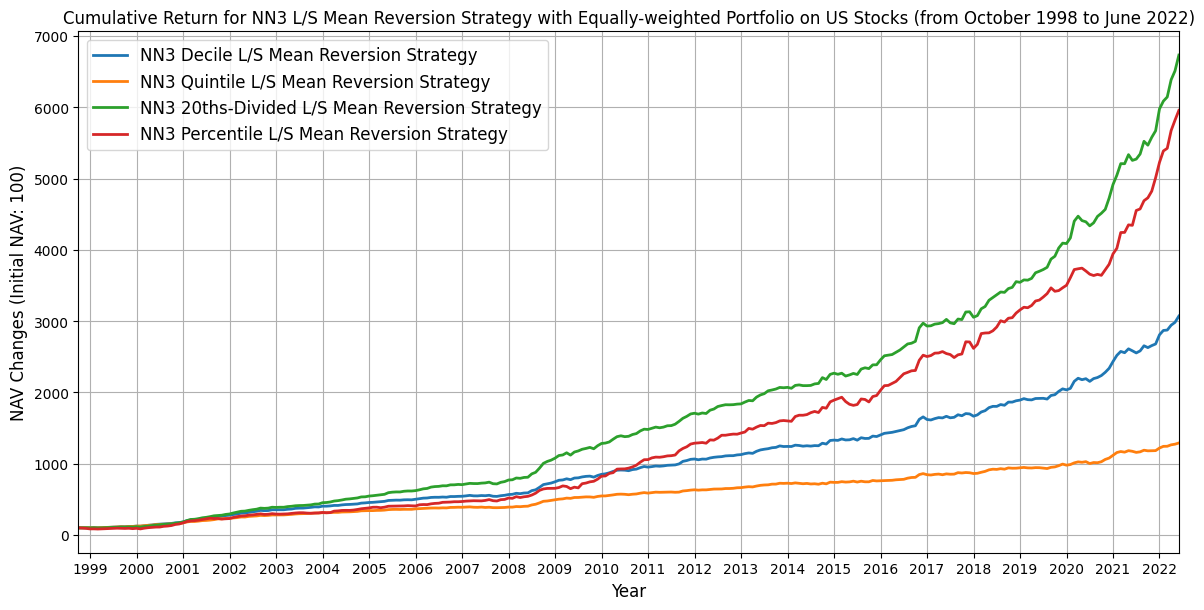

In [188]:
cum_NN3_Q_strategy_return = get_price_df(df_NN3_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_D_strategy_return = get_price_df(df_NN3_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_T_strategy_return = get_price_df(df_NN3_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_P_strategy_return = get_price_df(df_NN3_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN3_strategy_return = pd.concat([cum_NN3_D_strategy_return.rename('NN3 Decile L/S Mean Reversion Strategy'),
                                     cum_NN3_Q_strategy_return.rename('NN3 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN3_T_strategy_return.rename('NN3 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN3_P_strategy_return.rename('NN3 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN3_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN3 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [226]:
# Performance Stats
stats_NN3_Q = get_performance_stats(cum_NN3_Q_strategy_return, rfr=risk_free_rate_df, label='NN3 Quintile (Initial NAV: 100)')
stats_NN3_D = get_performance_stats(cum_NN3_D_strategy_return, rfr=risk_free_rate_df, label='NN3 Decile (Initial NAV: 100)')
stats_NN3_T = get_performance_stats(cum_NN3_T_strategy_return, rfr=risk_free_rate_df, label='NN3 20ths (Initial NAV: 100)')
stats_NN3_P = get_performance_stats(cum_NN3_P_strategy_return, rfr=risk_free_rate_df, label='NN3 Percentile (Initial NAV: 100)')
NN3_stats = pd.concat([stats_NN3_Q, stats_NN3_D, stats_NN3_T, stats_NN3_P], axis=0)
display(NN3_stats)

Total Return  Avg Return   Rf Rate  \
NN3 Quintile (Initial NAV: 100)       10.972314    0.110189  0.018682   
NN3 Decile (Initial NAV: 100)         30.093040    0.155710  0.018682   
NN3 20ths (Initial NAV: 100)          72.639271    0.198437  0.018682   
NN3 Percentile (Initial NAV: 100)     46.942264    0.176975  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN3 Quintile (Initial NAV: 100)      0.050041      1.828627  0.834326   
NN3 Decile (Initial NAV: 100)        0.058478      2.343220  0.905921   
NN3 20ths (Initial NAV: 100)         0.068284      2.632460  0.786990   
NN3 Percentile (Initial NAV: 100)    0.096788      1.635446 -0.034056   

                                   Kurtosis          HWM    HWM date  \
NN3 Quintile (Initial NAV: 100)    1.347156  1197.231356  2022-06-30   
NN3 Decile (Initial NAV: 100)      1.822998  3109.304005  2022-06-30   
NN3 20ths (Initial NAV: 100)       2.888233  7363.927076  2022-06-30   
NN3 Percentile (Initial NAV: 100)  2.962242  4794.226423  2022-06-30   

                                        MDD   Peak Date Trough Date  \
NN3 Quintile (Initial NAV: 100)    0.026859  2020-06-30  2020-07-31   
NN3 Decile (Initial NAV: 100)      0.028855  2021-05-31  2021-07-31   
NN3 20ths (Initial NAV: 100)       0.023392  2021-05-31  2021-07-31   
NN3 Percentile (Initial NAV: 100)  0.045831  2020-03-31  2020-08-31   

                                  Recession Date  MDD Duration  
NN3 Quintile (Initial NAV: 100)       2020-10-31           123  
NN3 Decile (Initial NAV: 100)         2021-11-30           183  
NN3 20ths (Initial NAV: 100)          2021-09-30           122  
NN3 Percentile (Initial NAV: 100)     2020-12-31           275

In [227]:
stats2_NN3_Q = get_performance_stats_2(df_NN3_Quintile_Signal, df_returns, df_market_cap, label='NN3 Quintile', model_type='ML')
stats2_NN3_D = get_performance_stats_2(df_NN3_Decile_Signal, df_returns, df_market_cap, label='NN3 Decile', model_type='ML')
stats2_NN3_T = get_performance_stats_2(df_NN3_20_Divided_Signal, df_returns, df_market_cap, label='NN3 20ths', model_type='ML')
stats2_NN3_P = get_performance_stats_2(df_NN3_Percentile_Signal, df_returns, df_market_cap, label='NN3 Percentile', model_type='ML')
NN3_stats2 = pd.concat([stats2_NN3_Q, stats2_NN3_D, stats2_NN3_T, stats2_NN3_P], axis=0)
display(NN3_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
NN3 Quintile (Long & Short)       10.972314            0.008749  3.277610e+10   
(Long Position)                 1311.086156            0.025511  1.105542e+09   
(Short Position)                  -0.945341           -0.010147  6.202225e+10   
NN3 Decile (Long & Short)         30.093040            0.012133  4.936544e+10   
(Long Position)                 9000.009826            0.032463  1.056606e+09   
(Short Position)                  -0.947396           -0.010280  9.187197e+10   
NN3 20ths (Long & Short)          72.639271            0.015199  7.863899e+10   
(Long Position)                55661.240658            0.039085  1.305014e+09   
(Short Position)                  -0.954311           -0.010769  1.426163e+11   
NN3 Percentile (Long & Short)     46.942264            0.013672  2.356793e+11   
(Long Position)                53868.589699            0.038966  3.338680e+09   
(Short Position)                  -0.982496           -0.014094  4.214271e+11   

                               Fraction>0  + Return Stocks (Avg)  \
NN3 Quintile (Long & Short)      0.713793               0.091682   
(Long Position)                  0.703448               0.103030   
(Short Position)                 0.379310               0.064674   
NN3 Decile (Long & Short)        0.762069               0.092555   
(Long Position)                  0.751724               0.103767   
(Short Position)                 0.393103               0.065275   
NN3 20ths (Long & Short)         0.800000               0.093000   
(Long Position)                  0.817241               0.103067   
(Short Position)                 0.379310               0.066499   
NN3 Percentile (Long & Short)    0.737931               0.091445   
(Long Position)                  0.813793               0.097593   
(Short Position)                 0.368966               0.069968   

                               - Return Stocks (Avg)  Odds Ratio  \
NN3 Quintile (Long & Short)                -0.077366    0.507571   
(Long Position)                            -0.073202    0.569466   
(Short Position)                           -0.071379    0.450701   
NN3 Decile (Long & Short)                  -0.073973    0.519506   
(Long Position)                            -0.065201    0.595738   
(Short Position)                           -0.071947    0.452815   
NN3 20ths (Long & Short)                   -0.071051    0.535243   
(Long Position)                            -0.054960    0.634114   
(Short Position)                           -0.073605    0.453898   
NN3 Percentile (Long & Short)              -0.078529    0.558481   
(Long Position)                            -0.055572    0.683485   
(Short Position)                           -0.081044    0.460126   

                               Odds Ratio 98-10  Odds Ratio 11-22  \
NN3 Quintile (Long & Short)            0.520802          0.496437   
(Long Position)                        0.588317          0.553847   
(Short Position)                       0.459761          0.442969   
NN3 Decile (Long & Short)              0.537226          0.504721   
(Long Position)                        0.625358          0.571645   
(Short Position)                       0.462102          0.444893   
NN3 20ths (Long & Short)               0.558743          0.515690   
(Long Position)                        0.675958          0.600282   
(Short Position)                       0.465021          0.444422   
NN3 Percentile (Long & Short)          0.564493          0.553156   
(Long Position)                        0.689289          0.678097   
(Short Position)                       0.461831          0.458671   

                               Transactions/Month  
NN3 Quintile (Long & Short)            408.686207  
(Long Position)                        187.710345  
(Short Position)                       224.931034  
NN3 Decile (Long & Short)              295.706897  
(Long Position)                        138.451724

In [53]:
cum_NN3_Q_strategy_return_L = get_price_df(df_NN3_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_Q_strategy_return_S = get_price_df(df_NN3_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_L = get_price_df(df_NN3_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_S = get_price_df(df_NN3_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN3_Q_L = get_performance_stats(cum_NN3_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Quintile L (Initial NAV: 100)')
stats_NN3_Q_S = get_performance_stats(cum_NN3_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Quintile S (Initial NAV: 100)')
stats_NN3_D_L = get_performance_stats(cum_NN3_D_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Decile L (Initial NAV: 100)')
stats_NN3_D_S = get_performance_stats(cum_NN3_D_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Decile S (Initial NAV: 100)')
NN3_stats3 = pd.concat([stats_NN3_Q_L, stats_NN3_Q_S, stats_NN3_D_L, stats_NN3_D_S], axis=0)
display(NN3_stats3)

Total Return  Avg Return   Rf Rate  \
NN3 Quintile L (Initial NAV: 100)   1328.453456    0.353702  0.018682   
NN3 Quintile S (Initial NAV: 100)      6.873907    0.090773  0.018682   
NN3 Decile L (Initial NAV: 100)     7098.941888    0.452640  0.018682   
NN3 Decile S (Initial NAV: 100)        5.918770    0.084850  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN3 Quintile L (Initial NAV: 100)    0.168617      1.986863  0.359533   
NN3 Quintile S (Initial NAV: 100)    0.169086      0.426353 -0.467468   
NN3 Decile L (Initial NAV: 100)      0.156629      2.770611  0.586410   
NN3 Decile S (Initial NAV: 100)      0.177353      0.373084 -0.408330   

                                   Kurtosis            HWM    HWM date  \
NN3 Quintile L (Initial NAV: 100)  0.531813  148544.423494  2021-10-31   
NN3 Quintile S (Initial NAV: 100)  1.276788    1064.147202  2021-08-31   
NN3 Decile L (Initial NAV: 100)    0.901572  756542.409932  2022-03-31   
NN3 Decile S (Initial NAV: 100)    1.599747     996.370439  2021-08-31   

                                        MDD   Peak Date Trough Date  \
NN3 Quintile L (Initial NAV: 100)  0.105013  2021-10-31  2022-06-30   
NN3 Quintile S (Initial NAV: 100)  0.260074  2021-08-31  2022-06-30   
NN3 Decile L (Initial NAV: 100)    0.061528  2022-03-31  2022-06-30   
NN3 Decile S (Initial NAV: 100)    0.305603  2021-08-31  2022-06-30   

                                   Recession Date    MDD Duration  
NN3 Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
NN3 Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
NN3 Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
NN3 Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [48]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]


X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
X_validation = np.array(X_validation)

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
y_validation = np.array(y_validation)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [49]:
def creating_nn3(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn3 = kt.Hyperband(creating_nn3, objective='val_loss', max_epochs=50, project_name='nn3_tuning_1', overwrite=True)
tuner_nn3.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn3.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 20
lay1: 13
lay2: 11
lay3: 17
dropout1: 0.2
dropout2: 0.2
dropout3: 0.1
dropout4: 0
regularization: 0.1
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
model_nn3 = Sequential()
model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
model_nn3.add(Dropout(0.1))
model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
model_nn3.add(Dropout(0))
model_nn3.add(Dense(1, activation='linear')) # Output layer
model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn3.fit(X_train, y_train)

perm_nn3 = PermutationImportance(model_nn3, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn3_importances_1 = pd.Series(perm_nn3.feature_importances_, index=feature_names).sort_values(ascending=False)

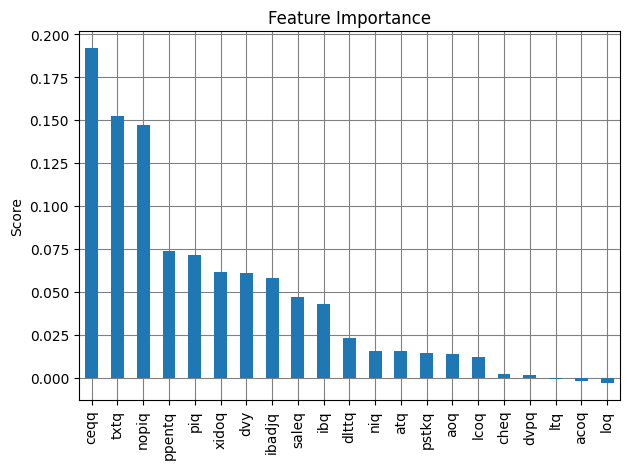

In [379]:
nn3 = nn3_importances_1 /(nn3_importances_1.sum())
fig, ax3 = plt.subplots()
nn3.plot.bar(ax=ax3)
ax3.set_axisbelow(True)
ax3.grid(color='gray')
ax3.set_title('Feature Importance')
ax3.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 6. NN4 Model for Fair Value Estimation

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN4_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN4_Decile_Signal = pd.DataFrame(index=list_company)
df_NN4_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN4_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN4 model
    model_nn4 = Sequential()
    model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
    model_nn4.add(Dropout(0.1))
    model_nn4.add(Dense(1, activation='linear')) # Output layer
    model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn4.fit(X_train, y_train, epochs=2, callbacks=[callback])
    y_fair = model_nn4.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN4_Decile_Signal = df_NN4_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

Epoch 1/2
324/324 [==============================] - 0s 1ms/step - loss: 13012776.0000 - mae: 520.3661
Epoch 2/2
324/324 [==============================] - 0s 1ms/step - loss: 12452136.0000 - mae: 498.9555
Epoch 1/2
312/312 [==============================] - 0s 914us/step - loss: 9081677.0000 - mae: 476.6732
Epoch 2/2
312/312 [==============================] - 0s 949us/step - loss: 7272689.0000 - mae: 478.4491
Epoch 1/2
303/303 [==============================] - 0s 944us/step - loss: 6899894.0000 - mae: 456.5502
Epoch 2/2
303/303 [==============================] - 0s 1ms/step - loss: 3034803.7500 - mae: 427.1839
Epoch 1/2
299/299 [==============================] - 0s 953us/step - loss: 3292873.0000 - mae: 455.6430
Epoch 2/2
299/299 [==============================] - 0s 947us/step - loss: 3047743.0000 - mae: 446.5970
Epoch 1/2
297/297 [==============================] - 0s 913us/step - loss: 4071605.5000 - mae: 475.0358
Epoch 2/2
297/297 [==============================] - 0s 1ms/step - l

### (1) Performance Analysis

In [36]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN4_Quintile_Signal = pd.concat([df_199804_199809, df_NN4_Quintile_Signal, df_202206], axis=1)
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.fillna(0).T
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.shift(1).dropna()

df_NN4_Decile_Signal = pd.concat([df_199804_199809, df_NN4_Decile_Signal, df_202206], axis=1)
df_NN4_Decile_Signal = df_NN4_Decile_Signal.fillna(0).T
df_NN4_Decile_Signal = df_NN4_Decile_Signal.shift(1).dropna()

df_NN4_20_Divided_Signal = pd.concat([df_199804_199809, df_NN4_20_Divided_Signal, df_202206], axis=1)
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.fillna(0).T
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.shift(1).dropna()

df_NN4_Percentile_Signal = pd.concat([df_199804_199809, df_NN4_Percentile_Signal, df_202206], axis=1)
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.fillna(0).T
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.shift(1).dropna()

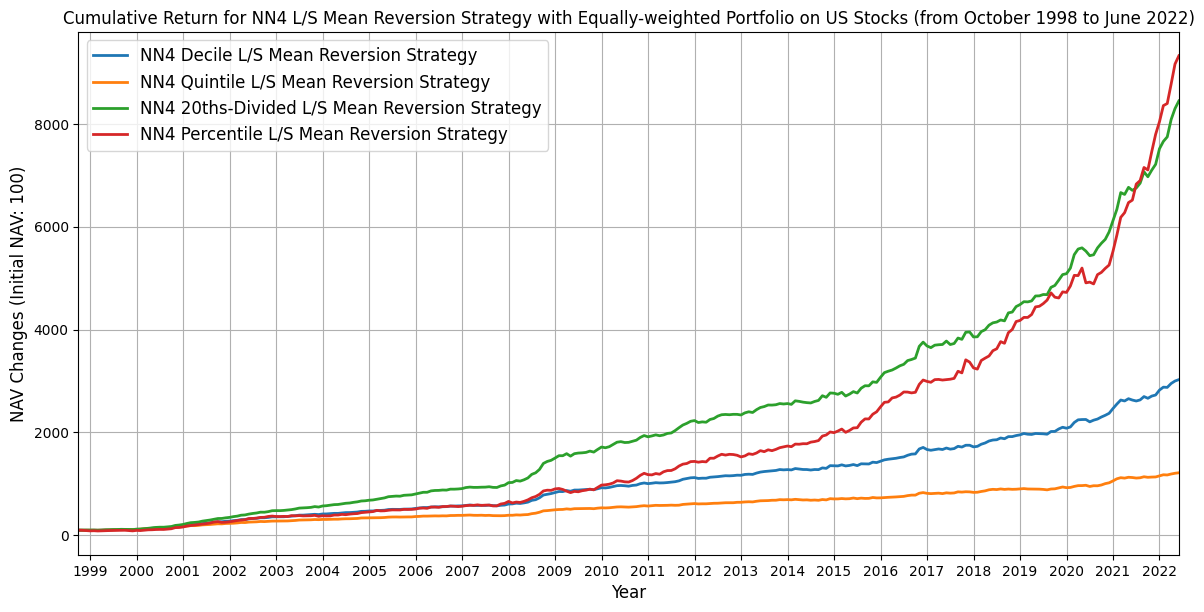

In [189]:
cum_NN4_Q_strategy_return = get_price_df(df_NN4_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_D_strategy_return = get_price_df(df_NN4_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_T_strategy_return = get_price_df(df_NN4_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_P_strategy_return = get_price_df(df_NN4_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN4_strategy_return = pd.concat([cum_NN4_D_strategy_return.rename('NN4 Decile L/S Mean Reversion Strategy'),
                                     cum_NN4_Q_strategy_return.rename('NN4 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN4_T_strategy_return.rename('NN4 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN4_P_strategy_return.rename('NN4 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN4_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN4 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [228]:
# Performance Stats
stats_NN4_Q = get_performance_stats(cum_NN4_Q_strategy_return, rfr=risk_free_rate_df, label='NN4 Quintile (Initial NAV: 100)')
stats_NN4_D = get_performance_stats(cum_NN4_D_strategy_return, rfr=risk_free_rate_df, label='NN4 Decile (Initial NAV: 100)')
stats_NN4_T = get_performance_stats(cum_NN4_T_strategy_return, rfr=risk_free_rate_df, label='NN4 20ths (Initial NAV: 100)')
stats_NN4_P = get_performance_stats(cum_NN4_P_strategy_return, rfr=risk_free_rate_df, label='NN4 Percentile (Initial NAV: 100)')
NN4_stats = pd.concat([stats_NN4_Q, stats_NN4_D, stats_NN4_T, stats_NN4_P], axis=0)
display(NN4_stats)

Total Return  Avg Return   Rf Rate  \
NN4 Quintile (Initial NAV: 100)       11.073966    0.110584  0.018682   
NN4 Decile (Initial NAV: 100)         29.592416    0.154921  0.018682   
NN4 20ths (Initial NAV: 100)          90.562877    0.209480  0.018682   
NN4 Percentile (Initial NAV: 100)    120.682577    0.224050  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN4 Quintile (Initial NAV: 100)      0.049570      1.853966  0.886015   
NN4 Decile (Initial NAV: 100)        0.061530      2.214166  0.971289   
NN4 20ths (Initial NAV: 100)         0.071539      2.667041  0.943901   
NN4 Percentile (Initial NAV: 100)    0.096405      2.130257  0.174948   

                                   Kurtosis           HWM    HWM date  \
NN4 Quintile (Initial NAV: 100)    1.350419   1207.396572  2022-06-30   
NN4 Decile (Initial NAV: 100)      1.804169   3059.241598  2022-06-30   
NN4 20ths (Initial NAV: 100)       1.863831   9156.287657  2022-06-30   
NN4 Percentile (Initial NAV: 100)  0.862964  12168.257663  2022-06-30   

                                        MDD   Peak Date Trough Date  \
NN4 Quintile (Initial NAV: 100)    0.028728  2019-02-28  2019-08-31   
NN4 Decile (Initial NAV: 100)      0.034363  2020-04-30  2020-07-31   
NN4 20ths (Initial NAV: 100)       0.029582  2020-04-30  2020-07-31   
NN4 Percentile (Initial NAV: 100)  0.045187  2020-03-31  2020-06-30   

                                  Recession Date  MDD Duration  
NN4 Quintile (Initial NAV: 100)       2019-11-30           275  
NN4 Decile (Initial NAV: 100)         2020-10-31           184  
NN4 20ths (Initial NAV: 100)          2020-10-31           184  
NN4 Percentile (Initial NAV: 100)     2020-09-30           183

In [229]:
stats2_NN4_Q = get_performance_stats_2(df_NN4_Quintile_Signal, df_returns, df_market_cap, label='NN4 Quintile', model_type='ML')
stats2_NN4_D = get_performance_stats_2(df_NN4_Decile_Signal, df_returns, df_market_cap, label='NN4 Decile', model_type='ML')
stats2_NN4_T = get_performance_stats_2(df_NN4_20_Divided_Signal, df_returns, df_market_cap, label='NN4 20ths', model_type='ML')
stats2_NN4_P = get_performance_stats_2(df_NN4_Percentile_Signal, df_returns, df_market_cap, label='NN4 Percentile', model_type='ML')
NN4_stats2 = pd.concat([stats2_NN4_Q, stats2_NN4_D, stats2_NN4_T, stats2_NN4_P], axis=0)
display(NN4_stats2)

Total Return  Avg Monthly Return  \
NN4 Quintile (Long & Short)        11.073966            0.008779   
(Long Position)                  1319.789306            0.025535   
(Short Position)                   -0.944813           -0.010114   
NN4 Decile (Long & Short)          29.592416            0.012075   
(Long Position)                  8912.793250            0.032428   
(Short Position)                   -0.947923           -0.010315   
NN4 20ths (Long & Short)           90.562877            0.015975   
(Long Position)                 88805.359640            0.040790   
(Short Position)                   -0.955461           -0.010858   
NN4 Percentile (Long & Short)     120.682577            0.016990   
(Long Position)                416994.502867            0.046453   
(Short Position)                   -0.985997           -0.014865   

                                Avg Mkt Cap  Fraction>0  \
NN4 Quintile (Long & Short)    3.549626e+10    0.710345   
(Long Position)                7.176343e+08    0.710345   
(Short Position)               6.758440e+10    0.372414   
NN4 Decile (Long & Short)      6.021679e+10    0.744828   
(Long Position)                5.763279e+08    0.748276   
(Short Position)               1.124679e+11    0.393103   
NN4 20ths (Long & Short)       1.037590e+11    0.782759   
(Long Position)                6.013138e+08    0.837931   
(Short Position)               1.878496e+11    0.393103   
NN4 Percentile (Long & Short)  3.446433e+11    0.737931   
(Long Position)                1.101012e+09    0.875862   
(Short Position)               5.952869e+11    0.372414   

                               + Return Stocks (Avg)  - Return Stocks (Avg)  \
NN4 Quintile (Long & Short)                 0.092117              -0.077589   
(Long Position)                             0.103175              -0.073395   
(Short Position)                            0.065184              -0.071630   
NN4 Decile (Long & Short)                   0.092874              -0.074339   
(Long Position)                             0.103491              -0.064066   
(Short Position)                            0.066146              -0.073100   
NN4 20ths (Long & Short)                    0.093798              -0.071350   
(Long Position)                             0.103729              -0.051928   
(Short Position)                            0.067432              -0.075255   
NN4 Percentile (Long & Short)               0.093344              -0.077177   
(Long Position)                             0.101596              -0.049277   
(Short Position)                            0.069642              -0.079896   

                               Odds Ratio  Odds Ratio 98-10  Odds Ratio 11-22  \
NN4 Quintile (Long & Short)      0.506937          0.521510          0.494674   
(Long Position)                  0.569542          0.589480          0.553032   
(Short Position)                 0.449454          0.460133          0.440335   
NN4 Decile (Long & Short)        0.519359          0.538336          0.503573   
(Long Position)                  0.594950          0.628187          0.568093   
(Short Position)                 0.453556          0.462406          0.446006   
NN4 20ths (Long & Short)         0.539662          0.562907          0.520561   
(Long Position)                  0.641832          0.693816          0.600975   
(Short Position)                 0.456963          0.461527          0.453076   
NN4 Percentile (Long & Short)    0.578313          0.580282          0.576616   
(Long Position)                  0.746207          0.757718          0.736092   
(Short Position)                 0.458129          0.451010          0.464182   

                               Transactions/Month  
NN4 Quintile (Long & Short)            310.058621  
(Long Position)                        148.082759  
(Short Position)                       162.331034  
NN4 Decile (Long & Short)              224.675862  
(Long Position)                      

In [54]:
cum_NN4_Q_strategy_return_L = get_price_df(df_NN4_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_Q_strategy_return_S = get_price_df(df_NN4_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_L = get_price_df(df_NN4_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_S = get_price_df(df_NN4_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN4_Q_L = get_performance_stats(cum_NN4_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Quintile L (Initial NAV: 100)')
stats_NN4_Q_S = get_performance_stats(cum_NN4_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Quintile S (Initial NAV: 100)')
stats_NN4_D_L = get_performance_stats(cum_NN4_D_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Decile L (Initial NAV: 100)')
stats_NN4_D_S = get_performance_stats(cum_NN4_D_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Decile S (Initial NAV: 100)')
NN4_stats3 = pd.concat([stats_NN4_Q_L, stats_NN4_Q_S, stats_NN4_D_L, stats_NN4_D_S], axis=0)
display(NN4_stats3)

Total Return  Avg Return   Rf Rate  \
NN4 Quintile L (Initial NAV: 100)   1290.207151    0.352039  0.018682   
NN4 Quintile S (Initial NAV: 100)      7.509980    0.094347  0.018682   
NN4 Decile L (Initial NAV: 100)     8722.689084    0.465292  0.018682   
NN4 Decile S (Initial NAV: 100)        7.553838    0.094583  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN4 Quintile L (Initial NAV: 100)    0.168721      1.975784  0.366861   
NN4 Quintile S (Initial NAV: 100)    0.171001      0.442479 -0.540919   
NN4 Decile L (Initial NAV: 100)      0.153980      2.900444  0.660718   
NN4 Decile S (Initial NAV: 100)      0.180140      0.421344 -0.378699   

                                   Kurtosis            HWM    HWM date  \
NN4 Quintile L (Initial NAV: 100)  0.680629  146947.596653  2021-10-31   
NN4 Quintile S (Initial NAV: 100)  1.247910    1135.309600  2021-10-31   
NN4 Decile L (Initial NAV: 100)    1.079182  936993.216410  2022-03-31   
NN4 Decile S (Initial NAV: 100)    1.100497    1173.133831  2021-10-31   

                                        MDD   Peak Date Trough Date  \
NN4 Quintile L (Initial NAV: 100)  0.121315  2021-10-31  2022-06-30   
NN4 Quintile S (Initial NAV: 100)  0.250426  2021-10-31  2022-06-30   
NN4 Decile L (Initial NAV: 100)    0.068970  2022-03-31  2022-06-30   
NN4 Decile S (Initial NAV: 100)    0.270856  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
NN4 Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
NN4 Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
NN4 Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
NN4 Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [70]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [71]:
def creating_nn4(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit11 = hp.Int('lay4',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn4 = kt.Hyperband(creating_nn4, objective='val_loss', max_epochs=50, project_name='nn4_tuning_1', overwrite=True)
tuner_nn4.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn4.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 11
lay1: 4
lay2: 15
lay3: 17
lay4: 16
dropout1: 0.3
dropout2: 0.3
dropout3: 0.4
dropout4: 0.4
dropout5: 0.1
regularization: 0.01
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 2
"""

### (3) Feature Importance

In [ ]:
model_nn4 = Sequential()
model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
model_nn4.add(Dropout(0.3))
model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
model_nn4.add(Dropout(0.3))
model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
model_nn4.add(Dropout(0.4))
model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
model_nn4.add(Dropout(0.4))
model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
model_nn4.add(Dropout(0.1))
model_nn4.add(Dense(1, activation='linear')) # Output layer
model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn4.fit(X_train, y_train)

perm_nn4 = PermutationImportance(model_nn4, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn4_importances_1 = pd.Series(perm_nn4.feature_importances_, index=feature_names).sort_values(ascending=False)

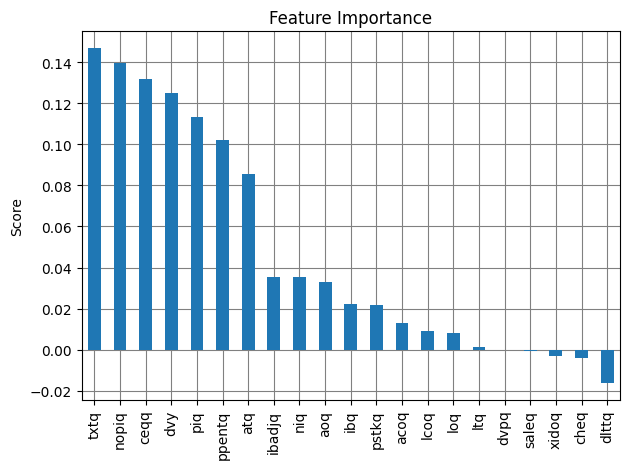

In [378]:
nn4 = nn4_importances_1 /(nn4_importances_1.sum())
fig, ax4 = plt.subplots()
nn4.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 7. NN5 Model for Fair Value Estimation

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN5_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN5_Decile_Signal = pd.DataFrame(index=list_company)
df_NN5_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN5_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN5 model
    model_nn5 = Sequential()
    model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,)))  # Input layer
    model_nn5.add(Dropout(0.4))
    model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 1
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 2
    model_nn5.add(Dropout(0.2))
    model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 3
    model_nn5.add(Dropout(0.5))
    model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.6))
    model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(1, activation='linear'))  # Output layer
    model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn5.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn5.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN5_Decile_Signal = df_NN5_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

Epoch 1/6
324/324 [==============================] - 0s 997us/step - loss: 13972407.0000 - mae: 576.4697
Epoch 2/6
324/324 [==============================] - 0s 938us/step - loss: 14315546.0000 - mae: 572.9008
Epoch 3/6
324/324 [==============================] - 0s 926us/step - loss: 13430044.0000 - mae: 576.2184
Epoch 4/6
324/324 [==============================] - 0s 1ms/step - loss: 13193477.0000 - mae: 562.5418
Epoch 5/6
324/324 [==============================] - 0s 932us/step - loss: 14118818.0000 - mae: 571.4252
Epoch 6/6
324/324 [==============================] - 0s 932us/step - loss: 14552281.0000 - mae: 586.1780
Epoch 1/6
312/312 [==============================] - 0s 1ms/step - loss: 8470296.0000 - mae: 552.9696
Epoch 2/6
312/312 [==============================] - 0s 952us/step - loss: 7948431.0000 - mae: 559.3021
Epoch 3/6
312/312 [==============================] - 0s 959us/step - loss: 7643949.0000 - mae: 534.2714
Epoch 4/6
312/312 [==============================] - 0s 923us/

### (1) Performance Analysis

In [39]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN5_Quintile_Signal = pd.concat([df_199804_199809, df_NN5_Quintile_Signal, df_202206], axis=1)
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.fillna(0).T
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.shift(1).dropna()

df_NN5_Decile_Signal = pd.concat([df_199804_199809, df_NN5_Decile_Signal, df_202206], axis=1)
df_NN5_Decile_Signal = df_NN5_Decile_Signal.fillna(0).T
df_NN5_Decile_Signal = df_NN5_Decile_Signal.shift(1).dropna()

df_NN5_20_Divided_Signal = pd.concat([df_199804_199809, df_NN5_20_Divided_Signal, df_202206], axis=1)
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.fillna(0).T
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.shift(1).dropna()

df_NN5_Percentile_Signal = pd.concat([df_199804_199809, df_NN5_Percentile_Signal, df_202206], axis=1)
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.fillna(0).T
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.shift(1).dropna()

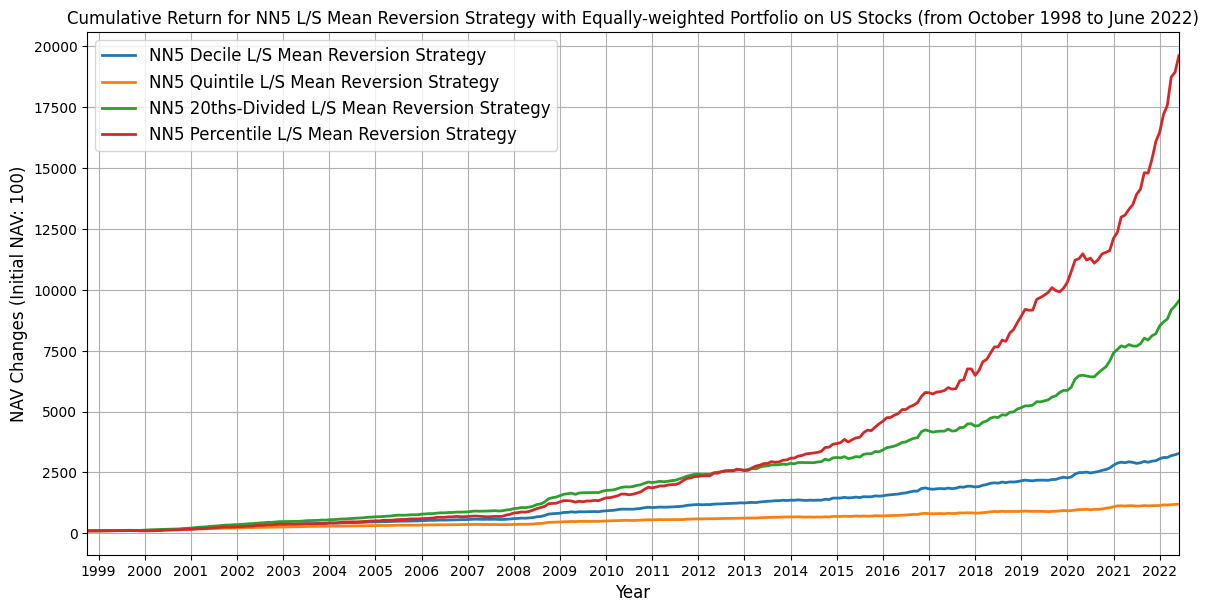

In [165]:
cum_NN5_Q_strategy_return = get_price_df(df_NN5_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_D_strategy_return = get_price_df(df_NN5_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_T_strategy_return = get_price_df(df_NN5_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_P_strategy_return = get_price_df(df_NN5_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN5_strategy_return = pd.concat([cum_NN5_D_strategy_return.rename('NN5 Decile L/S Mean Reversion Strategy'),
                                     cum_NN5_Q_strategy_return.rename('NN5 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN5_T_strategy_return.rename('NN5 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN5_P_strategy_return.rename('NN5 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN5_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN5 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [230]:
# Performance Stats
stats_NN5_Q = get_performance_stats(cum_NN5_Q_strategy_return, rfr=risk_free_rate_df, label='NN5 Quintile (Initial NAV: 100)')
stats_NN5_D = get_performance_stats(cum_NN5_D_strategy_return, rfr=risk_free_rate_df, label='NN5 Decile (Initial NAV: 100)')
stats_NN5_T = get_performance_stats(cum_NN5_T_strategy_return, rfr=risk_free_rate_df, label='NN5 20ths (Initial NAV: 100)')
stats_NN5_P = get_performance_stats(cum_NN5_P_strategy_return, rfr=risk_free_rate_df, label='NN5 Percentile (Initial NAV: 100)')
NN5_stats = pd.concat([stats_NN5_Q, stats_NN5_D, stats_NN5_T, stats_NN5_P], axis=0)
display(NN5_stats)

Total Return  Avg Return   Rf Rate  \
NN5 Quintile (Initial NAV: 100)       11.249372    0.111259  0.018682   
NN5 Decile (Initial NAV: 100)         33.355523    0.160576  0.018682   
NN5 20ths (Initial NAV: 100)         103.512981    0.216236  0.018682   
NN5 Percentile (Initial NAV: 100)    226.601904    0.256752  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN5 Quintile (Initial NAV: 100)      0.047883      1.933376  0.724075   
NN5 Decile (Initial NAV: 100)        0.057318      2.475529  0.870641   
NN5 20ths (Initial NAV: 100)         0.067420      2.930192  0.699165   
NN5 Percentile (Initial NAV: 100)    0.087374      2.724709  0.121578   

                                   Kurtosis           HWM    HWM date  \
NN5 Quintile (Initial NAV: 100)    0.742007   1224.937178  2022-06-30   
NN5 Decile (Initial NAV: 100)      1.639022   3435.552320  2022-06-30   
NN5 20ths (Initial NAV: 100)       1.496961  10451.298076  2022-06-30   
NN5 Percentile (Initial NAV: 100)  1.411404  22760.190381  2022-06-30   

                                        MDD   Peak Date Trough Date  \
NN5 Quintile (Initial NAV: 100)    0.023069  2019-02-28  2019-08-31   
NN5 Decile (Initial NAV: 100)      0.024766  2021-05-31  2021-07-31   
NN5 20ths (Initial NAV: 100)       0.032341  2016-12-31  2017-02-28   
NN5 Percentile (Initial NAV: 100)  0.048935  2017-11-30  2018-01-31   

                                  Recession Date  MDD Duration  
NN5 Quintile (Initial NAV: 100)       2019-11-30           275  
NN5 Decile (Initial NAV: 100)         2021-09-30           122  
NN5 20ths (Initial NAV: 100)          2017-06-30           181  
NN5 Percentile (Initial NAV: 100)     2018-03-31           121

In [231]:
stats2_NN5_Q = get_performance_stats_2(df_NN5_Quintile_Signal, df_returns, df_market_cap, label='NN5 Quintile', model_type='ML')
stats2_NN5_D = get_performance_stats_2(df_NN5_Decile_Signal, df_returns, df_market_cap, label='NN5 Decile', model_type='ML')
stats2_NN5_T = get_performance_stats_2(df_NN5_20_Divided_Signal, df_returns, df_market_cap, label='NN5 20ths', model_type='ML')
stats2_NN5_P = get_performance_stats_2(df_NN5_Percentile_Signal, df_returns, df_market_cap, label='NN5 Percentile', model_type='ML')
NN5_stats2 = pd.concat([stats2_NN5_Q, stats2_NN5_D, stats2_NN5_T, stats2_NN5_P], axis=0)
display(NN5_stats2)

Total Return  Avg Monthly Return  \
NN5 Quintile (Long & Short)        11.249372            0.008830   
(Long Position)                  1234.259767            0.025294   
(Short Position)                   -0.937405           -0.009676   
NN5 Decile (Long & Short)          33.355523            0.012487   
(Long Position)                  9436.197076            0.032635   
(Short Position)                   -0.934927           -0.009541   
NN5 20ths (Long & Short)          103.512981            0.016447   
(Long Position)                 92779.255636            0.040950   
(Short Position)                   -0.940053           -0.009826   
NN5 Percentile (Long & Short)     226.601904            0.019227   
(Long Position)                952818.929027            0.049492   
(Short Position)                   -0.975941           -0.012993   

                                Avg Mkt Cap  Fraction>0  \
NN5 Quintile (Long & Short)    3.867094e+10    0.713793   
(Long Position)                5.682630e+08    0.696552   
(Short Position)               7.380599e+10    0.379310   
NN5 Decile (Long & Short)      6.726812e+10    0.772414   
(Long Position)                4.650007e+08    0.758621   
(Short Position)               1.256990e+11    0.386207   
NN5 20ths (Long & Short)       1.159337e+11    0.817241   
(Long Position)                4.482641e+08    0.844828   
(Short Position)               2.094126e+11    0.400000   
NN5 Percentile (Long & Short)  3.875807e+11    0.775862   
(Long Position)                6.865813e+08    0.917241   
(Short Position)               6.489386e+11    0.379310   

                               + Return Stocks (Avg)  - Return Stocks (Avg)  \
NN5 Quintile (Long & Short)                 0.090593              -0.075890   
(Long Position)                             0.103169              -0.073704   
(Short Position)                            0.062310              -0.068434   
NN5 Decile (Long & Short)                   0.090633              -0.071061   
(Long Position)                             0.103724              -0.064157   
(Short Position)                            0.061401              -0.067681   
NN5 20ths (Long & Short)                    0.091072              -0.066149   
(Long Position)                             0.103764              -0.050836   
(Short Position)                            0.061652              -0.067844   
NN5 Percentile (Long & Short)               0.089256              -0.069326   
(Long Position)                             0.100166              -0.039620   
(Short Position)                            0.062288              -0.073522   

                               Odds Ratio  Odds Ratio 98-10  Odds Ratio 11-22  \
NN5 Quintile (Long & Short)      0.506355          0.521196          0.493866   
(Long Position)                  0.568864          0.589249          0.551988   
(Short Position)                 0.449018          0.459824          0.439789   
NN5 Decile (Long & Short)        0.519361          0.539189          0.502881   
(Long Position)                  0.595940          0.628319          0.569836   
(Short Position)                 0.452807          0.464102          0.443167   
NN5 20ths (Long & Short)         0.536517          0.562404          0.515274   
(Long Position)                  0.641992          0.694277          0.601103   
(Short Position)                 0.451640          0.461229          0.443463   
NN5 Percentile (Long & Short)    0.589778          0.605377          0.576559   
(Long Position)                  0.786030          0.816014          0.760766   
(Short Position)                 0.457583          0.464231          0.451926   

                               Transactions/Month  
NN5 Quintile (Long & Short)            270.717241  
(Long Position)                        140.137931  
(Short Position)                       130.696552  
NN5 Decile (Long & Short)              211.065517  
(Long Position)                      

In [55]:
cum_NN5_Q_strategy_return_L = get_price_df(df_NN5_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_Q_strategy_return_S = get_price_df(df_NN5_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_L = get_price_df(df_NN5_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_S = get_price_df(df_NN5_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN5_Q_L = get_performance_stats(cum_NN5_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Quintile L (Initial NAV: 100)')
stats_NN5_Q_S = get_performance_stats(cum_NN5_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Quintile S (Initial NAV: 100)')
stats_NN5_D_L = get_performance_stats(cum_NN5_D_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Decile L (Initial NAV: 100)')
stats_NN5_D_S = get_performance_stats(cum_NN5_D_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Decile S (Initial NAV: 100)')
NN5_stats3 = pd.concat([stats_NN5_Q_L, stats_NN5_Q_S, stats_NN5_D_L, stats_NN5_D_S], axis=0)
display(NN5_stats3)

Total Return  Avg Return   Rf Rate  \
NN5 Quintile L (Initial NAV: 100)   1226.724568    0.349172  0.018682   
NN5 Quintile S (Initial NAV: 100)      7.628569    0.094984  0.018682   
NN5 Decile L (Initial NAV: 100)     8855.006874    0.466221  0.018682   
NN5 Decile S (Initial NAV: 100)        6.839934    0.090574  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN5 Quintile L (Initial NAV: 100)    0.168251      1.964266  0.363010   
NN5 Quintile S (Initial NAV: 100)    0.163599      0.466396 -0.561379   
NN5 Decile L (Initial NAV: 100)      0.154783      2.891391  0.711811   
NN5 Decile S (Initial NAV: 100)      0.168064      0.427765 -0.480275   

                                   Kurtosis            HWM    HWM date  \
NN5 Quintile L (Initial NAV: 100)  0.609937  139730.710008  2021-10-31   
NN5 Quintile S (Initial NAV: 100)  1.296159    1109.648153  2021-10-31   
NN5 Decile L (Initial NAV: 100)    1.266014  950094.228398  2022-03-31   
NN5 Decile S (Initial NAV: 100)    1.391595    1053.817951  2021-10-31   

                                        MDD   Peak Date Trough Date  \
NN5 Quintile L (Initial NAV: 100)  0.121364  2021-10-31  2022-06-30   
NN5 Quintile S (Initial NAV: 100)  0.222405  2021-10-31  2022-06-30   
NN5 Decile L (Initial NAV: 100)    0.067881  2022-03-31  2022-06-30   
NN5 Decile S (Initial NAV: 100)    0.256045  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
NN5 Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
NN5 Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
NN5 Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
NN5 Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [ ]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [403]:
def creating_nn5(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn5 = kt.Hyperband(creating_nn5, objective='val_loss', max_epochs=50, project_name='nn5_tuning_1', overwrite=True)
tuner_nn5.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn5.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 4
lay1: 13
lay2: 19
lay3: 2
lay4: 16
lay5: 9
dropout1: 0.4
dropout2: 0.1
dropout3: 0.2
dropout4: 0.5
dropout5: 0.6
dropout6: 0.1
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 6
"""

### (3) Feature Importance

In [ ]:
model_nn5 = Sequential()
model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn5.add(Dropout(0.4))
model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn5.add(Dropout(0.1))
model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn5.add(Dropout(0.2))
model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 3
model_nn5.add(Dropout(0.5))
model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn5.add(Dropout(0.6))
model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn5.add(Dropout(0.1))
model_nn5.add(Dense(1, activation='linear')) # Output layer
model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn5.fit(X_train, y_train)

perm_nn5 = PermutationImportance(model_nn5, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn5_importances_1 = pd.Series(perm_nn5.feature_importances_, index=feature_names).sort_values(ascending=False)

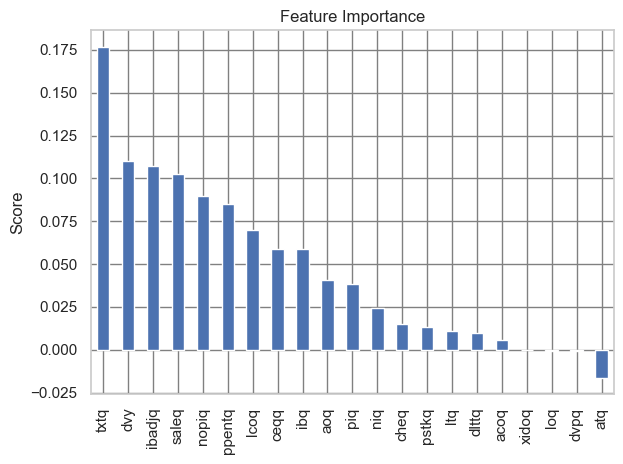

In [20]:
nn5 = nn5_importances_1 /(nn5_importances_1.sum())
fig, ax4 = plt.subplots()
nn5.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 8. NN6 Model for Fair Value Estimation

In [ ]:
"""
Hyperparameters:
Input_layer: 12
lay1: 16
lay2: 11
lay3: 11
lay4: 18
lay5: 3
lay6: 18
dropout1: 0.0
dropout2: 0.6
dropout3: 0.6
dropout4: 0.1
dropout5: 0.6
dropout6: 0.0
dropout7: 0.6
regularization: 0.01
dense_activation: relu
learning_rate: 0.001
tuner/epochs: 6
"""

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN6_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN6_Decile_Signal = pd.DataFrame(index=list_company)
df_NN6_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN6_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN6 model
    model_nn6 = Sequential()
    model_nn6.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,)))  # Input layer
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 1
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 2
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 3
    model_nn6.add(Dropout(0.1))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(1, activation='linear'))  # Output layer
    model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn6.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn6.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN6_Decile_Signal = df_NN6_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

Epoch 1/6
324/324 [==============================] - 0s 1ms/step - loss: 14901900.0000 - mae: 644.1125
Epoch 2/6
324/324 [==============================] - 0s 1ms/step - loss: 13992908.0000 - mae: 556.5610
Epoch 3/6
324/324 [==============================] - 0s 1ms/step - loss: 13902259.0000 - mae: 549.8785
Epoch 4/6
324/324 [==============================] - 0s 1ms/step - loss: 13201163.0000 - mae: 525.2550
Epoch 5/6
324/324 [==============================] - 0s 1ms/step - loss: 13080489.0000 - mae: 531.7000
Epoch 6/6
324/324 [==============================] - 0s 1ms/step - loss: 13448993.0000 - mae: 530.7276
Epoch 1/6
312/312 [==============================] - 0s 1ms/step - loss: 8870280.0000 - mae: 600.2618
Epoch 2/6
312/312 [==============================] - 0s 1ms/step - loss: 7686423.5000 - mae: 509.3983
Epoch 3/6
312/312 [==============================] - 0s 1ms/step - loss: 7766271.5000 - mae: 485.9565
Epoch 4/6
312/312 [==============================] - 0s 1ms/step - loss: 756

### (1) Performance Analysis

In [42]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN6_Quintile_Signal = pd.concat([df_199804_199809, df_NN6_Quintile_Signal, df_202206], axis=1)
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.fillna(0).T
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.shift(1).dropna()

df_NN6_Decile_Signal = pd.concat([df_199804_199809, df_NN6_Decile_Signal, df_202206], axis=1)
df_NN6_Decile_Signal = df_NN6_Decile_Signal.fillna(0).T
df_NN6_Decile_Signal = df_NN6_Decile_Signal.shift(1).dropna()

df_NN6_20_Divided_Signal = pd.concat([df_199804_199809, df_NN6_20_Divided_Signal, df_202206], axis=1)
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.fillna(0).T
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.shift(1).dropna()

df_NN6_Percentile_Signal = pd.concat([df_199804_199809, df_NN6_Percentile_Signal, df_202206], axis=1)
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.fillna(0).T
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.shift(1).dropna()

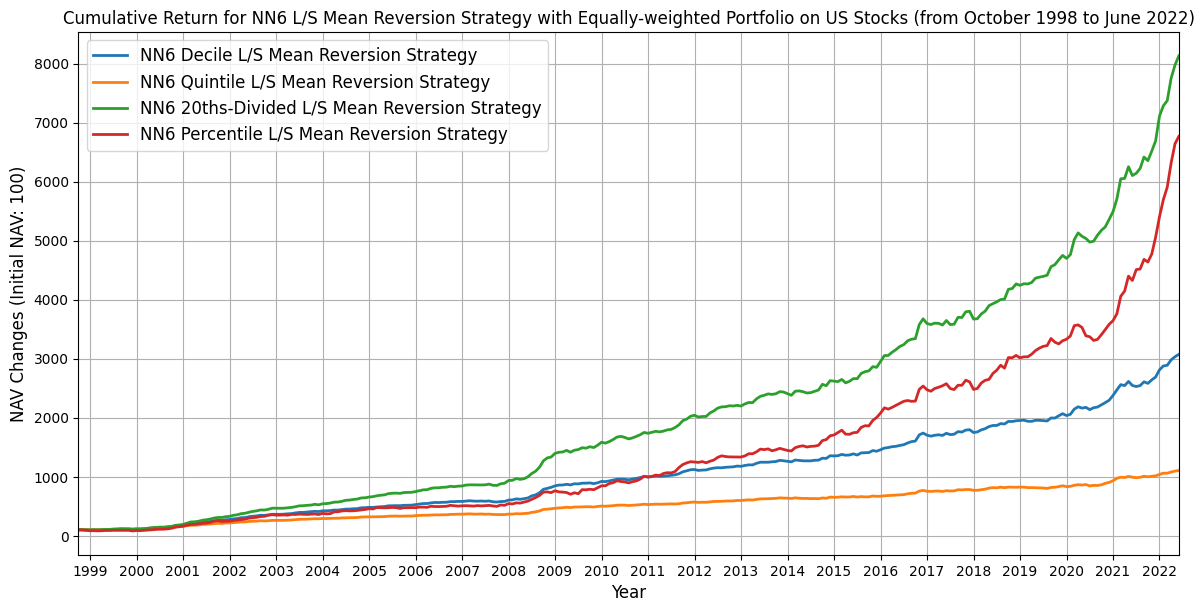

In [190]:
cum_NN6_Q_strategy_return = get_price_df(df_NN6_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_D_strategy_return = get_price_df(df_NN6_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_T_strategy_return = get_price_df(df_NN6_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_P_strategy_return = get_price_df(df_NN6_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN6_strategy_return = pd.concat([cum_NN6_D_strategy_return.rename('NN6 Decile L/S Mean Reversion Strategy'),
                                     cum_NN6_Q_strategy_return.rename('NN6 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN6_T_strategy_return.rename('NN6 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN6_P_strategy_return.rename('NN6 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN6_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN6 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [232]:
# Performance Stats
stats_NN6_Q = get_performance_stats(cum_NN6_Q_strategy_return, rfr=risk_free_rate_df, label='NN6 Quintile (Initial NAV: 100)')
stats_NN6_D = get_performance_stats(cum_NN6_D_strategy_return, rfr=risk_free_rate_df, label='NN6 Decile (Initial NAV: 100)')
stats_NN6_T = get_performance_stats(cum_NN6_T_strategy_return, rfr=risk_free_rate_df, label='NN6 20ths (Initial NAV: 100)')
stats_NN6_P = get_performance_stats(cum_NN6_P_strategy_return, rfr=risk_free_rate_df, label='NN6 Percentile (Initial NAV: 100)')
NN6_stats = pd.concat([stats_NN6_Q, stats_NN6_D, stats_NN6_T, stats_NN6_P], axis=0)
display(NN6_stats)

Total Return  Avg Return   Rf Rate  \
NN6 Quintile (Initial NAV: 100)       10.397811    0.107893  0.018682   
NN6 Decile (Initial NAV: 100)         29.363385    0.154555  0.018682   
NN6 20ths (Initial NAV: 100)          81.700114    0.204307  0.018682   
NN6 Percentile (Initial NAV: 100)     76.991437    0.201338  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN6 Quintile (Initial NAV: 100)      0.048714      1.831318  0.835081   
NN6 Decile (Initial NAV: 100)        0.062840      2.162212  1.105857   
NN6 20ths (Initial NAV: 100)         0.077153      2.405934  1.069353   
NN6 Percentile (Initial NAV: 100)    0.102170      1.787750  0.198372   

                                   Kurtosis          HWM    HWM date  \
NN6 Quintile (Initial NAV: 100)    1.105527  1139.781067  2022-06-30   
NN6 Decile (Initial NAV: 100)      2.460501  3036.338456  2022-06-30   
NN6 20ths (Initial NAV: 100)       3.005415  8270.011381  2022-06-30   
NN6 Percentile (Initial NAV: 100)  2.733569  7799.143664  2022-06-30   

                                        MDD   Peak Date Trough Date  \
NN6 Quintile (Initial NAV: 100)    0.026024  2020-04-30  2020-07-31   
NN6 Decile (Initial NAV: 100)      0.027412  2021-05-31  2021-07-31   
NN6 20ths (Initial NAV: 100)       0.036813  2020-04-30  2020-08-31   
NN6 Percentile (Initial NAV: 100)  0.086608  2016-12-31  2018-02-28   

                                  Recession Date  MDD Duration  
NN6 Quintile (Initial NAV: 100)       2020-11-30           214  
NN6 Decile (Initial NAV: 100)         2021-09-30           122  
NN6 20ths (Initial NAV: 100)          2020-10-31           184  
NN6 Percentile (Initial NAV: 100)     2018-08-31           608

In [44]:
stats2_NN6_Q = get_performance_stats_2(df_NN6_Quintile_Signal, df_returns, df_market_cap, label='NN6 Quintile', model_type='ML')
stats2_NN6_D = get_performance_stats_2(df_NN6_Decile_Signal, df_returns, df_market_cap, label='NN6 Decile', model_type='ML')
stats2_NN6_T = get_performance_stats_2(df_NN6_20_Divided_Signal, df_returns, df_market_cap, label='NN6 20ths', model_type='ML')
stats2_NN6_P = get_performance_stats_2(df_NN6_Percentile_Signal, df_returns, df_market_cap, label='NN6 Percentile', model_type='ML')
NN6_stats2 = pd.concat([stats2_NN6_Q, stats2_NN6_D, stats2_NN6_T, stats2_NN6_P], axis=0)
display(NN6_stats2)

Total Return  Avg Monthly Return  \
NN6 Quintile (Long & Short)        10.049977            0.008465   
(Long Position)                  1212.926721            0.025231   
(Short Position)                   -0.950523           -0.010493   
NN6 Decile (Long & Short)          29.727380            0.012091   
(Long Position)                  9266.447389            0.032569   
(Short Position)                   -0.950554           -0.010495   
NN6 20ths (Long & Short)           80.325080            0.015553   
(Long Position)                 81149.446057            0.040460   
(Short Position)                   -0.963691           -0.011567   
NN6 Percentile (Long & Short)      66.676883            0.014898   
(Long Position)                144303.664335            0.042564   
(Short Position)                   -0.988108           -0.015430   

                                Avg Mkt Cap  Fraction>0  \
NN6 Quintile (Long & Short)    3.439555e+10    0.710345   
(Long Position)                9.260438e+08    0.693103   
(Short Position)               6.526417e+10    0.393103   
NN6 Decile (Long & Short)      5.804417e+10    0.748276   
(Long Position)                7.117526e+08    0.758621   
(Short Position)               1.082464e+11    0.386207   
NN6 20ths (Long & Short)       1.008934e+11    0.775862   
(Long Position)                7.356939e+08    0.844828   
(Short Position)               1.825929e+11    0.379310   
NN6 Percentile (Long & Short)  3.494678e+11    0.662069   
(Long Position)                1.431230e+09    0.848276   
(Short Position)               6.087299e+11    0.382759   

                               + Return Stocks (Avg)  - Return Stocks (Avg)  \
NN6 Quintile (Long & Short)                 0.092487              -0.078727   
(Long Position)                             0.102660              -0.073216   
(Short Position)                            0.066588              -0.073637   
NN6 Decile (Long & Short)                   0.093942              -0.076178   
(Long Position)                             0.103650              -0.064140   
(Short Position)                            0.068607              -0.076026   
NN6 20ths (Long & Short)                    0.095604              -0.074356   
(Long Position)                             0.104103              -0.052620   
(Short Position)                            0.070521              -0.079535   
NN6 Percentile (Long & Short)               0.094165              -0.081411   
(Long Position)                             0.098790              -0.053071   
(Short Position)                            0.071928              -0.084973   

                               Odds Ratio  Odds Ratio 98-10  Odds Ratio 11-22  \
NN6 Quintile (Long & Short)      0.507694          0.520449          0.496958   
(Long Position)                  0.568822          0.588790          0.552291   
(Short Position)                 0.451536          0.458737          0.445382   
NN6 Decile (Long & Short)        0.521963          0.539638          0.507266   
(Long Position)                  0.595626          0.626783          0.570493   
(Short Position)                 0.457747          0.465990          0.450710   
NN6 20ths (Long & Short)         0.540946          0.561434          0.524093   
(Long Position)                  0.640199          0.688878          0.601869   
(Short Position)                 0.460397          0.462409          0.458683   
NN6 Percentile (Long & Short)    0.569344          0.572651          0.566543   
(Long Position)                  0.712500          0.729897          0.697826   
(Short Position)                 0.462781          0.456040          0.468506   

                               Transactions/Month  
NN6 Quintile (Long & Short)            295.479310  
(Long Position)                        157.696552  
(Short Position)                       138.096552  
NN6 Decile (Long & Short)              206.675862  
(Long Position)                      

In [56]:
cum_NN6_Q_strategy_return_L = get_price_df(df_NN6_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_Q_strategy_return_S = get_price_df(df_NN6_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_L = get_price_df(df_NN6_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_S = get_price_df(df_NN6_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN6_Q_L = get_performance_stats(cum_NN6_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Quintile L (Initial NAV: 100)')
stats_NN6_Q_S = get_performance_stats(cum_NN6_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Quintile S (Initial NAV: 100)')
stats_NN6_D_L = get_performance_stats(cum_NN6_D_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Decile L (Initial NAV: 100)')
stats_NN6_D_S = get_performance_stats(cum_NN6_D_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Decile S (Initial NAV: 100)')
NN6_stats3 = pd.concat([stats_NN6_Q_L, stats_NN6_Q_S, stats_NN6_D_L, stats_NN6_D_S], axis=0)
display(NN6_stats3)

Total Return  Avg Return   Rf Rate  \
NN6 Quintile L (Initial NAV: 100)   1212.926721    0.348530  0.018682   
NN6 Quintile S (Initial NAV: 100)      8.535106    0.099600  0.018682   
NN6 Decile L (Initial NAV: 100)     9266.447389    0.469027  0.018682   
NN6 Decile S (Initial NAV: 100)        7.378462    0.093629  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
NN6 Quintile L (Initial NAV: 100)    0.168218      1.960835  0.384873   
NN6 Quintile S (Initial NAV: 100)    0.175128      0.462049 -0.448651   
NN6 Decile L (Initial NAV: 100)      0.154067      2.923046  0.686887   
NN6 Decile S (Initial NAV: 100)      0.190106      0.394237 -0.335428   

                                   Kurtosis            HWM    HWM date  \
NN6 Quintile L (Initial NAV: 100)  0.674600  136132.561362  2021-10-31   
NN6 Quintile S (Initial NAV: 100)  1.067943    1327.874294  2021-10-31   
NN6 Decile L (Initial NAV: 100)    1.159688  988511.069856  2022-03-31   
NN6 Decile S (Initial NAV: 100)    1.535081    1244.106422  2021-10-31   

                                        MDD   Peak Date Trough Date  \
NN6 Quintile L (Initial NAV: 100)  0.108276  2021-10-31  2022-06-30   
NN6 Quintile S (Initial NAV: 100)  0.281927  2021-10-31  2022-06-30   
NN6 Decile L (Initial NAV: 100)    0.062484  2022-03-31  2022-06-30   
NN6 Decile S (Initial NAV: 100)    0.326548  2021-10-31  2022-06-30   

                                   Recession Date    MDD Duration  
NN6 Quintile L (Initial NAV: 100)  Yet to recover  Yet to recover  
NN6 Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
NN6 Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
NN6 Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [21]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [25]:
def creating_nn6(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit15 = hp.Int('lay6', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit16 = hp.Float('dropout7', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(unit15, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit16))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn6 = kt.Hyperband(creating_nn6, objective='val_loss', max_epochs=50, project_name='nn6_tuning_1', overwrite=True)
tuner_nn6.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn6.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 12
lay1: 16
lay2: 11
lay3: 11
lay4: 18
lay5: 3
lay6: 18
dropout1: 0.0
dropout2: 0.6
dropout3: 0.6
dropout4: 0.1
dropout5: 0.6
dropout6: 0.0
dropout7: 0.6
regularization: 0.01
dense_activation: relu
learning_rate: 0.001
tuner/epochs: 6
"""

### (3) Feature Importance

In [16]:
model_nn6 = Sequential()
model_nn6.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn6.add(Dropout(0.4))
model_nn6.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn6.add(Dropout(0.1))
model_nn6.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn6.add(Dropout(0.2))
model_nn6.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 3
model_nn6.add(Dropout(0.5))
model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn6.add(Dropout(0.6))
model_nn6.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn6.add(Dropout(0.1))
model_nn6.add(Dense(1, activation='linear')) # Output layer
model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn6.fit(X_train, y_train)

perm_nn6 = PermutationImportance(model_nn6, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn6_importances_1 = pd.Series(perm_nn6.feature_importances_, index=feature_names).sort_values(ascending=False)

324/324 [==============================] - 0s 979us/step - loss: 13865159.0000 - mae: 575.2404


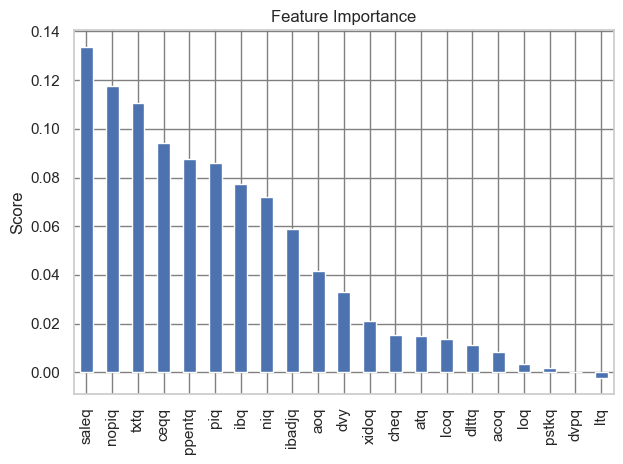

In [17]:
nn6 = nn6_importances_1 /(nn6_importances_1.sum())
fig, ax4 = plt.subplots()
nn6.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 9. LSTM Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
date_list_1 = date_list[:-12]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_LSTM_Quintile_Signal = pd.DataFrame(index=list_company)
df_LSTM_Decile_Signal = pd.DataFrame(index=list_company)
df_LSTM_20_Divided_Signal = pd.DataFrame(index=list_company)
df_LSTM_Percentile_Signal = pd.DataFrame(index=list_company)

df_LSTM_Quintile_Signal.index = df_LSTM_Quintile_Signal.index.astype('str')
df_LSTM_Decile_Signal.index = df_LSTM_Decile_Signal.index.astype('str')
df_LSTM_20_Divided_Signal.index = df_LSTM_20_Divided_Signal.index.astype('str')
df_LSTM_Percentile_Signal.index = df_LSTM_Percentile_Signal.index.astype('str')

for i in list_1:
    print(date_list_1[i+12])
    # Baseline LSTM model
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(34, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(12, 21), return_sequences=False)) # Input layer
    model_LSTM.add(Dropout(0.4))
    model_LSTM.add(Dense(27, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_LSTM.add(Dropout(0.3))
    model_LSTM.add(Dense(1, activation='linear')) # Output layer
    model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+13]
    # train the model with 12 months as the rolling window of the data
    train_date = date_list[i:i+12]
    train_date_1 = date_list[i+11]
    # use the model to calculate the 13th month's fair value
    test_date = date_list[i+1:i+13]
    test_date_1 = date_list[i+12]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)
    X_norm.set_index(['cusip'], inplace=True)
    num_cusip = X_norm.index.value_counts().rename('num_cusip')
    X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
    X_norm = X_norm[X_norm.num_cusip == 13]
    X_norm.drop('num_cusip', inplace=True, axis=1)
    X_norm.reset_index(inplace=True)
    cusip_list = list(X_norm['index'].unique())

    X_train = X_norm[X_norm.datadate.isin(train_date)]

    X_test = X_norm[X_norm.datadate.isin(test_date)]

    y_train = y[y.datadate.isin(train_date)]

    y_temp = y[y.datadate == test_date_1]
    y_temp_1 = y_temp.set_index(['cusip'])
    y_temp_1 = y_temp_1.merge(num_cusip, left_index=True, right_index=True)
    y_temp_1 = y_temp_1[y_temp_1.num_cusip == 13]
    y_temp_1.drop('num_cusip', inplace=True, axis=1)
    y_temp_1 = y_temp_1.reindex(cusip_list)

    y_fair = pd.DataFrame()

    for k in cusip_list:

        X_train_1 = X_train[X_train['index'] == k]
        X_train_1 = X_train_1.iloc[:, 2:]
        X_train_1 = np.array(X_train_1)
        X_train_1 = tf.expand_dims(X_train_1, axis=0)

        y_train_1 = y_train[y_train.cusip == k]
        y_train_1 = y_train_1.iloc[:, 2]
        y_train_1 = np.array(y_train_1)
        y_train_1 = tf.expand_dims(y_train_1, axis=0)

        model_LSTM.fit(X_train_1, y_train_1, epochs=50, callbacks=[callback])

    for h in cusip_list:

        X_test_1 = X_test[X_test['index'] == h]
        X_test_1 = X_test_1.iloc[:, 2:]
        X_test_1 = np.array(X_test_1)
        X_test_1 = tf.expand_dims(X_test_1, axis=0)

        y_test = y_temp[y_temp.cusip == h]
        y_test = y_test.iloc[:, 2]
        y_test = np.array(y_test)
        y_pred = model_LSTM.predict(X_test_1)
        y_fair = pd.concat([y_fair, pd.DataFrame(y_pred)], axis=0)

    y_fair = pd.DataFrame(y_fair)
    y_fair.rename(columns={0 :'Fair_Value'}, inplace=True)
    y_fair = y_fair.reset_index().drop('index', axis=1)
    y_final = pd.concat([y_temp_1.reset_index(), y_fair], axis=1)
    y_final.set_index('index', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date_1), how='left')
    df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date_1), how='left')
    df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date_1), how='left')
    df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date_1), how='left')
    print('{} is done'.format(date_list_1[i+12]))

### (1) Performance Analysis

In [169]:
cusip_1 = pd.Series(df_returns.T.index).rename('cusip')
df_LSTM_Quintile_Signal = pd.read_csv('df_LSTM_quintile_9904_2205_300.csv')
df_LSTM_Decile_Signal = pd.read_csv('df_LSTM_decile_9904_2205_300.csv')
df_LSTM_20_Divided_Signal = pd.read_csv('df_LSTM_20_9904_2205_300.csv')
df_LSTM_Percentile_Signal = pd.read_csv('df_LSTM_percentile_9904_2205_300.csv')

df_LSTM_Quintile_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_Decile_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_20_Divided_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_Percentile_Signal.drop('Unnamed: 0', axis=1, inplace=True)

df_LSTM_Quintile_Signal.columns = date_list[12:]
df_LSTM_Decile_Signal.columns = date_list[12:]
df_LSTM_20_Divided_Signal.columns = date_list[12:]
df_LSTM_Percentile_Signal.columns = date_list[12:]

df_LSTM_Quintile_Signal = pd.concat([cusip_1, df_LSTM_Quintile_Signal], axis=1)
df_LSTM_Decile_Signal = pd.concat([cusip_1, df_LSTM_Decile_Signal], axis=1)
df_LSTM_20_Divided_Signal = pd.concat([cusip_1, df_LSTM_20_Divided_Signal], axis=1)
df_LSTM_Percentile_Signal = pd.concat([cusip_1, df_LSTM_Percentile_Signal], axis=1)

df_LSTM_Quintile_Signal.set_index('cusip', inplace=True)
df_LSTM_Decile_Signal.set_index('cusip', inplace=True)
df_LSTM_20_Divided_Signal.set_index('cusip', inplace=True)
df_LSTM_Percentile_Signal.set_index('cusip', inplace=True)

df_LSTM_Quintile_Signal.index = df_LSTM_Quintile_Signal.index.astype('str')
df_LSTM_Decile_Signal.index = df_LSTM_Decile_Signal.index.astype('str')
df_LSTM_20_Divided_Signal.index = df_LSTM_20_Divided_Signal.index.astype('str')
df_LSTM_Percentile_Signal.index = df_LSTM_Percentile_Signal.index.astype('str')

In [170]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_LSTM_Quintile_Signal = pd.concat([df_199804_199809, df_LSTM_Quintile_Signal, df_202206], axis=1)
df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.fillna(0).T
df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.shift(1).dropna()

df_LSTM_Decile_Signal = pd.concat([df_199804_199809, df_LSTM_Decile_Signal, df_202206], axis=1)
df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.fillna(0).T
df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.shift(1).dropna()

df_LSTM_20_Divided_Signal = pd.concat([df_199804_199809, df_LSTM_20_Divided_Signal, df_202206], axis=1)
df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.fillna(0).T
df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.shift(1).dropna()

df_LSTM_Percentile_Signal = pd.concat([df_199804_199809, df_LSTM_Percentile_Signal, df_202206], axis=1)
df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.fillna(0).T
df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.shift(1).dropna()

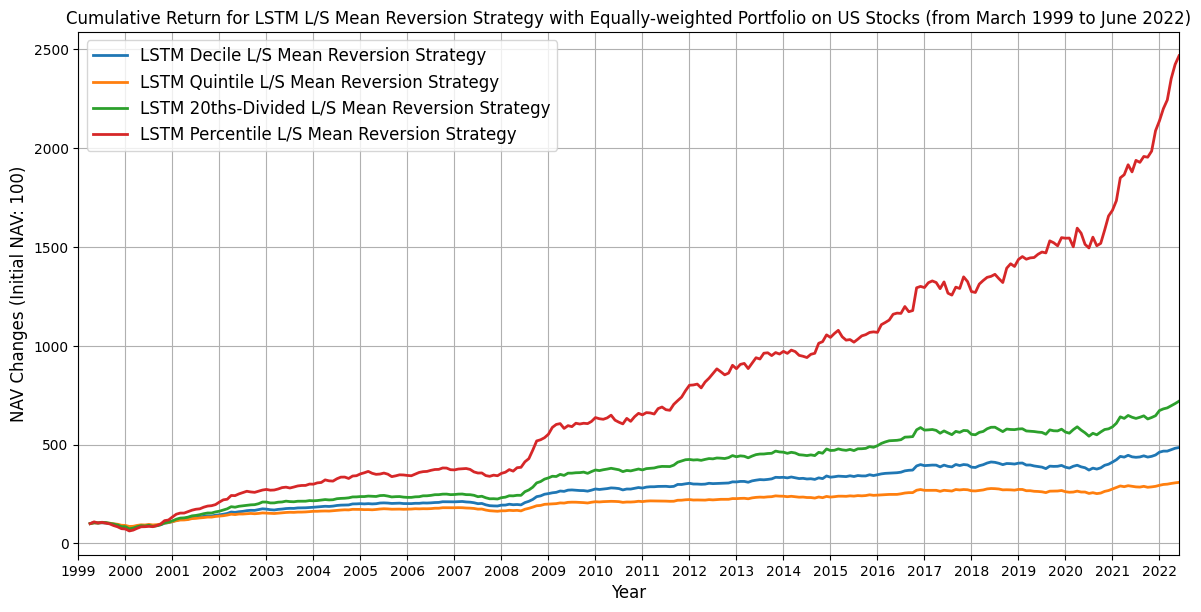

In [171]:
cum_LSTM_Q_strategy_return = get_price_df(df_LSTM_Quintile_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_D_strategy_return = get_price_df(df_LSTM_Decile_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_T_strategy_return = get_price_df(df_LSTM_20_Divided_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_P_strategy_return = get_price_df(df_LSTM_Percentile_Signal, df_returns, nav=100, model_type='LSTM')

cum_LSTM_strategy_return = pd.concat([cum_LSTM_D_strategy_return.rename('LSTM Decile L/S Mean Reversion Strategy'),
                                     cum_LSTM_Q_strategy_return.rename('LSTM Quintile L/S Mean Reversion Strategy'),
                                     cum_LSTM_T_strategy_return.rename('LSTM 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_LSTM_P_strategy_return.rename('LSTM Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_LSTM_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for LSTM L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from March 1999 to June 2022)', fontsize=12)
plt.show()

In [235]:
# Performance Stats
stats_LSTM_Q = get_performance_stats(cum_LSTM_Q_strategy_return, rfr=risk_free_rate_df, label='LSTM Quintile (Initial NAV: 100)')
stats_LSTM_D = get_performance_stats(cum_LSTM_D_strategy_return, rfr=risk_free_rate_df, label='LSTM Decile (Initial NAV: 100)')
stats_LSTM_T = get_performance_stats(cum_LSTM_T_strategy_return, rfr=risk_free_rate_df, label='LSTM 20ths (Initial NAV: 100)')
stats_LSTM_P = get_performance_stats(cum_LSTM_P_strategy_return, rfr=risk_free_rate_df, label='LSTM Percentile (Initial NAV: 100)')
LSTM_stats = pd.concat([stats_LSTM_Q, stats_LSTM_D, stats_LSTM_T, stats_LSTM_P], axis=0)
display(LSTM_stats)

Total Return  Avg Return   Rf Rate  \
LSTM Quintile (Initial NAV: 100)        2.087045    0.049677  0.018682   
LSTM Decile (Initial NAV: 100)          3.849807    0.070270  0.018682   
LSTM 20ths (Initial NAV: 100)           6.195353    0.088585  0.018682   
LSTM Percentile (Initial NAV: 100)     23.673153    0.147838  0.018682   

                                    Volatility  Sharpe Ratio  Skewness  \
LSTM Quintile (Initial NAV: 100)      0.052387      0.591642  0.129980   
LSTM Decile (Initial NAV: 100)        0.068806      0.749763 -0.162416   
LSTM 20ths (Initial NAV: 100)         0.084896      0.823393 -0.247919   
LSTM Percentile (Initial NAV: 100)    0.116095      1.112498  0.470442   

                                    Kurtosis          HWM    HWM date  \
LSTM Quintile (Initial NAV: 100)    1.877523   308.704538  2022-06-30   
LSTM Decile (Initial NAV: 100)      4.360367   484.980742  2022-06-30   
LSTM 20ths (Initial NAV: 100)       5.839995   719.535328  2022-06-30   
LSTM Percentile (Initial NAV: 100)  4.540388  2467.315313  2022-06-30   

                                         MDD   Peak Date Trough Date  \
LSTM Quintile (Initial NAV: 100)    0.093175  2018-06-30  2020-09-30   
LSTM Decile (Initial NAV: 100)      0.099320  2018-06-30  2020-07-31   
LSTM 20ths (Initial NAV: 100)       0.080493  2020-04-30  2020-07-31   
LSTM Percentile (Initial NAV: 100)  0.062825  2020-04-30  2020-07-31   

                                   Recession Date  MDD Duration  
LSTM Quintile (Initial NAV: 100)       2021-02-28           974  
LSTM Decile (Initial NAV: 100)         2021-02-28           974  
LSTM 20ths (Initial NAV: 100)          2021-02-28           304  
LSTM Percentile (Initial NAV: 100)     2020-12-31           245

In [236]:
stats2_LSTM_Q = get_performance_stats_2(df_LSTM_Quintile_Signal, df_returns, df_market_cap, label='LSTM Quintile', model_type='LSTM')
stats2_LSTM_D = get_performance_stats_2(df_LSTM_Decile_Signal, df_returns, df_market_cap, label='LSTM Decile', model_type='LSTM')
stats2_LSTM_T = get_performance_stats_2(df_LSTM_20_Divided_Signal, df_returns, df_market_cap, label='LSTM 20ths', model_type='LSTM')
stats2_LSTM_P = get_performance_stats_2(df_LSTM_Percentile_Signal, df_returns, df_market_cap, label='LSTM Percentile', model_type='LSTM')
LSTM_stats2 = pd.concat([stats2_LSTM_Q, stats2_LSTM_D, stats2_LSTM_T, stats2_LSTM_P], axis=0)
display(LSTM_stats2)

Total Return  Avg Monthly Return  \
LSTM Quintile (Long & Short)        2.087045            0.004048   
(Long Position)                    74.273787            0.015608   
(Short Position)                   -0.933762           -0.009682   
LSTM Decile (Long & Short)          3.849807            0.005675   
(Long Position)                   196.882870            0.019133   
(Short Position)                   -0.939169           -0.009984   
LSTM 20ths (Long & Short)           6.195353            0.007098   
(Long Position)                   518.566489            0.022665   
(Short Position)                   -0.950084           -0.010686   
LSTM Percentile (Long & Short)     23.673153            0.011556   
(Long Position)                  2804.477853            0.028865   
(Short Position)                   -0.898161           -0.008154   

                                 Avg Mkt Cap  Fraction>0  \
LSTM Quintile (Long & Short)    2.657858e+10    0.568966   
(Long Position)                 1.861709e+09    0.637931   
(Short Position)                5.077376e+10    0.372414   
LSTM Decile (Long & Short)      4.109825e+10    0.600000   
(Long Position)                 1.521100e+09    0.651724   
(Short Position)                7.936403e+10    0.362069   
LSTM 20ths (Long & Short)       6.697533e+10    0.617241   
(Long Position)                 1.435077e+09    0.668966   
(Short Position)                1.291953e+11    0.372414   
LSTM Percentile (Long & Short)  2.113307e+11    0.631034   
(Long Position)                 1.819045e+09    0.703448   
(Short Position)                3.995079e+11    0.389655   

                                + Return Stocks (Avg)  - Return Stocks (Avg)  \
LSTM Quintile (Long & Short)                 0.083051              -0.076613   
(Long Position)                              0.086847              -0.070305   
(Short Position)                             0.065125              -0.071403   
LSTM Decile (Long & Short)                   0.085280              -0.076995   
(Long Position)                              0.089156              -0.067513   
(Short Position)                             0.067147              -0.074200   
LSTM 20ths (Long & Short)                    0.085800              -0.076185   
(Long Position)                              0.089235              -0.063917   
(Short Position)                             0.067788              -0.076009   
LSTM Percentile (Long & Short)               0.087087              -0.074591   
(Long Position)                              0.089705              -0.057636   
(Short Position)                             0.068981              -0.077545   

                                Odds Ratio  Odds Ratio 98-10  \
LSTM Quintile (Long & Short)      0.501329          0.510163   
(Long Position)                   0.551843          0.560298   
(Short Position)                  0.452040          0.461489   
LSTM Decile (Long & Short)        0.506566          0.516177   
(Long Position)                   0.558029          0.569655   
(Short Position)                  0.457051          0.465204   
LSTM 20ths (Long & Short)         0.512604          0.525403   
(Long Position)                   0.567492          0.588053   
(Short Position)                  0.460816          0.467038   
LSTM Percentile (Long & Short)    0.534528          0.541563   
(Long Position)                   0.600759          0.620000   
(Short Position)                  0.475339          0.472150   

                                Odds Ratio 11-22  Transactions/Month  
LSTM Quintile (Long & Short)            0.494641          349.521127  
(Long Position)                         0.545470          147.563380  
(Short Position)                        0.444854          208.802817  
LSTM Decile (Long & Short)              0.499314          220.443662  
(Long Position)                         0.549331           93.890845  
(Short Position)                        0.450849          127.7500

In [57]:
cum_LSTM_Q_strategy_return_L = get_price_df(df_LSTM_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_LSTM_Q_strategy_return_S = get_price_df(df_LSTM_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_LSTM_D_strategy_return_L = get_price_df(df_LSTM_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_LSTM_D_strategy_return_S = get_price_df(df_LSTM_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_LSTM_Q_L = get_performance_stats(cum_LSTM_Q_strategy_return_L, rfr=risk_free_rate_df, label='LSTM Quintile L (Initial NAV: 100)')
stats_LSTM_Q_S = get_performance_stats(cum_LSTM_Q_strategy_return_S, rfr=risk_free_rate_df, label='LSTM Quintile S (Initial NAV: 100)')
stats_LSTM_D_L = get_performance_stats(cum_LSTM_D_strategy_return_L, rfr=risk_free_rate_df, label='LSTM Decile L (Initial NAV: 100)')
stats_LSTM_D_S = get_performance_stats(cum_LSTM_D_strategy_return_S, rfr=risk_free_rate_df, label='LSTM Decile S (Initial NAV: 100)')
LSTM_stats3 = pd.concat([stats_LSTM_Q_L, stats_LSTM_Q_S, stats_LSTM_D_L, stats_LSTM_D_S], axis=0)
display(LSTM_stats3)

Total Return  Avg Return   Rf Rate  \
LSTM Quintile L (Initial NAV: 100)     74.273787    0.204248  0.018682   
LSTM Quintile S (Initial NAV: 100)      6.535888    0.090752  0.018682   
LSTM Decile L (Initial NAV: 100)      196.882870    0.255366  0.018682   
LSTM Decile S (Initial NAV: 100)        6.148361    0.088279  0.018682   

                                    Volatility  Sharpe Ratio  Skewness  \
LSTM Quintile L (Initial NAV: 100)    0.172630      1.074932  0.073729   
LSTM Quintile S (Initial NAV: 100)    0.170555      0.422561 -0.422955   
LSTM Decile L (Initial NAV: 100)      0.170143      1.391085  0.320546   
LSTM Decile S (Initial NAV: 100)      0.186981      0.372209 -0.232251   

                                    Kurtosis           HWM    HWM date  \
LSTM Quintile L (Initial NAV: 100)  0.604037   8552.245930  2021-12-31   
LSTM Quintile S (Initial NAV: 100)  1.061229   1017.564037  2021-10-31   
LSTM Decile L (Initial NAV: 100)    0.646821  22369.690618  2021-10-31   
LSTM Decile S (Initial NAV: 100)    1.548567   1007.815961  2021-10-31   

                                         MDD   Peak Date Trough Date  \
LSTM Quintile L (Initial NAV: 100)  0.235709  2019-12-31  2020-03-31   
LSTM Quintile S (Initial NAV: 100)  0.259419  2021-10-31  2022-06-30   
LSTM Decile L (Initial NAV: 100)    0.115397  2021-10-31  2022-06-30   
LSTM Decile S (Initial NAV: 100)    0.290708  2021-10-31  2022-06-30   

                                    Recession Date    MDD Duration  
LSTM Quintile L (Initial NAV: 100)      2020-07-31             213  
LSTM Quintile S (Initial NAV: 100)  Yet to recover  Yet to recover  
LSTM Decile L (Initial NAV: 100)    Yet to recover  Yet to recover  
LSTM Decile S (Initial NAV: 100)    Yet to recover  Yet to recover

### (2) Hyperparameters Tuning

In [176]:
validation_date = date_list[:12]

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_norm.set_index(['cusip'], inplace=True)
num_cusip = X_norm.index.value_counts().rename('num_cusip')
X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
X_norm = X_norm[X_norm.num_cusip == 12]
X_norm.drop('num_cusip', inplace=True, axis=1)
X_norm.reset_index(inplace=True)
cusip_list = list(X_norm['index'].unique())

y_temp = y[y.datadate.isin(validation_date)]
y_temp.set_index(['cusip'], inplace=True)
num_cusip = y_temp.index.value_counts().rename('num_cusip')
y_temp = y_temp.merge(num_cusip, left_index=True, right_index=True)
y_temp = y_temp[y_temp.num_cusip == 12]
y_temp.drop('num_cusip', inplace=True, axis=1)
y_temp.reset_index(inplace=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
def creating_LSTM(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value = 40, step = 1)
    unit2 = hp.Int('lay1', min_value=1, max_value = 40, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(LSTM(unit1, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(12, 21), return_sequences=False))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
for k in cusip_list:
    X_train_1 = X_norm[X_norm['index'] == k]
    X_validation = X_train_1.iloc[:, 2:]
    X_validation = np.array(X_validation)
    X_validation = tf.expand_dims(X_validation, axis=0)

    y_train_1 = y_temp[y_temp['index'] == k]
    y_validation = y_train_1.iloc[:, 2]
    y_validation = np.array(y_validation)
    y_validation = tf.expand_dims(y_validation, axis=0)

    tuner_lstm = kt.Hyperband(creating_LSTM, objective='val_loss', max_epochs=10, project_name='lstm_tuning', overwrite=True)
    tuner_lstm.search(X_validation, y_validation, epochs=1, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=1)

In [ ]:
"""
Hyperparameters:
LSTM layer: 34
lay1: 27
dropout1: 0.4
dropout2: 0.3
regularization: 0.01
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
date_list_2 = date_list[:-12]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

# Baseline LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(34, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(12, 21), return_sequences=False)) # Input layer
model_LSTM.add(Dropout(0.4))
model_LSTM.add(Dense(27, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(1, activation='linear')) # Output layer
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = date_list_2[0:13]
# train the model with 12 months as the rolling window of the data
train_date = date_list_2[0:12]
train_date_1 = date_list_2[11]
# use the model to calculate the 13th month's fair value
test_date = date_list_2[1:13]
test_date_1 = date_list_2[12]

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_norm.set_index(['cusip'], inplace=True)
num_cusip = X_norm.index.value_counts().rename('num_cusip')
X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
X_norm = X_norm[X_norm.num_cusip == 13]
X_norm.drop('num_cusip', inplace=True, axis=1)
X_norm.reset_index(inplace=True)
cusip_list = list(X_norm['index'].unique())

X_train = X_norm[X_norm.datadate.isin(train_date)]

X_test = X_norm[X_norm.datadate.isin(test_date)]

y_train = y[y.datadate.isin(train_date)]

y_temp = y[y.datadate == test_date_1]

y_fair = pd.DataFrame()

for k in cusip_list:
  X_train_1 = X_train[X_train['index'] == k]
  X_train_1 = X_train_1.iloc[:, 2:]
  X_train_1 = np.array(X_train_1)
  X_train_1 = tf.expand_dims(X_train_1, axis=0)

  y_train_1 = y_train[y_train.cusip == k]
  y_train_1 = y_train_1.iloc[:, 2]
  y_train_1 = np.array(y_train_1)
  y_train_1 = tf.expand_dims(y_train_1, axis=0)

  model_LSTM.fit(X_train_1, y_train_1, epochs=5, callbacks=[callback])

In [ ]:
char_list = list(df_target_features.columns[1:])
feature_importance_all = pd.DataFrame(index=char_list)

for i in cusip_list:
  print(i)
  X_test_1 = X_test[X_test['index'] == i]
  X_test_1 = X_test_1.iloc[:, 2:]
  y_temp_1 = y_temp[y_temp.cusip == i]
  y_temp_1 = y_temp_1.iloc[:, 2]
  y_test_1 = tf.expand_dims(y_temp_1, axis=0)
  difference_list = []

  for char in char_list:
    temp_test = X_test_1.copy()
    temp_test[char] = 0
    temp_test = tf.expand_dims(temp_test, axis=0)
    temp_predict = pd.DataFrame(model_LSTM.predict(temp_test, steps=1))
    temp_mse = (temp_predict.iloc[0,0] - y_temp_1.reset_index(drop=True)[0]) ** 2
    difference_list.append(temp_mse)
  variable_importance = pd.DataFrame([char_list, difference_list]).T
  variable_importance.columns = ['characteristics','importance']
  variable_importance['importance'] = variable_importance['importance']/(variable_importance['importance'].sum())
  variable_importance = variable_importance.sort_values('importance',ascending=False)
  variable_importance.reset_index(drop=True,inplace=True)
  variable_importance = variable_importance.set_index('characteristics')
  variable_importance.rename(columns={'importance': i}, inplace=True)
  feature_importance_all = feature_importance_all.merge(variable_importance, how='left', left_index=True, right_index=True)

In [154]:
char_list = list(df_target_features.columns[1:])
feature_importance_all = pd.read_csv('feature_importance_LSTM.csv', index_col=0)
feature_importance_all['mean'] = feature_importance_all.mean(axis=1)

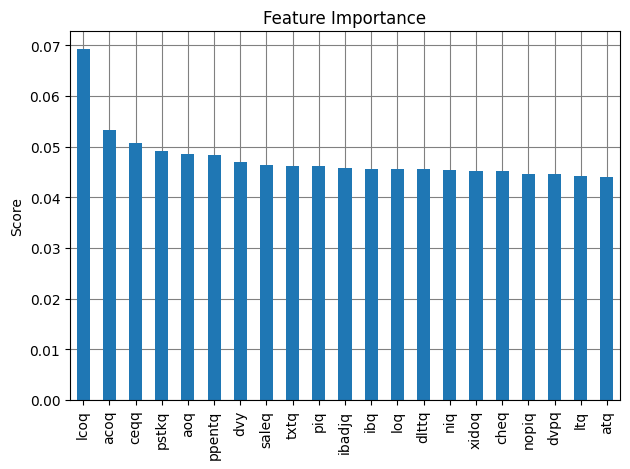

In [155]:
fig, ax1 = plt.subplots()
feature_importance_all['mean'].sort_values(ascending=False).plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance')
ax1.set_ylabel('Score')
fig.tight_layout()
plt.show()

## Model Comparison

### (1) Quintile Strategy

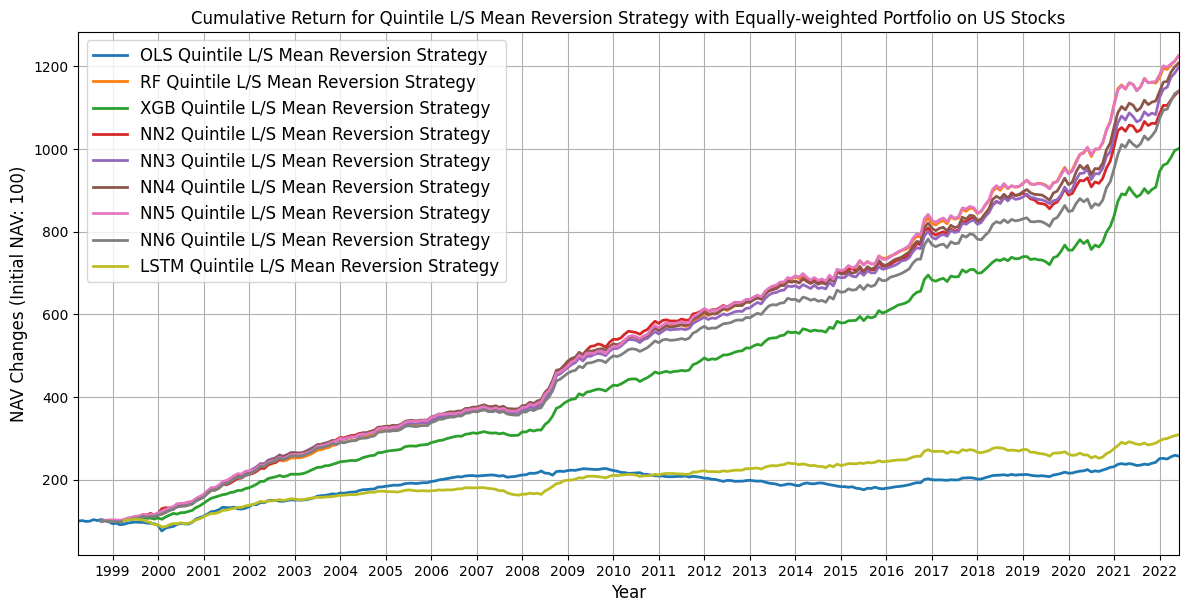

In [107]:
cum_Q_strategy_return = pd.concat([cum_OLS_Q_strategy_return.rename('OLS Quintile L/S Mean Reversion Strategy'),
                                     cum_RF_Q_strategy_return.rename('RF Quintile L/S Mean Reversion Strategy'),
                                     cum_XGB_Q_strategy_return.rename('XGB Quintile L/S Mean Reversion Strategy'),
                                     cum_NN2_Q_strategy_return.rename('NN2 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN3_Q_strategy_return.rename('NN3 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN4_Q_strategy_return.rename('NN4 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN5_Q_strategy_return.rename('NN5 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN6_Q_strategy_return.rename('NN6 Quintile L/S Mean Reversion Strategy'),
                                     cum_LSTM_Q_strategy_return.rename('LSTM Quintile L/S Mean Reversion Strategy')], axis=1)

ax_Q = cum_Q_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for Quintile L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks', fontsize=12)
plt.show()

In [237]:
# Performance Stats
Q_stats = pd.concat([stats_OLS_Q, stats_RF_Q, stats_XGB_Q, stats_NN2_Q, stats_NN3_Q, stats_NN4_Q, stats_NN5_Q, stats_NN6_Q, stats_LSTM_Q], axis=0)
display(Q_stats)

Total Return  Avg Return   Rf Rate  \
OLS Quintile (Initial NAV: 100)          1.569753    0.039687  0.018682   
RF Quintile (Initial NAV: 100)          11.252236    0.111270  0.018682   
XGBoost Quintile (Initial NAV: 100)      9.003108    0.101821  0.018682   
NN2 Quintile (Initial NAV: 100)         10.388719    0.107856  0.018682   
NN3 Quintile (Initial NAV: 100)         10.972314    0.110189  0.018682   
NN4 Quintile (Initial NAV: 100)         11.073966    0.110584  0.018682   
NN5 Quintile (Initial NAV: 100)         11.249372    0.111259  0.018682   
NN6 Quintile (Initial NAV: 100)         10.397811    0.107893  0.018682   
LSTM Quintile (Initial NAV: 100)         2.087045    0.049677  0.018682   

                                     Volatility  Sharpe Ratio  Skewness  \
OLS Quintile (Initial NAV: 100)        0.064070      0.327844 -1.192248   
RF Quintile (Initial NAV: 100)         0.047048      1.967934  0.716797   
XGBoost Quintile (Initial NAV: 100)    0.048269      1.722397  0.545194   
NN2 Quintile (Initial NAV: 100)        0.051103      1.744966  1.316263   
NN3 Quintile (Initial NAV: 100)        0.050041      1.828627  0.834326   
NN4 Quintile (Initial NAV: 100)        0.049570      1.853966  0.886015   
NN5 Quintile (Initial NAV: 100)        0.047883      1.933376  0.724075   
NN6 Quintile (Initial NAV: 100)        0.048714      1.831318  0.835081   
LSTM Quintile (Initial NAV: 100)       0.052387      0.591642  0.129980   

                                      Kurtosis          HWM    HWM date  \
OLS Quintile (Initial NAV: 100)      19.417478   259.092453  2022-05-31   
RF Quintile (Initial NAV: 100)        0.960605  1225.223567  2022-06-30   
XGBoost Quintile (Initial NAV: 100)   1.023506  1000.310755  2022-06-30   
NN2 Quintile (Initial NAV: 100)       4.626609  1138.871882  2022-06-30   
NN3 Quintile (Initial NAV: 100)       1.347156  1197.231356  2022-06-30   
NN4 Quintile (Initial NAV: 100)       1.350419  1207.396572  2022-06-30   
NN5 Quintile (Initial NAV: 100)       0.742007  1224.937178  2022-06-30   
NN6 Quintile (Initial NAV: 100)       1.105527  1139.781067  2022-06-30   
LSTM Quintile (Initial NAV: 100)      1.877523   308.704538  2022-06-30   

                                          MDD   Peak Date Trough Date  \
OLS Quintile (Initial NAV: 100)      0.226965  2009-11-30  2015-07-31   
RF Quintile (Initial NAV: 100)       0.020860  2020-06-30  2020-07-31   
XGBoost Quintile (Initial NAV: 100)  0.030351  2020-04-30  2020-07-31   
NN2 Quintile (Initial NAV: 100)      0.043331  2018-10-31  2019-08-31   
NN3 Quintile (Initial NAV: 100)      0.026859  2020-06-30  2020-07-31   
NN4 Quintile (Initial NAV: 100)      0.028728  2019-02-28  2019-08-31   
NN5 Quintile (Initial NAV: 100)      0.023069  2019-02-28  2019-08-31   
NN6 Quintile (Initial NAV: 100)      0.026024  2020-04-30  2020-07-31   
LSTM Quintile (Initial NAV: 100)     0.093175  2018-06-30  2020-09-30   

                                    Recession Date  MDD Duration  
OLS Quintile (Initial NAV: 100)         2020-12-31          4049  
RF Quintile (Initial NAV: 100)          2020-10-31           123  
XGBoost Quintile (Initial NAV: 100)     2020-11-30           214  
NN2 Quintile (Initial NAV: 100)         2019-12-31           426  
NN3 Quintile (Initial NAV: 100)         2020-10-31           123  
NN4 Quintile (Initial NAV: 100)         2019-11-30           275  
NN5 Quintile (Initial NAV: 100)         2019-11-30           275  
NN6 Quintile (Initial NAV: 100)         2020-11-30           214  
LSTM Quintile (Initial NAV: 100)        2021-02-28           974

In [238]:
Q_stats2 = pd.concat([stats2_OLS_Q, stats2_RF_Q, stats2_XGB_Q, stats2_NN2_Q, stats2_NN3_Q, stats2_NN4_Q, stats2_NN5_Q, stats2_NN6_Q, stats2_LSTM_Q], axis=0)
display(Q_stats2)

Total Return  Avg Monthly Return  \
OLS Quintile (Long & Short)          1.569753            0.003249   
(Long Position)                    252.160063            0.019199   
(Short Position)                    -0.987987           -0.015080   
RF Quintile (Long & Short)          11.252236            0.008831   
(Long Position)                   1204.797880            0.025207   
(Short Position)                    -0.935349           -0.009564   
XGBoost Quintile (Long & Short)      9.003108            0.008113   
(Long Position)                   1003.235247            0.024549   
(Short Position)                    -0.950138           -0.010466   
NN2 Quintile (Long & Short)         10.388719            0.008572   
(Long Position)                   1118.202751            0.024939   
(Short Position)                    -0.941133           -0.009889   
NN3 Quintile (Long & Short)         10.972314            0.008749   
(Long Position)                   1311.086156            0.025511   
(Short Position)                    -0.945341           -0.010147   
NN4 Quintile (Long & Short)         11.073966            0.008779   
(Long Position)                   1319.789306            0.025535   
(Short Position)                    -0.944813           -0.010114   
NN5 Quintile (Long & Short)         11.249372            0.008830   
(Long Position)                   1234.259767            0.025294   
(Short Position)                    -0.937405           -0.009676   
NN6 Quintile (Long & Short)         10.397811            0.008575   
(Long Position)                   1299.683033            0.025479   
(Short Position)                    -0.950711           -0.010506   
LSTM Quintile (Long & Short)         2.087045            0.004048   
(Long Position)                     74.273787            0.015608   
(Short Position)                    -0.933762           -0.009682   

                                  Avg Mkt Cap  Fraction>0  \
OLS Quintile (Long & Short)      2.414526e+10    0.589655   
(Long Position)                  4.008645e+09    0.679310   
(Short Position)                 4.301742e+10    0.344828   
RF Quintile (Long & Short)       3.688582e+10    0.731034   
(Long Position)                  6.247204e+08    0.706897   
(Short Position)                 7.031321e+10    0.382759   
XGBoost Quintile (Long & Short)  3.117680e+10    0.737931   
(Long Position)                  1.761964e+09    0.710345   
(Short Position)                 5.845532e+10    0.382759   
NN2 Quintile (Long & Short)      3.251328e+10    0.689655   
(Long Position)                  1.655647e+09    0.706897   
(Short Position)                 6.108494e+10    0.379310   
NN3 Quintile (Long & Short)      3.277610e+10    0.713793   
(Long Position)                  1.105542e+09    0.703448   
(Short Position)                 6.202225e+10    0.379310   
NN4 Quintile (Long & Short)      3.549626e+10    0.710345   
(Long Position)                  7.176343e+08    0.710345   
(Short Position)                 6.758440e+10    0.372414   
NN5 Quintile (Long & Short)      3.867094e+10    0.713793   
(Long Position)                  5.682630e+08    0.696552   
(Short Position)                 7.380599e+10    0.379310   
NN6 Quintile (Long & Short)      3.441155e+10    0.713793   
(Long Position)                  9.018238e+08    0.696552   
(Short Position)                 6.531896e+10    0.389655   
LSTM Quintile (Long & Short)     2.657858e+10    0.568966   
(Long Position)                  1.861709e+09    0.637931   
(Short Position)                 5.077376e+10    0.372414   

                                 + Return Stocks (Avg)  - Return Stocks (Avg)  \
OLS Quintile (Long & Short)                   0.088443              -0.084851   
(Long Position)                               0.088877              -0.068285   
(Short Position)                              0.073872              -0.087602   
RF Quintile (Long & Short)                    0.090477             

### (2) Decile Strategy

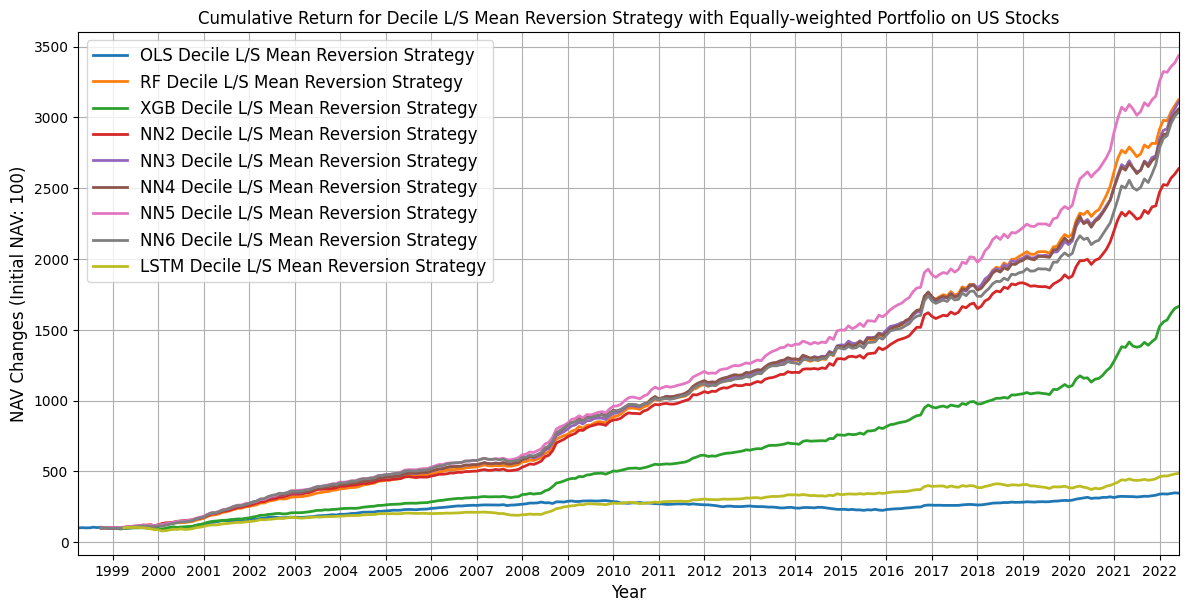

In [110]:
cum_D_strategy_return = pd.concat([cum_OLS_D_strategy_return.rename('OLS Decile L/S Mean Reversion Strategy'),
                                     cum_RF_D_strategy_return.rename('RF Decile L/S Mean Reversion Strategy'),
                                     cum_XGB_D_strategy_return.rename('XGB Decile L/S Mean Reversion Strategy'),
                                     cum_NN2_D_strategy_return.rename('NN2 Decile L/S Mean Reversion Strategy'),
                                     cum_NN3_D_strategy_return.rename('NN3 Decile L/S Mean Reversion Strategy'),
                                     cum_NN4_D_strategy_return.rename('NN4 Decile L/S Mean Reversion Strategy'),
                                     cum_NN5_D_strategy_return.rename('NN5 Decile L/S Mean Reversion Strategy'),
                                     cum_NN6_D_strategy_return.rename('NN6 Decile L/S Mean Reversion Strategy'),
                                     cum_LSTM_D_strategy_return.rename('LSTM Decile L/S Mean Reversion Strategy')], axis=1)

ax_D = cum_D_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for Decile L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks', fontsize=12)
plt.show()

In [239]:
# Performance Stats
D_stats = pd.concat([stats_OLS_D, stats_RF_D, stats_XGB_D, stats_NN2_D, stats_NN3_D, stats_NN4_D, stats_NN5_D, stats_NN6_D, stats_LSTM_D], axis=0)
display(D_stats)

Total Return  Avg Return   Rf Rate  \
OLS Decile (Initial NAV: 100)          2.454319    0.052448  0.018682   
RF Decile (Initial NAV: 100)          30.244258    0.155946  0.018682   
XGBoost Decile (Initial NAV: 100)     15.639149    0.125683  0.018682   
NN2 Decile (Initial NAV: 100)         25.364903    0.147711  0.018682   
NN3 Decile (Initial NAV: 100)         30.093040    0.155710  0.018682   
NN4 Decile (Initial NAV: 100)         29.592416    0.154921  0.018682   
NN5 Decile (Initial NAV: 100)         33.355523    0.160576  0.018682   
NN6 Decile (Initial NAV: 100)         29.363385    0.154555  0.018682   
LSTM Decile (Initial NAV: 100)         3.849807    0.070270  0.018682   

                                   Volatility  Sharpe Ratio  Skewness  \
OLS Decile (Initial NAV: 100)        0.065299      0.517086 -0.399121   
RF Decile (Initial NAV: 100)         0.055447      2.475584  0.984646   
XGBoost Decile (Initial NAV: 100)    0.060705      1.762636  0.384349   
NN2 Decile (Initial NAV: 100)        0.057262      2.253324  0.683546   
NN3 Decile (Initial NAV: 100)        0.058478      2.343220  0.905921   
NN4 Decile (Initial NAV: 100)        0.061530      2.214166  0.971289   
NN5 Decile (Initial NAV: 100)        0.057318      2.475529  0.870641   
NN6 Decile (Initial NAV: 100)        0.062840      2.162212  1.105857   
LSTM Decile (Initial NAV: 100)       0.068806      0.749763 -0.162416   

                                    Kurtosis          HWM    HWM date  \
OLS Decile (Initial NAV: 100)      12.497734   347.718923  2022-05-31   
RF Decile (Initial NAV: 100)        1.989696  3124.425833  2022-06-30   
XGBoost Decile (Initial NAV: 100)   2.176764  1663.914852  2022-06-30   
NN2 Decile (Initial NAV: 100)       3.337130  2636.490328  2022-06-30   
NN3 Decile (Initial NAV: 100)       1.822998  3109.304005  2022-06-30   
NN4 Decile (Initial NAV: 100)       1.804169  3059.241598  2022-06-30   
NN5 Decile (Initial NAV: 100)       1.639022  3435.552320  2022-06-30   
NN6 Decile (Initial NAV: 100)       2.460501  3036.338456  2022-06-30   
LSTM Decile (Initial NAV: 100)      4.360367   484.980742  2022-06-30   

                                        MDD   Peak Date Trough Date  \
OLS Decile (Initial NAV: 100)      0.236413  2009-11-30  2015-12-31   
RF Decile (Initial NAV: 100)       0.024444  2021-05-31  2021-07-31   
XGBoost Decile (Initial NAV: 100)  0.038098  2020-04-30  2020-07-31   
NN2 Decile (Initial NAV: 100)      0.023704  2021-05-31  2021-07-31   
NN3 Decile (Initial NAV: 100)      0.028855  2021-05-31  2021-07-31   
NN4 Decile (Initial NAV: 100)      0.034363  2020-04-30  2020-07-31   
NN5 Decile (Initial NAV: 100)      0.024766  2021-05-31  2021-07-31   
NN6 Decile (Initial NAV: 100)      0.027412  2021-05-31  2021-07-31   
LSTM Decile (Initial NAV: 100)     0.099320  2018-06-30  2020-07-31   

                                  Recession Date  MDD Duration  
OLS Decile (Initial NAV: 100)         2019-12-31          3683  
RF Decile (Initial NAV: 100)          2021-09-30           122  
XGBoost Decile (Initial NAV: 100)     2020-10-31           184  
NN2 Decile (Initial NAV: 100)         2021-09-30           122  
NN3 Decile (Initial NAV: 100)         2021-11-30           183  
NN4 Decile (Initial NAV: 100)         2020-10-31           184  
NN5 Decile (Initial NAV: 100)         2021-09-30           122  
NN6 Decile (Initial NAV: 100)         2021-09-30           122  
LSTM Decile (Initial NAV: 100)        2021-02-28           974

In [240]:
D_stats2 = pd.concat([stats2_OLS_D, stats2_RF_D, stats2_XGB_D, stats2_NN2_D, stats2_NN3_D, stats2_NN4_D, stats2_NN5_D, stats2_NN6_D, stats2_LSTM_D], axis=0)
display(D_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
OLS Decile (Long & Short)          2.454319            0.004269  2.848441e+10   
(Long Position)                  616.954315            0.022330  3.197428e+09   
(Short Position)                  -0.991299           -0.016171  5.116239e+10   
RF Decile (Long & Short)          30.244258            0.012150  6.208299e+10   
(Long Position)                 8379.901362            0.032205  5.379736e+08   
(Short Position)                  -0.938749           -0.009751  1.160745e+11   
XGBoost Decile (Long & Short)     15.639149            0.009915  3.922592e+10   
(Long Position)                 4019.861626            0.029548  1.800703e+09   
(Short Position)                  -0.966641           -0.011860  7.292211e+10   
NN2 Decile (Long & Short)         25.364903            0.011547  4.900787e+10   
(Long Position)                 5984.259183            0.030986  1.586582e+09   
(Short Position)                  -0.939122           -0.009773  9.109792e+10   
NN3 Decile (Long & Short)         30.093040            0.012133  4.936544e+10   
(Long Position)                 9000.009826            0.032463  1.056606e+09   
(Short Position)                  -0.947396           -0.010280  9.187197e+10   
NN4 Decile (Long & Short)         29.592416            0.012075  6.021679e+10   
(Long Position)                 8912.793250            0.032428  5.763279e+08   
(Short Position)                  -0.947923           -0.010315  1.124679e+11   
NN5 Decile (Long & Short)         33.355523            0.012487  6.726812e+10   
(Long Position)                 9436.197076            0.032635  4.650007e+08   
(Short Position)                  -0.934927           -0.009541  1.256990e+11   
NN6 Decile (Long & Short)         29.363385            0.012048  5.806127e+10   
(Long Position)                 8902.629168            0.032424  6.977490e+08   
(Short Position)                  -0.949678           -0.010434  1.083075e+11   
LSTM Decile (Long & Short)         3.849807            0.005675  4.109825e+10   
(Long Position)                  196.882870            0.019133  1.521100e+09   
(Short Position)                  -0.939169           -0.009984  7.936403e+10   

                               Fraction>0  + Return Stocks (Avg)  \
OLS Decile (Long & Short)        0.620690               0.089126   
(Long Position)                  0.703448               0.089689   
(Short Position)                 0.355172               0.074000   
RF Decile (Long & Short)         0.762069               0.090811   
(Long Position)                  0.748276               0.103559   
(Short Position)                 0.379310               0.062361   
XGBoost Decile (Long & Short)    0.744828               0.093121   
(Long Position)                  0.720690               0.100335   
(Short Position)                 0.375862               0.070813   
NN2 Decile (Long & Short)        0.755172               0.090896   
(Long Position)                  0.741379               0.102509   
(Short Position)                 0.358621               0.063921   
NN3 Decile (Long & Short)        0.762069               0.092555   
(Long Position)                  0.751724               0.103767   
(Short Position)                 0.393103               0.065275   
NN4 Decile (Long & Short)        0.744828               0.092874   
(Long Position)                  0.748276               0.103491   
(Short Position)                 0.393103               0.066146   
NN5 Decile (Long & Short)        0.772414               0.090633   
(Long Position)                  0.758621               0.103724   
(Short Position)                 0.386207               0.061401   
NN6 Decile (Long & Short)        0.741379               0.093847   
(Long Position)                  0.741379               0.103270   
(Short Position)                 0.389655               0.068594   
LSTM Decile (Long & Short)       0.600000               0.0852

### (3) 20ths Divided Strategy

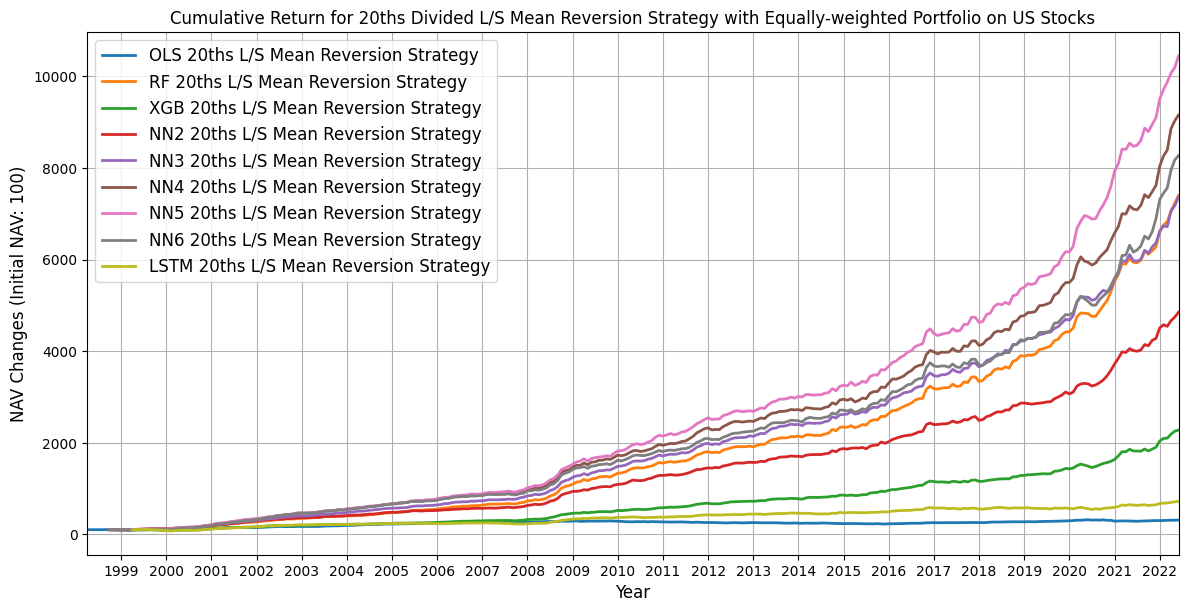

In [113]:
cum_T_strategy_return = pd.concat([cum_OLS_T_strategy_return.rename('OLS 20ths L/S Mean Reversion Strategy'),
                                     cum_RF_T_strategy_return.rename('RF 20ths L/S Mean Reversion Strategy'),
                                     cum_XGB_T_strategy_return.rename('XGB 20ths L/S Mean Reversion Strategy'),
                                     cum_NN2_T_strategy_return.rename('NN2 20ths L/S Mean Reversion Strategy'),
                                     cum_NN3_T_strategy_return.rename('NN3 20ths L/S Mean Reversion Strategy'),
                                     cum_NN4_T_strategy_return.rename('NN4 20ths L/S Mean Reversion Strategy'),
                                     cum_NN5_T_strategy_return.rename('NN5 20ths L/S Mean Reversion Strategy'),
                                     cum_NN6_T_strategy_return.rename('NN6 20ths L/S Mean Reversion Strategy'),
                                     cum_LSTM_T_strategy_return.rename('LSTM 20ths L/S Mean Reversion Strategy')], axis=1)

ax_T = cum_T_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for 20ths Divided L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks', fontsize=12)
plt.show()

In [241]:
# Performance Stats
T_stats = pd.concat([stats_OLS_T, stats_RF_T, stats_XGB_T, stats_NN2_T, stats_NN3_T, stats_NN4_T, stats_NN5_T, stats_NN6_T, stats_LSTM_T], axis=0)
display(T_stats)

Total Return  Avg Return   Rf Rate  \
OLS 20ths (Initial NAV: 100)          2.114006    0.047956  0.018682   
RF 20ths (Initial NAV: 100)          73.017932    0.198696  0.018682   
XGBoost 20ths (Initial NAV: 100)     21.756693    0.140621  0.018682   
NN2 20ths (Initial NAV: 100)         47.490823    0.177539  0.018682   
NN3 20ths (Initial NAV: 100)         72.639271    0.198437  0.018682   
NN4 20ths (Initial NAV: 100)         90.562877    0.209480  0.018682   
NN5 20ths (Initial NAV: 100)        103.512981    0.216236  0.018682   
NN6 20ths (Initial NAV: 100)         81.700114    0.204307  0.018682   
LSTM 20ths (Initial NAV: 100)         6.195353    0.088585  0.018682   

                                  Volatility  Sharpe Ratio  Skewness  \
OLS 20ths (Initial NAV: 100)        0.059712      0.490246 -0.096700   
RF 20ths (Initial NAV: 100)         0.066709      2.698478  0.842081   
XGBoost 20ths (Initial NAV: 100)    0.075617      1.612578 -0.397543   
NN2 20ths (Initial NAV: 100)        0.064869      2.448868  0.407527   
NN3 20ths (Initial NAV: 100)        0.068284      2.632460  0.786990   
NN4 20ths (Initial NAV: 100)        0.071539      2.667041  0.943901   
NN5 20ths (Initial NAV: 100)        0.067420      2.930192  0.699165   
NN6 20ths (Initial NAV: 100)        0.077153      2.405934  1.069353   
LSTM 20ths (Initial NAV: 100)       0.084896      0.823393 -0.247919   

                                  Kurtosis           HWM    HWM date  \
OLS 20ths (Initial NAV: 100)      5.821567    318.267009  2020-06-30   
RF 20ths (Initial NAV: 100)       2.527196   7401.793210  2022-06-30   
XGBoost 20ths (Initial NAV: 100)  5.998801   2275.669348  2022-06-30   
NN2 20ths (Initial NAV: 100)      3.884439   4849.082330  2022-06-30   
NN3 20ths (Initial NAV: 100)      2.888233   7363.927076  2022-06-30   
NN4 20ths (Initial NAV: 100)      1.863831   9156.287657  2022-06-30   
NN5 20ths (Initial NAV: 100)      1.496961  10451.298076  2022-06-30   
NN6 20ths (Initial NAV: 100)      3.005415   8270.011381  2022-06-30   
LSTM 20ths (Initial NAV: 100)     5.839995    719.535328  2022-06-30   

                                       MDD   Peak Date Trough Date  \
OLS 20ths (Initial NAV: 100)      0.230194  2009-02-28  2015-12-31   
RF 20ths (Initial NAV: 100)       0.028851  2017-12-31  2018-01-31   
XGBoost 20ths (Initial NAV: 100)  0.050155  2020-04-30  2020-07-31   
NN2 20ths (Initial NAV: 100)      0.033772  2017-12-31  2018-01-31   
NN3 20ths (Initial NAV: 100)      0.023392  2021-05-31  2021-07-31   
NN4 20ths (Initial NAV: 100)      0.029582  2020-04-30  2020-07-31   
NN5 20ths (Initial NAV: 100)      0.032341  2016-12-31  2017-02-28   
NN6 20ths (Initial NAV: 100)      0.036813  2020-04-30  2020-08-31   
LSTM 20ths (Initial NAV: 100)     0.080493  2020-04-30  2020-07-31   

                                 Recession Date  MDD Duration  
OLS 20ths (Initial NAV: 100)         2020-01-31          3989  
RF 20ths (Initial NAV: 100)          2018-03-31            90  
XGBoost 20ths (Initial NAV: 100)     2020-10-31           184  
NN2 20ths (Initial NAV: 100)         2018-04-30           120  
NN3 20ths (Initial NAV: 100)         2021-09-30           122  
NN4 20ths (Initial NAV: 100)         2020-10-31           184  
NN5 20ths (Initial NAV: 100)         2017-06-30           181  
NN6 20ths (Initial NAV: 100)         2020-10-31           184  
LSTM 20ths (Initial NAV: 100)        2021-02-28           304

In [242]:
T_stats2 = pd.concat([stats2_OLS_T, stats2_RF_T, stats2_XGB_T, stats2_NN2_T, stats2_NN3_T, stats2_NN4_T, stats2_NN5_T, stats2_NN6_T, stats2_LSTM_T], axis=0)
display(T_stats2)

Total Return  Avg Monthly Return   Avg Mkt Cap  \
OLS 20ths (Long & Short)          2.114006            0.003911  3.022323e+10   
(Long Position)                1082.445255            0.024304  2.831480e+09   
(Short Position)                 -0.996221           -0.018987  5.322709e+10   
RF 20ths (Long & Short)          73.017932            0.015217  1.040810e+11   
(Long Position)               50266.556444            0.038713  5.348494e+08   
(Short Position)                 -0.944764           -0.010110  1.898131e+11   
XGBoost 20ths (Long & Short)     21.756693            0.011025  5.384777e+10   
(Long Position)                8354.958055            0.032194  2.245823e+09   
(Short Position)                 -0.972060           -0.012475  9.886923e+10   
NN2 20ths (Long & Short)         47.490823            0.013712  7.626550e+10   
(Long Position)               27148.992820            0.036471  1.853399e+09   
(Short Position)                 -0.956241           -0.010919  1.391976e+11   
NN3 20ths (Long & Short)         72.639271            0.015199  7.863899e+10   
(Long Position)               55661.240658            0.039085  1.305014e+09   
(Short Position)                 -0.954311           -0.010769  1.426163e+11   
NN4 20ths (Long & Short)         90.562877            0.015975  1.037590e+11   
(Long Position)               88805.359640            0.040790  6.013138e+08   
(Short Position)                 -0.955461           -0.010858  1.878496e+11   
NN5 20ths (Long & Short)        103.512981            0.016447  1.159337e+11   
(Long Position)               92779.255636            0.040950  4.482641e+08   
(Short Position)                 -0.940053           -0.009826  2.094126e+11   
NN6 20ths (Long & Short)         81.700114            0.015613  1.009544e+11   
(Long Position)               86334.280509            0.040687  7.120222e+08   
(Short Position)                 -0.964952           -0.011689  1.827116e+11   
LSTM 20ths (Long & Short)         6.195353            0.007098  6.697533e+10   
(Long Position)                 518.566489            0.022665  1.435077e+09   
(Short Position)                 -0.950084           -0.010686  1.291953e+11   

                              Fraction>0  + Return Stocks (Avg)  \
OLS 20ths (Long & Short)        0.624138               0.089644   
(Long Position)                 0.727586               0.090713   
(Short Position)                0.331034               0.073576   
RF 20ths (Long & Short)         0.796552               0.091657   
(Long Position)                 0.834483               0.103248   
(Short Position)                0.382759               0.064055   
XGBoost 20ths (Long & Short)    0.731034               0.094005   
(Long Position)                 0.765517               0.098567   
(Short Position)                0.389655               0.074308   
NN2 20ths (Long & Short)        0.813793               0.091032   
(Long Position)                 0.793103               0.101702   
(Short Position)                0.365517               0.064808   
NN3 20ths (Long & Short)        0.800000               0.093000   
(Long Position)                 0.817241               0.103067   
(Short Position)                0.379310               0.066499   
NN4 20ths (Long & Short)        0.782759               0.093798   
(Long Position)                 0.837931               0.103729   
(Short Position)                0.393103               0.067432   
NN5 20ths (Long & Short)        0.817241               0.091072   
(Long Position)                 0.844828               0.103764   
(Short Position)                0.400000               0.061652   
NN6 20ths (Long & Short)        0.768966               0.095652   
(Long Position)                 0.827586               0.103703   
(Short Position)                0.375862               0.071009   
LSTM 20ths (Long & Short)       0.617241               0.085800   
(Long Position)                 0.668966       

### (4) Percentile Strategy

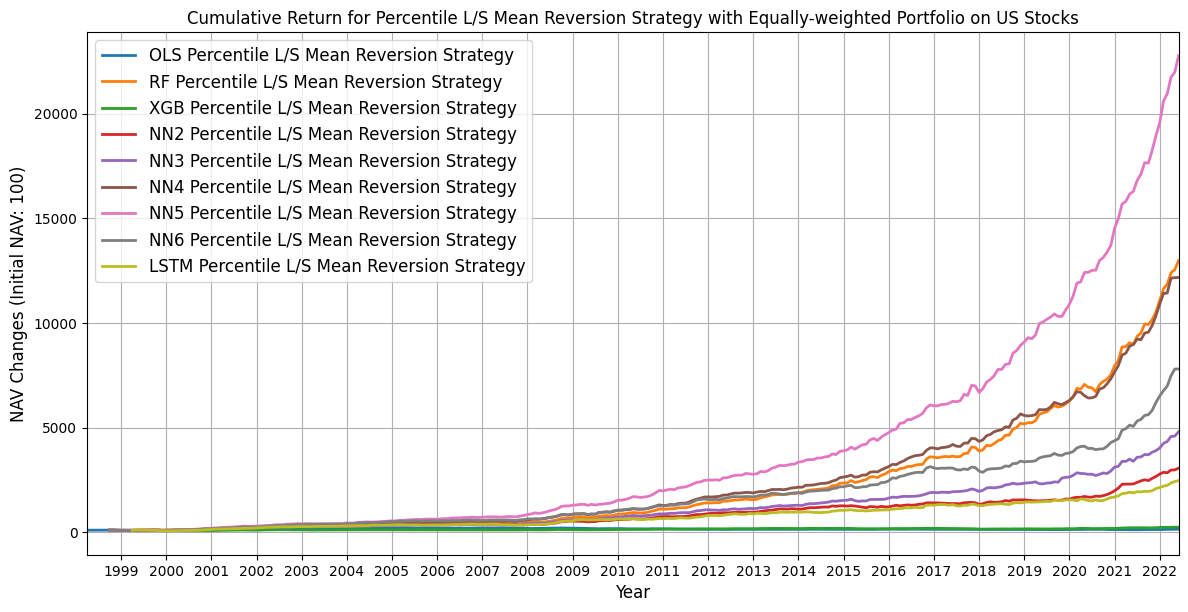

In [116]:
cum_P_strategy_return = pd.concat([cum_OLS_P_strategy_return.rename('OLS Percentile L/S Mean Reversion Strategy'),
                                     cum_RF_P_strategy_return.rename('RF Percentile L/S Mean Reversion Strategy'),
                                     cum_XGB_P_strategy_return.rename('XGB Percentile L/S Mean Reversion Strategy'),
                                     cum_NN2_P_strategy_return.rename('NN2 Percentile L/S Mean Reversion Strategy'),
                                     cum_NN3_P_strategy_return.rename('NN3 Percentile L/S Mean Reversion Strategy'),
                                     cum_NN4_P_strategy_return.rename('NN4 Percentile L/S Mean Reversion Strategy'),
                                     cum_NN5_P_strategy_return.rename('NN5 Percentile L/S Mean Reversion Strategy'),
                                     cum_NN6_P_strategy_return.rename('NN6 Percentile L/S Mean Reversion Strategy'),
                                     cum_LSTM_P_strategy_return.rename('LSTM Percentile L/S Mean Reversion Strategy')], axis=1)

ax_P = cum_P_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for Percentile L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks', fontsize=12)
plt.show()

In [243]:
# Performance Stats
P_stats = pd.concat([stats_OLS_P, stats_RF_P, stats_XGB_P, stats_NN2_P, stats_NN3_P, stats_NN4_P, stats_NN5_P, stats_NN6_P, stats_LSTM_P], axis=0)
display(P_stats.round(3))

Total Return  Avg Return  Rf Rate  \
OLS Percentile (Initial NAV: 100)             0.486       0.016    0.019   
RF Percentile (Initial NAV: 100)            128.742       0.227    0.019   
XGBoost Percentile (Initial NAV: 100)         1.412       0.038    0.019   
NN2 Percentile (Initial NAV: 100)            29.596       0.155    0.019   
NN3 Percentile (Initial NAV: 100)            46.942       0.177    0.019   
NN4 Percentile (Initial NAV: 100)           120.683       0.224    0.019   
NN5 Percentile (Initial NAV: 100)           226.602       0.257    0.019   
NN6 Percentile (Initial NAV: 100)            76.991       0.201    0.019   
LSTM Percentile (Initial NAV: 100)           23.673       0.148    0.019   

                                       Volatility  Sharpe Ratio  Skewness  \
OLS Percentile (Initial NAV: 100)           0.079        -0.028     0.334   
RF Percentile (Initial NAV: 100)            0.092         2.278     0.062   
XGBoost Percentile (Initial NAV: 100)       0.092         0.207     0.178   
NN2 Percentile (Initial NAV: 100)           0.095         1.429    -0.271   
NN3 Percentile (Initial NAV: 100)           0.097         1.635    -0.034   
NN4 Percentile (Initial NAV: 100)           0.096         2.130     0.175   
NN5 Percentile (Initial NAV: 100)           0.087         2.725     0.122   
NN6 Percentile (Initial NAV: 100)           0.102         1.788     0.198   
LSTM Percentile (Initial NAV: 100)          0.116         1.112     0.470   

                                       Kurtosis        HWM    HWM date    MDD  \
OLS Percentile (Initial NAV: 100)         1.253    203.131  2008-10-31  0.408   
RF Percentile (Initial NAV: 100)          0.657  12974.204  2022-06-30  0.050   
XGBoost Percentile (Initial NAV: 100)     2.119    241.833  2022-05-31  0.215   
NN2 Percentile (Initial NAV: 100)         4.006   3059.563  2022-06-30  0.078   
NN3 Percentile (Initial NAV: 100)         2.962   4794.226  2022-06-30  0.046   
NN4 Percentile (Initial NAV: 100)         0.863  12168.258  2022-06-30  0.045   
NN5 Percentile (Initial NAV: 100)         1.411  22760.190  2022-06-30  0.049   
NN6 Percentile (Initial NAV: 100)         2.734   7799.144  2022-06-30  0.087   
LSTM Percentile (Initial NAV: 100)        4.540   2467.315  2022-06-30  0.063   

                                        Peak Date Trough Date  Recession Date  \
OLS Percentile (Initial NAV: 100)      2008-10-31  2021-07-31  Yet to recover   
RF Percentile (Initial NAV: 100)       2020-05-31  2020-08-31      2020-10-31   
XGBoost Percentile (Initial NAV: 100)  2016-12-31  2018-02-28      2021-03-31   
NN2 Percentile (Initial NAV: 100)      2015-03-31  2015-07-31      2016-03-31   
NN3 Percentile (Initial NAV: 100)      2020-03-31  2020-08-31      2020-12-31   
NN4 Percentile (Initial NAV: 100)      2020-03-31  2020-06-30      2020-09-30   
NN5 Percentile (Initial NAV: 100)      2017-11-30  2018-01-31      2018-03-31   
NN6 Percentile (Initial NAV: 100)      2016-12-31  2018-02-28      2018-08-31   
LSTM Percentile (Initial NAV: 100)     2020-04-30  2020-07-31      2020-12-31   

                                         MDD Duration  
OLS Percentile (Initial NAV: 100)      Yet to recover  
RF Percentile (Initial NAV: 100)                  153  
XGBoost Percentile (Initial NAV: 100)            1551  
NN2 Percentile (Initial NAV: 100)                 366  
NN3 Percentile (Initial NAV: 100)                 275  
NN4 Percentile (Initial NAV: 100)                 183  
NN5 Percentile (Initial NAV: 100)                 121  
NN6 Percentile (Initial NAV: 100)                 608  
LSTM Percentile (Initial NAV: 100)                245

In [244]:
P_stats2 = pd.concat([stats2_OLS_P, stats2_RF_P, stats2_XGB_P, stats2_NN2_P, stats2_NN3_P, stats2_NN4_P, stats2_NN5_P, stats2_NN6_P, stats2_LSTM_P], axis=0)
display(P_stats2.round(3))

Total Return  Avg Monthly Return  \
OLS Percentile (Long & Short)             0.486               0.001   
(Long Position)                         648.845               0.023   
(Short Position)                         -0.999              -0.023   
RF Percentile (Long & Short)            128.742               0.017   
(Long Position)                      339376.455               0.046   
(Short Position)                         -0.979              -0.013   
XGBoost Percentile (Long & Short)         1.412               0.003   
(Long Position)                         509.001               0.022   
(Short Position)                         -0.996              -0.019   
NN2 Percentile (Long & Short)            29.596               0.012   
(Long Position)                       22261.592               0.036   
(Short Position)                         -0.983              -0.014   
NN3 Percentile (Long & Short)            46.942               0.014   
(Long Position)                       53868.590               0.039   
(Short Position)                         -0.982              -0.014   
NN4 Percentile (Long & Short)           120.683               0.017   
(Long Position)                      416994.503               0.046   
(Short Position)                         -0.986              -0.015   
NN5 Percentile (Long & Short)           226.602               0.019   
(Long Position)                      952818.929               0.049   
(Short Position)                         -0.976              -0.013   
NN6 Percentile (Long & Short)            76.991               0.015   
(Long Position)                      216473.546               0.044   
(Short Position)                         -0.989              -0.016   
LSTM Percentile (Long & Short)           23.673               0.012   
(Long Position)                        2804.478               0.029   
(Short Position)                         -0.898              -0.008   

                                    Avg Mkt Cap  Fraction>0  \
OLS Percentile (Long & Short)      6.755169e+09       0.497   
(Long Position)                    2.207860e+09       0.676   
(Short Position)                   1.036373e+10       0.362   
RF Percentile (Long & Short)       3.020776e+11       0.741   
(Long Position)                    7.725731e+08       0.883   
(Short Position)                   5.251660e+11       0.383   
XGBoost Percentile (Long & Short)  1.005431e+11       0.524   
(Long Position)                    4.365603e+09       0.676   
(Short Position)                   1.906114e+11       0.359   
NN2 Percentile (Long & Short)      2.321746e+11       0.662   
(Long Position)                    3.205639e+09       0.759   
(Short Position)                   4.253420e+11       0.352   
NN3 Percentile (Long & Short)      2.356793e+11       0.738   
(Long Position)                    3.338680e+09       0.814   
(Short Position)                   4.214271e+11       0.369   
NN4 Percentile (Long & Short)      3.446433e+11       0.738   
(Long Position)                    1.101012e+09       0.876   
(Short Position)                   5.952869e+11       0.372   
NN5 Percentile (Long & Short)      3.875807e+11       0.776   
(Long Position)                    6.865813e+08       0.917   
(Short Position)                   6.489386e+11       0.379   
NN6 Percentile (Long & Short)      3.516164e+11       0.721   
(Long Position)                    1.330122e+09       0.838   
(Short Position)                   6.115077e+11       0.369   
LSTM Percentile (Long & Short)     2.113307e+11       0.631   
(Long Position)                    1.819045e+09       0.703   
(Short Position)                   3.995079e+11       0.390   

                                   + Return Stocks (Avg)  \
OLS Percentile (Long & Short)                      0.089   
(Long Position)                                    0.089   
(Short Position)                                   0.073   
RF Percentile (Long & Short)             

## Intertemporal Comparison

### 1998 - 2012

#### (1) L & S Combined

In [84]:
cum_OLS_Q_strategy_return_9812 = get_price_df(df_OLS_Quintile_Signal[:176], df_returns[:176], nav=100, model_type=None)
cum_RF_Q_strategy_return_9812 = get_price_df(df_RF_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_XGB_Q_strategy_return_9812 = get_price_df(df_XGB_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN2_Q_strategy_return_9812 = get_price_df(df_NN2_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN3_Q_strategy_return_9812 = get_price_df(df_NN3_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN4_Q_strategy_return_9812 = get_price_df(df_NN4_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN5_Q_strategy_return_9812 = get_price_df(df_NN5_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN6_Q_strategy_return_9812 = get_price_df(df_NN6_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='ML')
cum_LSTM_Q_strategy_return_9812 = get_price_df(df_LSTM_Quintile_Signal[:176], df_returns[:176], nav=100, model_type='LSTM')

stats_OLS_Q_9812 = get_performance_stats(cum_OLS_Q_strategy_return_9812, rfr=risk_free_rate_df, label='OLS Quintile 9812 (Initial NAV: 100)')
stats_RF_Q_9812 = get_performance_stats(cum_RF_Q_strategy_return_9812, rfr=risk_free_rate_df, label='RF Quintile 9812 (Initial NAV: 100)')
stats_XGB_Q_9812 = get_performance_stats(cum_XGB_Q_strategy_return_9812, rfr=risk_free_rate_df, label='XGB Quintile 9812 (Initial NAV: 100)')
stats_NN2_Q_9812 = get_performance_stats(cum_NN2_Q_strategy_return_9812, rfr=risk_free_rate_df, label='NN2 Quintile 9812 (Initial NAV: 100)')
stats_NN3_Q_9812 = get_performance_stats(cum_NN3_Q_strategy_return_9812, rfr=risk_free_rate_df, label='NN3 Quintile 9812 (Initial NAV: 100)')
stats_NN4_Q_9812 = get_performance_stats(cum_NN4_Q_strategy_return_9812, rfr=risk_free_rate_df, label='NN4 Quintile 9812 (Initial NAV: 100)')
stats_NN5_Q_9812 = get_performance_stats(cum_NN5_Q_strategy_return_9812, rfr=risk_free_rate_df, label='NN5 Quintile 9812 (Initial NAV: 100)')
stats_NN6_Q_9812 = get_performance_stats(cum_NN6_Q_strategy_return_9812, rfr=risk_free_rate_df, label='NN6 Quintile 9812 (Initial NAV: 100)')
stats_LSTM_Q_9812 = get_performance_stats(cum_LSTM_Q_strategy_return_9812, rfr=risk_free_rate_df, label='LSTM Quintile 9812 (Initial NAV: 100)')

OLS_stats_9812 = pd.concat([stats_OLS_Q_9812, stats_RF_Q_9812, stats_XGB_Q_9812, stats_NN2_Q_9812, stats_NN3_Q_9812, stats_NN4_Q_9812, stats_NN5_Q_9812, stats_NN6_Q_9812, stats_LSTM_Q_9812], axis=0)
display(OLS_stats_9812)

Total Return  Avg Return   Rf Rate  \
OLS Quintile 9812 (Initial NAV: 100)       0.976511    0.047276  0.018682   
RF Quintile 9812 (Initial NAV: 100)        5.294086    0.137799  0.018682   
XGB Quintile 9812 (Initial NAV: 100)       4.187362    0.122462  0.018682   
NN2 Quintile 9812 (Initial NAV: 100)       4.727244    0.130288  0.018682   
NN3 Quintile 9812 (Initial NAV: 100)       5.623800    0.141883  0.018682   
NN4 Quintile 9812 (Initial NAV: 100)       5.417951    0.139356  0.018682   
NN5 Quintile 9812 (Initial NAV: 100)       5.195182    0.136535  0.018682   
NN6 Quintile 9812 (Initial NAV: 100)       4.970201    0.133588  0.018682   
LSTM Quintile 9812 (Initial NAV: 100)      1.267202    0.059124  0.018682   

                                       Volatility  Sharpe Ratio  Skewness  \
OLS Quintile 9812 (Initial NAV: 100)     0.075872      0.376858 -1.301186   
RF Quintile 9812 (Initial NAV: 100)      0.047971      2.483067  0.840351   
XGB Quintile 9812 (Initial NAV: 100)     0.049954      2.077513  0.557767   
NN2 Quintile 9812 (Initial NAV: 100)     0.053350      2.091963  1.832348   
NN3 Quintile 9812 (Initial NAV: 100)     0.050195      2.454440  1.078737   
NN4 Quintile 9812 (Initial NAV: 100)     0.053516      2.254900  1.104250   
NN5 Quintile 9812 (Initial NAV: 100)     0.050117      2.351562  0.941163   
NN6 Quintile 9812 (Initial NAV: 100)     0.050959      2.254864  0.971082   
LSTM Quintile 9812 (Initial NAV: 100)    0.054996      0.735342  0.020010   

                                        Kurtosis         HWM    HWM date  \
OLS Quintile 9812 (Initial NAV: 100)   16.051466  227.071183  2009-11-30   
RF Quintile 9812 (Initial NAV: 100)     1.128235  629.408569  2012-12-31   
XGB Quintile 9812 (Initial NAV: 100)    1.133552  518.736163  2012-12-31   
NN2 Quintile 9812 (Initial NAV: 100)    5.849588  572.724441  2012-12-31   
NN3 Quintile 9812 (Initial NAV: 100)    1.621703  662.379961  2012-12-31   
NN4 Quintile 9812 (Initial NAV: 100)    1.615996  641.795055  2012-12-31   
NN5 Quintile 9812 (Initial NAV: 100)    1.183455  619.518152  2012-12-31   
NN6 Quintile 9812 (Initial NAV: 100)    1.290488  597.020150  2012-12-31   
LSTM Quintile 9812 (Initial NAV: 100)   2.529727  226.720189  2012-12-31   

                                            MDD   Peak Date Trough Date  \
OLS Quintile 9812 (Initial NAV: 100)   0.137833  2009-11-30  2012-06-30   
RF Quintile 9812 (Initial NAV: 100)    0.026783  2007-03-31  2007-11-30   
XGB Quintile 9812 (Initial NAV: 100)   0.029921  2007-03-31  2007-10-31   
NN2 Quintile 9812 (Initial NAV: 100)   0.015862  2009-09-30  2009-11-30   
NN3 Quintile 9812 (Initial NAV: 100)   0.029079  2007-03-31  2007-10-31   
NN4 Quintile 9812 (Initial NAV: 100)   0.033902  2007-03-31  2007-11-30   
NN5 Quintile 9812 (Initial NAV: 100)   0.027090  2007-03-31  2007-11-30   
NN6 Quintile 9812 (Initial NAV: 100)   0.034043  2007-03-31  2007-11-30   
LSTM Quintile 9812 (Initial NAV: 100)  0.182550  1999-07-31  2000-02-29   

                                       Recession Date    MDD Duration  
OLS Quintile 9812 (Initial NAV: 100)   Yet to recover  Yet to recover  
RF Quintile 9812 (Initial NAV: 100)        2008-03-31             366  
XGB Quintile 9812 (Initial NAV: 100)       2008-03-31             366  
NN2 Quintile 9812 (Initial NAV: 100)       2010-01-31             123  
NN3 Quintile 9812 (Initial NAV: 100)       2008-03-31             366  
NN4 Quintile 9812 (Initial NAV: 100)       2008-03-31             366  
NN5 Quintile 9812 (Initial NAV: 100)       2008-02-29             335  
NN6 Quintile 9812 (Initial NAV: 100)       2008-03-31             366  
LSTM Quintile 9812 (Initial NAV: 100)      2000-12-31             519

In [90]:
stats2_OLS_Q_9812 = get_performance_stats_2(df_OLS_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='OLS Quintile 9812', model_type=None)
stats2_RF_Q_9812 = get_performance_stats_2(df_RF_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='RF Quintile 9812', model_type='ML')
stats2_XGB_Q_9812 = get_performance_stats_2(df_XGB_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='XGB Quintile 9812', model_type='ML')
stats2_NN2_Q_9812 = get_performance_stats_2(df_NN2_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='NN2 Quintile 9812', model_type='ML')
stats2_NN3_Q_9812 = get_performance_stats_2(df_NN3_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='NN3 Quintile 9812', model_type='ML')
stats2_NN4_Q_9812 = get_performance_stats_2(df_NN4_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='NN4 Quintile 9812', model_type='ML')
stats2_NN5_Q_9812 = get_performance_stats_2(df_NN5_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='NN5 Quintile 9812', model_type='ML')
stats2_NN6_Q_9812 = get_performance_stats_2(df_NN6_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='NN6 Quintile 9812', model_type='ML')
stats2_LSTM_Q_9812 = get_performance_stats_2(df_LSTM_Quintile_Signal[:176], df_returns[:176], df_market_cap[:176], label='LSTM Quintile 9812', model_type='LSTM')

LSTM_stats2_9812 = pd.concat([stats2_OLS_Q_9812, stats2_RF_Q_9812, stats2_XGB_Q_9812, stats2_NN2_Q_9812, stats2_NN3_Q_9812, stats2_NN4_Q_9812, stats2_NN5_Q_9812, stats2_NN6_Q_9812, stats2_LSTM_Q_9812], axis=0)
display(LSTM_stats2_9812)

Total Return  Avg Monthly Return  \
OLS Quintile 9812 (Long & Short)       0.976511            0.003857   
(Long Position)                       36.926717            0.020753   
(Short Position)                      -0.938702           -0.015650   
RF Quintile 9812 (Long & Short)        5.294086            0.010816   
(Long Position)                      118.839728            0.028385   
(Short Position)                      -0.785118           -0.008952   
XGB Quintile 9812 (Long & Short)       4.187362            0.009674   
(Long Position)                       95.900575            0.027108   
(Short Position)                      -0.824193           -0.010114   
NN2 Quintile 9812 (Long & Short)       4.727244            0.010258   
(Long Position)                      112.384773            0.028052   
(Short Position)                      -0.816331           -0.009861   
NN3 Quintile 9812 (Long & Short)       5.623800            0.011118   
(Long Position)                      129.678703            0.028905   
(Short Position)                      -0.786780           -0.008997   
NN4 Quintile 9812 (Long & Short)       5.417951            0.010931   
(Long Position)                      128.508305            0.028851   
(Short Position)                      -0.798447           -0.009323   
NN5 Quintile 9812 (Long & Short)       5.195182            0.010722   
(Long Position)                      118.694773            0.028377   
(Short Position)                      -0.792571           -0.009156   
NN6 Quintile 9812 (Long & Short)       4.970201            0.010504   
(Long Position)                      121.029736            0.028494   
(Short Position)                      -0.817694           -0.009904   
LSTM Quintile 9812 (Long & Short)      1.267202            0.004798   
(Long Position)                       13.203653            0.015639   
(Short Position)                      -0.757025           -0.008240   

                                    Avg Mkt Cap  Fraction>0  \
OLS Quintile 9812 (Long & Short)   2.203025e+10    0.602273   
(Long Position)                    3.877631e+09    0.659091   
(Short Position)                   3.882384e+10    0.386364   
RF Quintile 9812 (Long & Short)    3.366113e+10    0.778409   
(Long Position)                    6.038102e+08    0.687500   
(Short Position)                   6.386900e+10    0.409091   
XGB Quintile 9812 (Long & Short)   2.966991e+10    0.772727   
(Long Position)                    1.712987e+09    0.687500   
(Short Position)                   5.544810e+10    0.414773   
NN2 Quintile 9812 (Long & Short)   2.987627e+10    0.732955   
(Long Position)                    1.361965e+09    0.676136   
(Short Position)                   5.600602e+10    0.386364   
NN3 Quintile 9812 (Long & Short)   3.112139e+10    0.778409   
(Long Position)                    1.079679e+09    0.681818   
(Short Position)                   5.863608e+10    0.426136   
NN4 Quintile 9812 (Long & Short)   3.294583e+10    0.761364   
(Long Position)                    6.199013e+08    0.681818   
(Short Position)                   6.250396e+10    0.414773   
NN5 Quintile 9812 (Long & Short)   3.495932e+10    0.761364   
(Long Position)                    5.013411e+08    0.676136   
(Short Position)                   6.642477e+10    0.403409   
NN6 Quintile 9812 (Long & Short)   3.191068e+10    0.755682   
(Long Position)                    8.092258e+08    0.670455   
(Short Position)                   6.033213e+10    0.426136   
LSTM Quintile 9812 (Long & Short)  1.955882e+10    0.549451   
(Long Position)                    1.629672e+09    0.571429   
(Short Position)                   3.709218e+10    0.379121   

                                   + Return Stocks (Avg)  \
OLS Quintile 9812 (Long & Short)                0.091304   
(Long Position)                                 0.089491   
(Short Position)                                0.078091   
RF Quintile 9812 (Long & Short)          

#### (2) Long Position Only

In [80]:
cum_OLS_Q_strategy_return_L_9812 = get_price_df(df_OLS_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type=None)
cum_RF_Q_strategy_return_L_9812 = get_price_df(df_RF_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_XGB_Q_strategy_return_L_9812 = get_price_df(df_XGB_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN2_Q_strategy_return_L_9812 = get_price_df(df_NN2_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN3_Q_strategy_return_L_9812 = get_price_df(df_NN3_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN4_Q_strategy_return_L_9812 = get_price_df(df_NN4_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN5_Q_strategy_return_L_9812 = get_price_df(df_NN5_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN6_Q_strategy_return_L_9812 = get_price_df(df_NN6_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='ML')
cum_LSTM_Q_strategy_return_L_9812 = get_price_df(df_LSTM_Quintile_Signal.replace(-1, 0)[:176], df_returns[:176], nav=100, model_type='LSTM')

stats_OLS_Q_L_9812 = get_performance_stats(cum_OLS_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='OLS Quintile L 9812 (Initial NAV: 100)')
stats_RF_Q_L_9812 = get_performance_stats(cum_RF_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='RF Quintile L 9812 (Initial NAV: 100)')
stats_XGB_Q_L_9812 = get_performance_stats(cum_XGB_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='XGB Quintile L 9812 (Initial NAV: 100)')
stats_NN2_Q_L_9812 = get_performance_stats(cum_NN2_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='NN2 Quintile L 9812 (Initial NAV: 100)')
stats_NN3_Q_L_9812 = get_performance_stats(cum_NN3_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='NN3 Quintile L 9812 (Initial NAV: 100)')
stats_NN4_Q_L_9812 = get_performance_stats(cum_NN4_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='NN4 Quintile L 9812 (Initial NAV: 100)')
stats_NN5_Q_L_9812 = get_performance_stats(cum_NN5_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='NN5 Quintile L 9812 (Initial NAV: 100)')
stats_NN6_Q_L_9812 = get_performance_stats(cum_NN6_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='NN6 Quintile L 9812 (Initial NAV: 100)')
stats_LSTM_Q_L_9812 = get_performance_stats(cum_LSTM_Q_strategy_return_L_9812, rfr=risk_free_rate_df, label='LSTM Quintile L 9812 (Initial NAV: 100)')

OLS_stats_L_9812 = pd.concat([stats_OLS_Q_L_9812, stats_RF_Q_L_9812, stats_XGB_Q_L_9812, stats_NN2_Q_L_9812, stats_NN3_Q_L_9812, stats_NN4_Q_L_9812, stats_NN5_Q_L_9812, stats_NN6_Q_L_9812, stats_LSTM_Q_L_9812], axis=0)
display(OLS_stats_L_9812)

Total Return  Avg Return   Rf Rate  \
OLS Quintile L 9812 (Initial NAV: 100)      36.926717    0.279520  0.018682   
RF Quintile L 9812 (Initial NAV: 100)      118.839728    0.399158  0.018682   
XGB Quintile L 9812 (Initial NAV: 100)      95.900575    0.378451  0.018682   
NN2 Quintile L 9812 (Initial NAV: 100)     112.384773    0.393732  0.018682   
NN3 Quintile L 9812 (Initial NAV: 100)     129.678703    0.407685  0.018682   
NN4 Quintile L 9812 (Initial NAV: 100)     128.508305    0.406797  0.018682   
NN5 Quintile L 9812 (Initial NAV: 100)     118.694773    0.399039  0.018682   
NN6 Quintile L 9812 (Initial NAV: 100)     121.029736    0.400937  0.018682   
LSTM Quintile L 9812 (Initial NAV: 100)     13.203653    0.204676  0.018682   

                                         Volatility  Sharpe Ratio  Skewness  \
OLS Quintile L 9812 (Initial NAV: 100)     0.173856      1.500308  0.066234   
RF Quintile L 9812 (Initial NAV: 100)      0.164945      2.306686  0.208363   
XGB Quintile L 9812 (Initial NAV: 100)     0.164698      2.184413  0.129573   
NN2 Quintile L 9812 (Initial NAV: 100)     0.179976      2.083881  0.772722   
NN3 Quintile L 9812 (Initial NAV: 100)     0.173478      2.242382  0.332105   
NN4 Quintile L 9812 (Initial NAV: 100)     0.171710      2.260290  0.387516   
NN5 Quintile L 9812 (Initial NAV: 100)     0.171356      2.219690  0.372941   
NN6 Quintile L 9812 (Initial NAV: 100)     0.171494      2.228962  0.401830   
LSTM Quintile L 9812 (Initial NAV: 100)    0.168234      1.105562  0.012282   

                                         Kurtosis           HWM    HWM date  \
OLS Quintile L 9812 (Initial NAV: 100)   0.336375   3792.671713  2012-12-31   
RF Quintile L 9812 (Initial NAV: 100)   -0.175009  11983.972768  2012-12-31   
XGB Quintile L 9812 (Initial NAV: 100)  -0.018785   9690.057512  2012-12-31   
NN2 Quintile L 9812 (Initial NAV: 100)   2.114046  11338.477274  2012-12-31   
NN3 Quintile L 9812 (Initial NAV: 100)   0.082813  13067.870313  2012-12-31   
NN4 Quintile L 9812 (Initial NAV: 100)   0.337546  12950.830492  2012-12-31   
NN5 Quintile L 9812 (Initial NAV: 100)   0.222681  11969.477279  2012-12-31   
NN6 Quintile L 9812 (Initial NAV: 100)   0.278733  12202.973573  2012-12-31   
LSTM Quintile L 9812 (Initial NAV: 100)  0.135529   1420.365326  2012-12-31   

                                              MDD   Peak Date Trough Date  \
OLS Quintile L 9812 (Initial NAV: 100)   0.191246  2011-04-30  2011-09-30   
RF Quintile L 9812 (Initial NAV: 100)    0.173817  2011-04-30  2011-09-30   
XGB Quintile L 9812 (Initial NAV: 100)   0.177880  2011-04-30  2011-09-30   
NN2 Quintile L 9812 (Initial NAV: 100)   0.186705  2011-04-30  2011-09-30   
NN3 Quintile L 9812 (Initial NAV: 100)   0.172549  2011-04-30  2011-09-30   
NN4 Quintile L 9812 (Initial NAV: 100)   0.176077  2011-04-30  2011-09-30   
NN5 Quintile L 9812 (Initial NAV: 100)   0.172262  2011-04-30  2011-09-30   
NN6 Quintile L 9812 (Initial NAV: 100)   0.170319  2011-04-30  2011-09-30   
LSTM Quintile L 9812 (Initial NAV: 100)  0.195012  2011-04-30  2011-09-30   

                                        Recession Date  MDD Duration  
OLS Quintile L 9812 (Initial NAV: 100)      2012-02-29           305  
RF Quintile L 9812 (Initial NAV: 100)       2012-01-31           276  
XGB Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
NN2 Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
NN3 Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
NN4 Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
NN5 Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
NN6 Quintile L 9812 (Initial NAV: 100)      2012-01-31           276  
LSTM Quintile L 9812 (Initial NAV: 100)     2012-01-31           276

#### (3) Short Position Only

In [82]:
cum_OLS_Q_strategy_return_S_9812 = get_price_df(df_OLS_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type=None)
cum_RF_Q_strategy_return_S_9812 = get_price_df(df_RF_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_XGB_Q_strategy_return_S_9812 = get_price_df(df_XGB_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN2_Q_strategy_return_S_9812 = get_price_df(df_NN2_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN3_Q_strategy_return_S_9812 = get_price_df(df_NN3_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN4_Q_strategy_return_S_9812 = get_price_df(df_NN4_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN5_Q_strategy_return_S_9812 = get_price_df(df_NN5_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_NN6_Q_strategy_return_S_9812 = get_price_df(df_NN6_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='ML')
cum_LSTM_Q_strategy_return_S_9812 = get_price_df(df_LSTM_Quintile_Signal.replace([1, -1], [0, 1])[:176], df_returns[:176], nav=100, model_type='LSTM')

stats_OLS_Q_S_9812 = get_performance_stats(cum_OLS_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='OLS Quintile S 9812 (Initial NAV: 100)')
stats_RF_Q_S_9812 = get_performance_stats(cum_RF_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='RF Quintile S 9812 (Initial NAV: 100)')
stats_XGB_Q_S_9812 = get_performance_stats(cum_XGB_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='XGB Quintile S 9812 (Initial NAV: 100)')
stats_NN2_Q_S_9812 = get_performance_stats(cum_NN2_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='NN2 Quintile S 9812 (Initial NAV: 100)')
stats_NN3_Q_S_9812 = get_performance_stats(cum_NN3_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='NN3 Quintile S 9812 (Initial NAV: 100)')
stats_NN4_Q_S_9812 = get_performance_stats(cum_NN4_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='NN4 Quintile S 9812 (Initial NAV: 100)')
stats_NN5_Q_S_9812 = get_performance_stats(cum_NN5_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='NN5 Quintile S 9812 (Initial NAV: 100)')
stats_NN6_Q_S_9812 = get_performance_stats(cum_NN6_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='NN6 Quintile S 9812 (Initial NAV: 100)')
stats_LSTM_Q_S_9812 = get_performance_stats(cum_LSTM_Q_strategy_return_S_9812, rfr=risk_free_rate_df, label='LSTM Quintile S 9812 (Initial NAV: 100)')

OLS_stats_S_9812 = pd.concat([stats_OLS_Q_S_9812, stats_RF_Q_S_9812, stats_XGB_Q_S_9812, stats_NN2_Q_S_9812, stats_NN3_Q_S_9812, stats_NN4_Q_S_9812, stats_NN5_Q_S_9812, stats_NN6_Q_S_9812, stats_LSTM_Q_S_9812], axis=0)
display(OLS_stats_S_9812)

Total Return  Avg Return   Rf Rate  \
OLS Quintile S 9812 (Initial NAV: 100)       7.178734    0.153127  0.018682   
RF Quintile S 9812 (Initial NAV: 100)        1.924613    0.078218  0.018682   
XGB Quintile S 9812 (Initial NAV: 100)       2.384458    0.089324  0.018682   
NN2 Quintile S 9812 (Initial NAV: 100)       2.433865    0.090433  0.018682   
NN3 Quintile S 9812 (Initial NAV: 100)       1.915794    0.077989  0.018682   
NN4 Quintile S 9812 (Initial NAV: 100)       2.011713    0.080441  0.018682   
NN5 Quintile S 9812 (Initial NAV: 100)       2.067076    0.081823  0.018682   
NN6 Quintile S 9812 (Initial NAV: 100)       2.256734    0.086387  0.018682   
LSTM Quintile S 9812 (Initial NAV: 100)      1.586701    0.068968  0.018682   

                                         Volatility  Sharpe Ratio  Skewness  \
OLS Quintile S 9812 (Initial NAV: 100)     0.211103      0.636865  0.055251   
RF Quintile S 9812 (Initial NAV: 100)      0.179202      0.332225 -0.553352   
XGB Quintile S 9812 (Initial NAV: 100)     0.189055      0.373656 -0.179916   
NN2 Quintile S 9812 (Initial NAV: 100)     0.177992      0.403109 -0.570600   
NN3 Quintile S 9812 (Initial NAV: 100)     0.181286      0.327147 -0.458457   
NN4 Quintile S 9812 (Initial NAV: 100)     0.185743      0.332493 -0.586673   
NN5 Quintile S 9812 (Initial NAV: 100)     0.176647      0.357437 -0.602688   
NN6 Quintile S 9812 (Initial NAV: 100)     0.189629      0.357039 -0.470134   
LSTM Quintile S 9812 (Initial NAV: 100)    0.179523      0.280105 -0.439683   

                                         Kurtosis         HWM    HWM date  \
OLS Quintile S 9812 (Initial NAV: 100)   2.243170  817.873417  2012-12-31   
RF Quintile S 9812 (Initial NAV: 100)    0.866309  292.461344  2012-12-31   
XGB Quintile S 9812 (Initial NAV: 100)   0.980311  338.445830  2012-12-31   
NN2 Quintile S 9812 (Initial NAV: 100)   0.879723  343.386528  2012-12-31   
NN3 Quintile S 9812 (Initial NAV: 100)   0.941360  291.579392  2012-12-31   
NN4 Quintile S 9812 (Initial NAV: 100)   0.883297  301.171283  2012-12-31   
NN5 Quintile S 9812 (Initial NAV: 100)   0.926569  306.707614  2012-12-31   
NN6 Quintile S 9812 (Initial NAV: 100)   0.736854  325.673398  2012-12-31   
LSTM Quintile S 9812 (Initial NAV: 100)  0.932666  258.670096  2012-12-31   

                                              MDD   Peak Date Trough Date  \
OLS Quintile S 9812 (Initial NAV: 100)   0.373825  2007-10-31  2009-02-28   
RF Quintile S 9812 (Initial NAV: 100)    0.477336  2007-10-31  2009-02-28   
XGB Quintile S 9812 (Initial NAV: 100)   0.466733  2007-10-31  2009-02-28   
NN2 Quintile S 9812 (Initial NAV: 100)   0.490505  2007-10-31  2009-02-28   
NN3 Quintile S 9812 (Initial NAV: 100)   0.479471  2007-10-31  2009-02-28   
NN4 Quintile S 9812 (Initial NAV: 100)   0.474031  2007-10-31  2009-02-28   
NN5 Quintile S 9812 (Initial NAV: 100)   0.492616  2007-10-31  2009-02-28   
NN6 Quintile S 9812 (Initial NAV: 100)   0.475122  2007-10-31  2009-02-28   
LSTM Quintile S 9812 (Initial NAV: 100)  0.464892  2007-10-31  2009-02-28   

                                        Recession Date  MDD Duration  
OLS Quintile S 9812 (Initial NAV: 100)      2009-09-30           700  
RF Quintile S 9812 (Initial NAV: 100)       2010-12-31          1157  
XGB Quintile S 9812 (Initial NAV: 100)      2010-12-31          1157  
NN2 Quintile S 9812 (Initial NAV: 100)      2010-12-31          1157  
NN3 Quintile S 9812 (Initial NAV: 100)      2010-12-31          1157  
NN4 Quintile S 9812 (Initial NAV: 100)      2010-10-31          1096  
NN5 Quintile S 9812 (Initial NAV: 100)      2010-12-31          1157  
NN6 Quintile S 9812 (Initial NAV: 100)      2010-10-31          1096  
LSTM Quintile S 9812 (Initial NAV: 100)     2010-11-30          1126

### 2013 - 2022

#### (1) L & S Combined

In [94]:
cum_OLS_Q_strategy_return_1322 = get_price_df(df_OLS_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_RF_Q_strategy_return_1322 = get_price_df(df_RF_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_XGB_Q_strategy_return_1322 = get_price_df(df_XGB_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_NN2_Q_strategy_return_1322 = get_price_df(df_NN2_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_NN3_Q_strategy_return_1322 = get_price_df(df_NN3_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_NN4_Q_strategy_return_1322 = get_price_df(df_NN4_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_NN5_Q_strategy_return_1322 = get_price_df(df_NN5_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_NN6_Q_strategy_return_1322 = get_price_df(df_NN6_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')
cum_LSTM_Q_strategy_return_1322 = get_price_df(df_LSTM_Quintile_Signal[176:], df_returns[176:], nav=100, model_type='13')

stats_OLS_Q_1322 = get_performance_stats(cum_OLS_Q_strategy_return_1322, rfr=risk_free_rate_df, label='OLS Quintile 1322 (Initial NAV: 100)')
stats_RF_Q_1322 = get_performance_stats(cum_RF_Q_strategy_return_1322, rfr=risk_free_rate_df, label='RF Quintile 1322 (Initial NAV: 100)')
stats_XGB_Q_1322 = get_performance_stats(cum_XGB_Q_strategy_return_1322, rfr=risk_free_rate_df, label='XGB Quintile 1322 (Initial NAV: 100)')
stats_NN2_Q_1322 = get_performance_stats(cum_NN2_Q_strategy_return_1322, rfr=risk_free_rate_df, label='NN2 Quintile 1322 (Initial NAV: 100)')
stats_NN3_Q_1322 = get_performance_stats(cum_NN3_Q_strategy_return_1322, rfr=risk_free_rate_df, label='NN3 Quintile 1322 (Initial NAV: 100)')
stats_NN4_Q_1322 = get_performance_stats(cum_NN4_Q_strategy_return_1322, rfr=risk_free_rate_df, label='NN4 Quintile 1322 (Initial NAV: 100)')
stats_NN5_Q_1322 = get_performance_stats(cum_NN5_Q_strategy_return_1322, rfr=risk_free_rate_df, label='NN5 Quintile 1322 (Initial NAV: 100)')
stats_NN6_Q_1322 = get_performance_stats(cum_NN6_Q_strategy_return_1322, rfr=risk_free_rate_df, label='NN6 Quintile 1322 (Initial NAV: 100)')
stats_LSTM_Q_1322 = get_performance_stats(cum_LSTM_Q_strategy_return_1322, rfr=risk_free_rate_df, label='LSTM Quintile 1322 (Initial NAV: 100)')

OLS_stats_1322 = pd.concat([stats_OLS_Q_1322, stats_RF_Q_1322, stats_XGB_Q_1322, stats_NN2_Q_1322, stats_NN3_Q_1322, stats_NN4_Q_1322, stats_NN5_Q_1322, stats_NN6_Q_1322, stats_LSTM_Q_1322], axis=0)
display(OLS_stats_1322)

Total Return  Avg Return   Rf Rate  \
OLS Quintile 1322 (Initial NAV: 100)       0.300146    0.027767  0.018682   
RF Quintile 1322 (Initial NAV: 100)        0.946627    0.071978  0.018682   
XGB Quintile 1322 (Initial NAV: 100)       0.928361    0.070924  0.018682   
NN2 Quintile 1322 (Initial NAV: 100)       0.716646    0.058007  0.018682   
NN3 Quintile 1322 (Initial NAV: 100)       0.948680    0.072096  0.018682   
NN4 Quintile 1322 (Initial NAV: 100)       0.894544    0.068949  0.018682   
NN5 Quintile 1322 (Initial NAV: 100)       0.931270    0.071093  0.018682   
NN6 Quintile 1322 (Initial NAV: 100)       0.850855    0.066350  0.018682   
LSTM Quintile 1322 (Initial NAV: 100)      0.326411    0.031587  0.018682   

                                       Volatility  Sharpe Ratio  Skewness  \
OLS Quintile 1322 (Initial NAV: 100)     0.039507      0.229960  0.448495   
RF Quintile 1322 (Initial NAV: 100)      0.043797      1.216883  0.447629   
XGB Quintile 1322 (Initial NAV: 100)     0.044593      1.171523  0.428295   
NN2 Quintile 1322 (Initial NAV: 100)     0.041283      0.952557  0.190213   
NN3 Quintile 1322 (Initial NAV: 100)     0.044467      1.201197  0.400403   
NN4 Quintile 1322 (Initial NAV: 100)     0.043731      1.149449  0.463677   
NN5 Quintile 1322 (Initial NAV: 100)     0.043727      1.198572  0.514260   
NN6 Quintile 1322 (Initial NAV: 100)     0.044759      1.064988  0.440017   
LSTM Quintile 1322 (Initial NAV: 100)    0.047270      0.272994  0.366920   

                                       Kurtosis         HWM    HWM date  \
OLS Quintile 1322 (Initial NAV: 100)   0.587064  131.085777  2022-05-31   
RF Quintile 1322 (Initial NAV: 100)    0.190993  194.662677  2022-06-30   
XGB Quintile 1322 (Initial NAV: 100)   0.598696  192.836133  2022-06-30   
NN2 Quintile 1322 (Initial NAV: 100)  -0.018822  171.664559  2022-06-30   
NN3 Quintile 1322 (Initial NAV: 100)   0.316358  194.868048  2022-06-30   
NN4 Quintile 1322 (Initial NAV: 100)   0.366161  189.454388  2022-06-30   
NN5 Quintile 1322 (Initial NAV: 100)   0.366636  193.127035  2022-06-30   
NN6 Quintile 1322 (Initial NAV: 100)   0.581409  185.085487  2022-06-30   
LSTM Quintile 1322 (Initial NAV: 100)  0.263331  132.641107  2022-06-30   

                                            MDD   Peak Date Trough Date  \
OLS Quintile 1322 (Initial NAV: 100)   0.115580  2013-01-31  2015-07-31   
RF Quintile 1322 (Initial NAV: 100)    0.020860  2020-06-30  2020-07-31   
XGB Quintile 1322 (Initial NAV: 100)   0.030351  2020-04-30  2020-07-31   
NN2 Quintile 1322 (Initial NAV: 100)   0.032176  2020-04-30  2020-07-31   
NN3 Quintile 1322 (Initial NAV: 100)   0.026067  2020-06-30  2020-07-31   
NN4 Quintile 1322 (Initial NAV: 100)   0.027100  2019-02-28  2019-08-31   
NN5 Quintile 1322 (Initial NAV: 100)   0.026138  2019-02-28  2019-08-31   
NN6 Quintile 1322 (Initial NAV: 100)   0.027577  2020-06-30  2020-07-31   
LSTM Quintile 1322 (Initial NAV: 100)  0.093175  2018-06-30  2020-09-30   

                                      Recession Date  MDD Duration  
OLS Quintile 1322 (Initial NAV: 100)      2016-11-30          1399  
RF Quintile 1322 (Initial NAV: 100)       2020-10-31           123  
XGB Quintile 1322 (Initial NAV: 100)      2020-11-30           214  
NN2 Quintile 1322 (Initial NAV: 100)      2020-11-30           214  
NN3 Quintile 1322 (Initial NAV: 100)      2020-11-30           153  
NN4 Quintile 1322 (Initial NAV: 100)      2019-11-30           275  
NN5 Quintile 1322 (Initial NAV: 100)      2019-11-30           275  
NN6 Quintile 1322 (Initial NAV: 100)      2020-11-30           153  
LSTM Quintile 1322 (Initial NAV: 100)     2021-02-28           974

In [96]:
stats2_OLS_Q_1322 = get_performance_stats_2(df_OLS_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='OLS Quintile 1322', model_type='13')
stats2_RF_Q_1322 = get_performance_stats_2(df_RF_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='RF Quintile 1322', model_type='13')
stats2_XGB_Q_1322 = get_performance_stats_2(df_XGB_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='XGB Quintile 1322', model_type='13')
stats2_NN2_Q_1322 = get_performance_stats_2(df_NN2_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='NN2 Quintile 1322', model_type='13')
stats2_NN3_Q_1322 = get_performance_stats_2(df_NN3_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='NN3 Quintile 1322', model_type='13')
stats2_NN4_Q_1322 = get_performance_stats_2(df_NN4_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='NN4 Quintile 1322', model_type='13')
stats2_NN5_Q_1322 = get_performance_stats_2(df_NN5_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='NN5 Quintile 1322', model_type='13')
stats2_NN6_Q_1322 = get_performance_stats_2(df_NN6_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='NN6 Quintile 1322', model_type='13')
stats2_LSTM_Q_1322 = get_performance_stats_2(df_LSTM_Quintile_Signal[176:], df_returns[176:], df_market_cap[176:], label='LSTM Quintile 1322', model_type='13')

LSTM_stats2_1322 = pd.concat([stats2_OLS_Q_1322, stats2_RF_Q_1322, stats2_XGB_Q_1322, stats2_NN2_Q_1322, stats2_NN3_Q_1322, stats2_NN4_Q_1322, stats2_NN5_Q_1322, stats2_NN6_Q_1322, stats2_LSTM_Q_1322], axis=0)
display(LSTM_stats2_1322)

C:\Users\s8600\AppData\Local\Temp/ipykernel_37068/784770884.py:247: RuntimeWarning: invalid value encountered in longlong_scalars
  stats1['Odds Ratio 11-22'] = long_short_returns_11_22[long_short_returns_11_22 > 0].count(axis=1).sum() / long_short_returns_11_22[long_short_returns_11_22 != 0].count(axis=1).sum()
C:\Users\s8600\AppData\Local\Temp/ipykernel_37068/784770884.py:279: RuntimeWarning: invalid value encountered in longlong_scalars
  stats2['Odds Ratio 11-22'] = long_returns_11_22[long_returns_11_22 > 0].count(axis=1).sum() / long_returns_11_22[long_returns_11_22 != 0].count(axis=1).sum()
C:\Users\s8600\AppData\Local\Temp/ipykernel_37068/784770884.py:311: RuntimeWarning: invalid value encountered in longlong_scalars
  stats3['Odds Ratio 11-22'] = short_returns_11_22[short_returns_11_22 > 0].count(axis=1).sum() / short_returns_11_22[short_returns_11_22 != 0].count(axis=1).sum()
C:\Users\s8600\AppData\Local\Temp/ipykernel_37068/784770884.py:247: RuntimeWarning: invalid value enco

Total Return  Avg Monthly Return  \
OLS Quintile 1322 (Long & Short)       0.300146            0.002285   
(Long Position)                        5.674980            0.016645   
(Short Position)                      -0.804019           -0.014072   
RF Quintile 1322 (Long & Short)        0.946627            0.005809   
(Long Position)                        9.061754            0.020279   
(Short Position)                      -0.699132           -0.010390   
XGB Quintile 1322 (Long & Short)       0.928361            0.005727   
(Long Position)                        9.363563            0.020541   
(Short Position)                      -0.716380           -0.010898   
NN2 Quintile 1322 (Long & Short)       0.716646            0.004710   
(Long Position)                        8.132443            0.019419   
(Short Position)                      -0.745801           -0.011839   
NN3 Quintile 1322 (Long & Short)       0.948680            0.005818   
(Long Position)                        9.173452            0.020377   
(Short Position)                      -0.703636           -0.010520   
NN4 Quintile 1322 (Long & Short)       0.894544            0.005572   
(Long Position)                        8.970072            0.020198   
(Short Position)                      -0.714790           -0.010850   
NN5 Quintile 1322 (Long & Short)       0.931270            0.005740   
(Long Position)                        9.257128            0.020450   
(Short Position)                      -0.710005           -0.010707   
NN6 Quintile 1322 (Long & Short)       0.850855            0.005368   
(Long Position)                        8.947794            0.020178   
(Short Position)                      -0.728606           -0.011277   
LSTM Quintile 1322 (Long & Short)      0.326411            0.002595   
(Long Position)                        3.487056            0.013868   
(Short Position)                      -0.692432           -0.010759   

                                    Avg Mkt Cap  Fraction>0  \
OLS Quintile 1322 (Long & Short)   2.741054e+10    0.570175   
(Long Position)                    4.210912e+09    0.710526   
(Short Position)                   4.949172e+10    0.280702   
RF Quintile 1322 (Long & Short)    4.169456e+10    0.657895   
(Long Position)                    6.559022e+08    0.736842   
(Short Position)                   7.992299e+10    0.342105   
XGB Quintile 1322 (Long & Short)   3.342391e+10    0.684211   
(Long Position)                    1.835000e+09    0.745614   
(Short Position)                   6.293978e+10    0.333333   
NN2 Quintile 1322 (Long & Short)   3.498113e+10    0.640351   
(Long Position)                    1.949454e+09    0.736842   
(Short Position)                   6.582327e+10    0.333333   
NN3 Quintile 1322 (Long & Short)   3.605575e+10    0.675439   
(Long Position)                    1.341702e+09    0.728070   
(Short Position)                   6.845574e+10    0.359649   
NN4 Quintile 1322 (Long & Short)   3.987524e+10    0.675439   
(Long Position)                    8.504244e+08    0.736842   
(Short Position)                   7.628112e+10    0.359649   
NN5 Quintile 1322 (Long & Short)   4.421084e+10    0.657895   
(Long Position)                    6.608455e+08    0.728070   
(Short Position)                   8.478023e+10    0.333333   
NN6 Quintile 1322 (Long & Short)   3.810107e+10    0.640351   
(Long Position)                    1.100246e+09    0.728070   
(Short Position)                   7.261897e+10    0.342105   
LSTM Quintile 1322 (Long & Short)  3.762819e+10    0.535088   
(Long Position)                    2.226951e+09    0.666667   
(Short Position)                   7.230957e+10    0.333333   

                                   + Return Stocks (Avg)  \
OLS Quintile 1322 (Long & Short)                0.084024   
(Long Position)                                 0.087928   
(Short Position)                                0.067358   
RF Quintile 1322 (Long & Short)          

#### (2) Long Position Only

In [97]:
cum_OLS_Q_strategy_return_L_1322 = get_price_df(df_OLS_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_RF_Q_strategy_return_L_1322 = get_price_df(df_RF_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_XGB_Q_strategy_return_L_1322 = get_price_df(df_XGB_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_NN2_Q_strategy_return_L_1322 = get_price_df(df_NN2_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_NN3_Q_strategy_return_L_1322 = get_price_df(df_NN3_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_NN4_Q_strategy_return_L_1322 = get_price_df(df_NN4_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_NN5_Q_strategy_return_L_1322 = get_price_df(df_NN5_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_NN6_Q_strategy_return_L_1322 = get_price_df(df_NN6_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')
cum_LSTM_Q_strategy_return_L_1322 = get_price_df(df_LSTM_Quintile_Signal.replace(-1, 0)[176:], df_returns[176:], nav=100, model_type='13')

stats_OLS_Q_L_1322 = get_performance_stats(cum_OLS_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='OLS Quintile L 1322 (Initial NAV: 100)')
stats_RF_Q_L_1322 = get_performance_stats(cum_RF_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='RF Quintile L 1322 (Initial NAV: 100)')
stats_XGB_Q_L_1322 = get_performance_stats(cum_XGB_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='XGB Quintile L 1322 (Initial NAV: 100)')
stats_NN2_Q_L_1322 = get_performance_stats(cum_NN2_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='NN2 Quintile L 1322 (Initial NAV: 100)')
stats_NN3_Q_L_1322 = get_performance_stats(cum_NN3_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='NN3 Quintile L 1322 (Initial NAV: 100)')
stats_NN4_Q_L_1322 = get_performance_stats(cum_NN4_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='NN4 Quintile L 1322 (Initial NAV: 100)')
stats_NN5_Q_L_1322 = get_performance_stats(cum_NN5_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='NN5 Quintile L 1322 (Initial NAV: 100)')
stats_NN6_Q_L_1322 = get_performance_stats(cum_NN6_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='NN6 Quintile L 1322 (Initial NAV: 100)')
stats_LSTM_Q_L_1322 = get_performance_stats(cum_LSTM_Q_strategy_return_L_1322, rfr=risk_free_rate_df, label='LSTM Quintile L 1322 (Initial NAV: 100)')

OLS_stats_L_1322 = pd.concat([stats_OLS_Q_L_1322, stats_RF_Q_L_1322, stats_XGB_Q_L_1322, stats_NN2_Q_L_1322, stats_NN3_Q_L_1322, stats_NN4_Q_L_1322, stats_NN5_Q_L_1322, stats_NN6_Q_L_1322, stats_LSTM_Q_L_1322], axis=0)
display(OLS_stats_L_1322)

Total Return  Avg Return   Rf Rate  \
OLS Quintile L 1322 (Initial NAV: 100)       5.674980    0.219073  0.018682   
RF Quintile L 1322 (Initial NAV: 100)        9.061754    0.272409  0.018682   
XGB Quintile L 1322 (Initial NAV: 100)       9.363563    0.276339  0.018682   
NN2 Quintile L 1322 (Initial NAV: 100)       8.132443    0.259607  0.018682   
NN3 Quintile L 1322 (Initial NAV: 100)       9.173452    0.273876  0.018682   
NN4 Quintile L 1322 (Initial NAV: 100)       8.970072    0.271194  0.018682   
NN5 Quintile L 1322 (Initial NAV: 100)       9.257128    0.274965  0.018682   
NN6 Quintile L 1322 (Initial NAV: 100)       8.947794    0.270898  0.018682   
LSTM Quintile L 1322 (Initial NAV: 100)      3.487056    0.179711  0.018682   

                                         Volatility  Sharpe Ratio  Skewness  \
OLS Quintile L 1322 (Initial NAV: 100)     0.163352      1.226735  0.270695   
RF Quintile L 1322 (Initial NAV: 100)      0.162832      1.558216  0.301468   
XGB Quintile L 1322 (Initial NAV: 100)     0.160705      1.603292  0.297482   
NN2 Quintile L 1322 (Initial NAV: 100)     0.159551      1.510016  0.242650   
NN3 Quintile L 1322 (Initial NAV: 100)     0.160154      1.593424  0.367196   
NN4 Quintile L 1322 (Initial NAV: 100)     0.163224      1.547024  0.310378   
NN5 Quintile L 1322 (Initial NAV: 100)     0.162837      1.573865  0.325908   
NN6 Quintile L 1322 (Initial NAV: 100)     0.162387      1.553174  0.332705   
LSTM Quintile L 1322 (Initial NAV: 100)    0.179059      0.899302  0.239639   

                                         Kurtosis          HWM    HWM date  \
OLS Quintile L 1322 (Initial NAV: 100)   1.442088   757.139034  2022-03-31   
RF Quintile L 1322 (Initial NAV: 100)    1.295928  1147.968495  2021-10-31   
XGB Quintile L 1322 (Initial NAV: 100)   1.510455  1153.182230  2022-03-31   
NN2 Quintile L 1322 (Initial NAV: 100)   1.091259  1047.377105  2021-10-31   
NN3 Quintile L 1322 (Initial NAV: 100)   1.497301  1136.714858  2021-10-31   
NN4 Quintile L 1322 (Initial NAV: 100)   1.352359  1134.657710  2021-10-31   
NN5 Quintile L 1322 (Initial NAV: 100)   1.372764  1167.391915  2021-10-31   
NN6 Quintile L 1322 (Initial NAV: 100)   1.452278  1115.568763  2021-10-31   
LSTM Quintile L 1322 (Initial NAV: 100)  1.341640   509.797792  2021-12-31   

                                              MDD   Peak Date Trough Date  \
OLS Quintile L 1322 (Initial NAV: 100)   0.118394  2022-03-31  2022-06-30   
RF Quintile L 1322 (Initial NAV: 100)    0.123517  2021-10-31  2022-06-30   
XGB Quintile L 1322 (Initial NAV: 100)   0.101307  2022-03-31  2022-06-30   
NN2 Quintile L 1322 (Initial NAV: 100)   0.128065  2021-10-31  2022-06-30   
NN3 Quintile L 1322 (Initial NAV: 100)   0.105013  2021-10-31  2022-06-30   
NN4 Quintile L 1322 (Initial NAV: 100)   0.121315  2021-10-31  2022-06-30   
NN5 Quintile L 1322 (Initial NAV: 100)   0.121364  2021-10-31  2022-06-30   
NN6 Quintile L 1322 (Initial NAV: 100)   0.108276  2021-10-31  2022-06-30   
LSTM Quintile L 1322 (Initial NAV: 100)  0.235709  2019-12-31  2020-03-31   

                                         Recession Date    MDD Duration  
OLS Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
RF Quintile L 1322 (Initial NAV: 100)    Yet to recover  Yet to recover  
XGB Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN2 Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN3 Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN4 Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN5 Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN6 Quintile L 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
LSTM Quintile L 1322 (Initial NAV: 100)      2020-07-31             213

#### (3) Short Position Only

In [98]:
cum_OLS_Q_strategy_return_S_1322 = get_price_df(df_OLS_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_RF_Q_strategy_return_S_1322 = get_price_df(df_RF_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_XGB_Q_strategy_return_S_1322 = get_price_df(df_XGB_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_NN2_Q_strategy_return_S_1322 = get_price_df(df_NN2_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_NN3_Q_strategy_return_S_1322 = get_price_df(df_NN3_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_NN4_Q_strategy_return_S_1322 = get_price_df(df_NN4_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_NN5_Q_strategy_return_S_1322 = get_price_df(df_NN5_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_NN6_Q_strategy_return_S_1322 = get_price_df(df_NN6_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')
cum_LSTM_Q_strategy_return_S_1322 = get_price_df(df_LSTM_Quintile_Signal.replace([1, -1], [0, 1])[176:], df_returns[176:], nav=100, model_type='13')

stats_OLS_Q_S_1322 = get_performance_stats(cum_OLS_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='OLS Quintile S 1322 (Initial NAV: 100)')
stats_RF_Q_S_1322 = get_performance_stats(cum_RF_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='RF Quintile S 1322 (Initial NAV: 100)')
stats_XGB_Q_S_1322 = get_performance_stats(cum_XGB_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='XGB Quintile S 1322 (Initial NAV: 100)')
stats_NN2_Q_S_1322 = get_performance_stats(cum_NN2_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='NN2 Quintile S 1322 (Initial NAV: 100)')
stats_NN3_Q_S_1322 = get_performance_stats(cum_NN3_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='NN3 Quintile S 1322 (Initial NAV: 100)')
stats_NN4_Q_S_1322 = get_performance_stats(cum_NN4_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='NN4 Quintile S 1322 (Initial NAV: 100)')
stats_NN5_Q_S_1322 = get_performance_stats(cum_NN5_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='NN5 Quintile S 1322 (Initial NAV: 100)')
stats_NN6_Q_S_1322 = get_performance_stats(cum_NN6_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='NN6 Quintile S 1322 (Initial NAV: 100)')
stats_LSTM_Q_S_1322 = get_performance_stats(cum_LSTM_Q_strategy_return_S_1322, rfr=risk_free_rate_df, label='LSTM Quintile S 1322 (Initial NAV: 100)')

OLS_stats_S_1322 = pd.concat([stats_OLS_Q_S_1322, stats_RF_Q_S_1322, stats_XGB_Q_S_1322, stats_NN2_Q_S_1322, stats_NN3_Q_S_1322, stats_NN4_Q_S_1322, stats_NN5_Q_S_1322, stats_NN6_Q_S_1322, stats_LSTM_Q_S_1322], axis=0)
display(OLS_stats_S_1322)

Total Return  Avg Return   Rf Rate  \
OLS Quintile S 1322 (Initial NAV: 100)       2.925542    0.153379  0.018682   
RF Quintile S 1322 (Initial NAV: 100)        1.718175    0.109982  0.018682   
XGB Quintile S 1322 (Initial NAV: 100)       1.806515    0.113692  0.018682   
NN2 Quintile S 1322 (Initial NAV: 100)       2.114238    0.125849  0.018682   
NN3 Quintile S 1322 (Initial NAV: 100)       1.700433    0.109224  0.018682   
NN4 Quintile S 1322 (Initial NAV: 100)       1.825628    0.114482  0.018682   
NN5 Quintile S 1322 (Initial NAV: 100)       1.813288    0.113973  0.018682   
NN6 Quintile S 1322 (Initial NAV: 100)       1.927812    0.118620  0.018682   
LSTM Quintile S 1322 (Initial NAV: 100)      1.597798    0.110822  0.018682   

                                         Volatility  Sharpe Ratio  Skewness  \
OLS Quintile S 1322 (Initial NAV: 100)     0.160099      0.841333 -0.408938   
RF Quintile S 1322 (Initial NAV: 100)      0.141963      0.643123 -0.372849   
XGB Quintile S 1322 (Initial NAV: 100)     0.151375      0.627646 -0.366682   
NN2 Quintile S 1322 (Initial NAV: 100)     0.152433      0.703040 -0.193173   
NN3 Quintile S 1322 (Initial NAV: 100)     0.149739      0.604661 -0.440274   
NN4 Quintile S 1322 (Initial NAV: 100)     0.146979      0.651785 -0.320856   
NN5 Quintile S 1322 (Initial NAV: 100)     0.142589      0.668284 -0.373706   
NN6 Quintile S 1322 (Initial NAV: 100)     0.151668      0.658925 -0.319980   
LSTM Quintile S 1322 (Initial NAV: 100)    0.154549      0.596184 -0.275558   

                                         Kurtosis         HWM    HWM date  \
OLS Quintile S 1322 (Initial NAV: 100)   1.788248  522.083969  2021-10-31   
RF Quintile S 1322 (Initial NAV: 100)    1.768701  347.986273  2021-10-31   
XGB Quintile S 1322 (Initial NAV: 100)   1.496283  394.553689  2021-10-31   
NN2 Quintile S 1322 (Initial NAV: 100)   2.240236  412.816790  2021-10-31   
NN3 Quintile S 1322 (Initial NAV: 100)   1.914391  364.959675  2021-08-31   
NN4 Quintile S 1322 (Initial NAV: 100)   1.790857  376.964758  2021-10-31   
NN5 Quintile S 1322 (Initial NAV: 100)   1.933110  361.793481  2021-10-31   
NN6 Quintile S 1322 (Initial NAV: 100)   1.587212  407.731888  2021-10-31   
LSTM Quintile S 1322 (Initial NAV: 100)  1.312133  350.778274  2021-10-31   

                                              MDD   Peak Date Trough Date  \
OLS Quintile S 1322 (Initial NAV: 100)   0.248101  2021-10-31  2022-06-30   
RF Quintile S 1322 (Initial NAV: 100)    0.218884  2021-10-31  2022-06-30   
XGB Quintile S 1322 (Initial NAV: 100)   0.288686  2021-10-31  2022-06-30   
NN2 Quintile S 1322 (Initial NAV: 100)   0.245613  2021-10-31  2022-06-30   
NN3 Quintile S 1322 (Initial NAV: 100)   0.260074  2021-08-31  2022-06-30   
NN4 Quintile S 1322 (Initial NAV: 100)   0.250426  2021-10-31  2022-06-30   
NN5 Quintile S 1322 (Initial NAV: 100)   0.222405  2021-10-31  2022-06-30   
NN6 Quintile S 1322 (Initial NAV: 100)   0.281927  2021-10-31  2022-06-30   
LSTM Quintile S 1322 (Initial NAV: 100)  0.259419  2021-10-31  2022-06-30   

                                         Recession Date    MDD Duration  
OLS Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
RF Quintile S 1322 (Initial NAV: 100)    Yet to recover  Yet to recover  
XGB Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN2 Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN3 Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN4 Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN5 Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
NN6 Quintile S 1322 (Initial NAV: 100)   Yet to recover  Yet to recover  
LSTM Quintile S 1322 (Initial NAV: 100)  Yet to recover  Yet to recover

## Fama-French Regression (Mkt-Rf, SMB, HML, Mom, ST_Rev, LT_Rev)

In [130]:
fama_factors = pd.read_csv('FF_Research_Data_Factors.csv', index_col=0)
fama_factors = fama_factors / 100
df_ff = fama_factors[1:].reset_index().drop('index', axis=1)
df_ff['intercept'] = 1
df_ff = df_ff[['intercept', 'Mkt-RF', 'SMB', 'HML', 'Mom   ', 'ST_Rev', 'LT_Rev']]
OLS_Q = cum_LSTM_Q_strategy_return_S.pct_change()[1:].reset_index().drop('index', axis=1)

In [181]:
print(OLS(OLS_Q*100, df_ff[12:].reset_index().drop('index', axis=1)*100).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     706.6
Date:                Tue, 16 Aug 2022   Prob (F-statistic):          2.73e-162
Time:                        09:29:50   Log-Likelihood:                -446.22
No. Observations:                 278   AIC:                             906.4
Df Residuals:                     271   BIC:                             931.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      3.699      0.0

## Corelation Matrix Between Strategies

In [200]:
df_corr = pd.concat([cum_OLS_Q_strategy_return.pct_change()[13:].rename('OLS'),
                     cum_RF_Q_strategy_return.pct_change()[7:].rename('RF'),
                     cum_XGB_Q_strategy_return.pct_change()[7:].rename('XGB'),
                     cum_NN2_Q_strategy_return.pct_change()[7:].rename('NN2'),
                     cum_NN3_Q_strategy_return.pct_change()[7:].rename('NN3'),
                     cum_NN4_Q_strategy_return.pct_change()[7:].rename('NN4'),
                     cum_NN5_Q_strategy_return.pct_change()[7:].rename('NN5'),
                     cum_NN6_Q_strategy_return.pct_change()[7:].rename('NN6'),
                     cum_LSTM_Q_strategy_return.pct_change()[1:].rename('LSTM'),], axis=1)

corr = df_corr.corr().round(4)
corr.to_csv('temp_data.csv')
corr.style.background_gradient(cmap='coolwarm')